# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

# Initializing

## Loading libraries

In [1]:
#----------Utilities----------#
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import warnings
from numpy import mean
import pickle

#----------Visualization----------#
import matplotlib.pyplot as plt
import seaborn as sns

#----------Models----------#
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#----------Validation----------#
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

#----------Metrics----------#
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, plot_roc_curve, roc_auc_score

#----------Optimization----------#
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

#----------Data Processing----------#
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

#----------Settings----------#
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

## Functions used

### clean_data

In [2]:
def clean_data(df, columns_to_use, remove_nulls = True):
    '''
    Info:
        This function cleans the dataframe, reducing the amount of features used and removing/replacing the samples with 
        null values.
    ----------
    Input:
        df: DataFrame to be cleaned (type: pandas DataFrame)
        columns_to_use: List of columns to be used (type: list)
        remove_nulls: Boolean variable to decide if the samples with null values shall be removed (True) or if the null
        values shall be replaced with the mode of the column (False)
    ----------
    Output:
        df_clean: DataFrame after the cleaning steps (type: pandas DataFrame)
    '''
    
    df_clean = df.copy()
    
    # Filtering the columns to be used
    df_clean = df_clean[columns_to_use]
    
    if remove_nulls:
        # Removing the samples with null values
        df_clean.dropna(inplace = True)
    else:
        # Replace the null values with the most common value of the column
        for col in columns_to_use:
            df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
    
    return df_clean

### numeric_df

In [3]:
def numeric_df(df):
    '''
    Info:
        This function removes non numeric columns from the dataframe.
    ----------
    Input:
        df: Dataframe to be filtered (type: pandas DataFrame)
    ----------
    Output:
        df_num: Dataframe containing only numeric columns (type: pandas DataFrame)
        person_info: Column with the information if the person is from the customers or azdias dataframes
    '''
    
    df_num = df.copy()
    
    # Saving the column with the information if the person is from the customers or azdias dataframes
    person_info = df_num['Dataframe'].values
    
    # Obtaining only numeric data
    numeric_cols = list(df_num.select_dtypes(include = 'number').columns)
    print('Number of numeric columns: ', len(numeric_cols))

    df_num = df_num[numeric_cols]
    
    return df_num, person_info



### calculate_WSS

In [4]:
def calculate_WSS(points, kmax):
    '''
    Info:
        This function returns the WSS score for k values from 1 to kmax.
    ----------
    Inputs:
        points: Points of the data to be clustered (type: numpy array)
        kmax: Maximum value of k to be analysed (type: integer)
    ----------
    Outputs:
        see: WSS score for k values from 1 to kmax (type: list)
    '''
    
    sse = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k, random_state = 0).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0
    
        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
        sse.append(curr_sse)
        
    plt.plot(sse)
    plt.title('WSS x K')
    plt.xlabel('K')
    plt.ylabel('WSS');
    
    return sse

### models_prediction

In [5]:
def models_prediction(X, y):
    '''
    Info:
        This functions trains and tests several models and returns the results of the predictions of each one. The models are:
        - Sckit-learn Multi Layer Perceptron
        - Random Forest Classifier
        - Logistic Regression
        - Support Vector Machine
    ----------
    Input:
        df: DataFrame used to train and test the models (type: pandas DataFrame)
    ----------
    Output:
        y_test: Sample of the labels used in the testing of the models (type: pandas Series)
        y_predicted: Dictionary containing the predictions made by each model (type: dict)
    '''
    
    # Initializing the Stratified K-Fold
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0)
    
    # Initializing the models with default parameters
    mlp = MLPClassifier(random_state = 0, 
        activation='relu')
    
    lr = LogisticRegression(random_state=0)
    
    knn = KNeighborsClassifier()
    
    adaboost = AdaBoostClassifier(random_state = 0)
    
    # Saving the models with the name in a list
    models = [(mlp, 'mlp'), (lr, 'lr'), 
             (knn, 'knn'), (adaboost, 'adaboost')
              ]
    
    # Creating a dictionary to save the results
    scores_dict = {}
    
    # Using all the models
    for model, model_name in models:
        
        print("Training model:", model_name)
        
        # Evaluating the model
        scores = cross_val_score(model, 
                                 X, 
                                 y, 
                                 scoring='roc_auc', 
                                 cv=cv, 
                                 n_jobs=-1)

        # Obtaining the score
        score = mean(scores)
        
        # Saving the results in the dictionary
        scores_dict[model_name] = score
        
    return scores_dict

# Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

# Part 1: Data analysis

The data provided is mostly numerical with each number representing a category, described in the support excel files.

In [6]:
# load in the data
azdias = pd.read_csv('./Data/Udacity_AZDIAS_052018.csv', sep=';', index_col = 'LNR')
customers = pd.read_csv('./Data/Udacity_CUSTOMERS_052018.csv', sep=';', index_col = 'LNR')

**azdias data analysis**

In [7]:
# Preview of the data
azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA1

In [8]:
print("Number of rows", azdias.shape[0])
print("Number of columns", azdias.shape[1])

# Saving the name of the columns of the original dataset
azdias_original_cols = list(azdias.columns)

Number of rows 891221
Number of columns 365


In [9]:
# Checking for duplicated data
print(f"Duplicated data: {azdias.index.duplicated().any()}")

azdias_ind = list(azdias.index)

Duplicated data: False


**customers data analysis**

In [10]:
# Preview of the data
customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA1

In [11]:
print("Number of rows", customers.shape[0])
print("Number of columns", customers.shape[1])

# Saving the name of the columns of the original dataset
customers_original_cols = list(customers.columns)

Number of rows 191652
Number of columns 368


In [12]:
# Checking for duplicated data
print(f"Duplicated data: {customers.index.duplicated().any()}")

customers_ind = list(customers.index)

Duplicated data: False


## First observations:
- There are no duplicated samples in the datasets
- **The data contains null values that require attention.**
- There are more columns in the datasets than in the excel files with the metadata. Due to this, only the columns that are in the document will be used, since we don't know what the columns that are absent in the excel files represent. This extreme action is taken because there is no other way to identify what the absent columns are.

In [13]:
df_columns = pd.read_excel('./Data/DIAS Information Levels - Attributes 2017.xlsx', sheet_name = 'Columns')
columns_to_use = list(df_columns['columns_to_use'].values)

In [14]:
df_columns.head()

,columns_to_use,Information_level
0,AGER_TYP,Person
1,ALTERSKATEGORIE_GROB,Person
2,ANREDE_KZ,Person
3,CJT_GESAMTTYP,Person
4,FINANZ_MINIMALIST,Person


In [15]:
print('Number of columns to be used: ', len(columns_to_use))

Number of columns to be used:  318


## Second observation:
- Some of the columns present in the excel file are absent in the datasets. These colums will be removed from the columns_to_use list

In [16]:
cols_to_remove = [
    'D19_REISEN_RZ',             # transactional activity based on the product group TRAVEL RELATED PRODUCTS
    'D19_TELKO_REST_RZ',         # transactional activity based on the product group FURTHER MOBILE TELECOMMUNICATION PRODUCTS
    'D19_TIERARTIKEL_RZ',        # transactional activity based on the product group ANIMAL PRODUCTS
    'D19_BANKEN_ ANZ_24',        # transaction activity BANKS in the last 24 months
    'GKZ',                       # standardized community-code
    'D19_ENERGIE_RZ',            # transactional activity based on the product group ENERGY
    'D19_VERSICHERUNGEN_RZ',     # transactional activity based on the product group INSURANCE
    'D19_LEBENSMITTEL_RZ',       # transactional activity based on the product group FOOD PRODUCTS
    'HAUSHALTSSTRUKTUR',         # structure of the household (single-hh, couple with different surnames, family,...)
    'D19_HAUS_DEKO_RZ',          # transactional activity based on the product group HOUSE DECORATION
    'KBA13_CCM_1400_2500',       # share of cars with 1401ccm to 2500 ccm within the PLZ8
    'D19_TELKO_MOBILE_RZ',       # transactional activity based on the product group MOBILE COMMUNICATION
    'D19_BEKLEIDUNG_REST_RZ',    # transactional activity based on the product group FURTHER CLOTHING
    'D19_GARTEN_RZ',             # transactional activity based on the product group GARDEN
    'PLZ',                       # postcode
    'D19_SCHUHE_RZ',             # transactional activity based on the product group SHOES
    'D19_NAHRUNGSERGAENZUNG_RZ', # transactional activity based on the product group DIETARY SUPPLEMENTS
    'D19_TELKO_ ANZ_12',         # transaction activity TELCO in the last 12 months
    'D19_TECHNIK_RZ',            # transactional activity based on the product group TECHNOLOGY
    'SOHO_FLAG',                 # small office/home office flag
    'D19_VERSAND_ ANZ_24',       # transaction activity MAIL-ORDER in the last 24 months
    'D19_BANKEN_ ANZ_12',        # transaction activity BANKS in the last 12 months
    'D19_VOLLSORTIMENT_RZ',      # transactional activity based on the product group COMPLETE MAIL-ORDER OFFERS
    'D19_BIO_OEKO_RZ',           # transactional activity based on the product group BIO FOOD PRODUCTS
    'D19_BUCH_RZ',               # transactional activity based on the product group BOOKS 
    'D19_DIGIT_SERV_RZ',         # transactional activity based on the product group DIGITAL SERVICE
    'D19_HANDWERK_RZ',           # transactional activity based on the product group DO-IT-YOURSELF PRODUCTS 
    'D19_FREIZEIT_RZ',           # transactional activity based on the product group LEISURE PRODUCTS 
    'D19_VERSI_ ANZ_24',         # transaction activity INSURANCE in the last 24 months
    'D19_KOSMETIK_RZ',           # transactional activity based on the product group COSMETIC PRODUCTS
    'D19_BILDUNG_RZ',            # transactional activity based on the product group EDUCATION
    'D19_RATGEBER_RZ',           # transactional activity based on the product group GUIDEBOOKS
    'D19_BANKEN_DIREKT_RZ',      # transactional activity based on the product group DIRECT BANKS
    'D19_BEKLEIDUNG_GEH_RZ',     # transactional activity based on the product group LUXURY CLOTHING
    'D19_VERSI_ ANZ_12',         # transaction activity INSURANCE in the last 12 months
    'EINWOHNER',                 # inhabitants
    'GEOSCORE_KLS7',             # microgeographical risk index concerning population solvency
    'D19_VERSAND_REST_RZ',       # transactional activity based on the product group FURTHER MAIL-ORDER ARTICLES
    'D19_KK_KUNDENTYP',          # consumption movement in the last 12 months
    'D19_WEIN_FEINKOST_RZ',      # transactional activity based on the product group WINE AND GOURMET FOOD
    'D19_DROGERIEARTIKEL_RZ',    # transactional activity based on the product group DRUGSTORE PRODUCTS
    'CAMEO_DEUINTL_2015',        # CAMEO_4.0: international classification
    'D19_TELKO_ ANZ_24',         # transaction activity TELCO in the last 24 months
    'WACHSTUMSGEBIET_NB',        # indication whether this is a growing or declining microcell
    'D19_BANKEN_LOKAL_RZ',       # transactional activity based on the product group LOCAL BANKS 
    'PLZ8',                      # "sub-postcode (about 8 PLZ8 make up one PLZ) and new macrocell level (about 500 households)"
    'D19_BANKEN_REST_RZ',        # transactional activity based on the product group FURTHER BANKS
    'D19_VERSAND_ ANZ_12',       # transaction activity MAIL-ORDER in the last 12 months
    'D19_KINDERARTIKEL_RZ',      # transactional activity based on the product group CHILDREN´S PRODUCTS 
    'D19_BANKEN_GROSS_RZ',       # transactional activity based on the product group LARGE BANKS
    'D19_SONSTIGE_RZ',           # transactional activity based on the product group ALL OTHER CATEGORIES 
    'D19_SAMMELARTIKEL_RZ'       # transactional activity based on the product group COLLECTORS ITEMS 
]

print('Number of columns that are absent in the datasets: ', len(cols_to_remove))

Number of columns that are absent in the datasets:  52


## Third observation:
- The removed columns are mostly transactional data 

In [17]:
for column in cols_to_remove:
    columns_to_use.remove(column)
    
print('Number of columns used: ', len(columns_to_use))

Number of columns used:  266


In [18]:
# Removing the columns from the dataframe
df_columns = df_columns.set_index('columns_to_use')
df_columns = df_columns.drop(index = cols_to_remove)
df_columns = df_columns.reset_index()

# Part 2: Data cleaning

## Null value analysis

### azdias analysis

In [19]:
# Calculating the percentage of null values in each column
null_cols_az = {}

# Checking all the columns
for col in columns_to_use:
    
    # Calculating the total number of null values 
    if azdias[col].isnull().any() == True:
        num_nulls = azdias[col].isnull().sum()
        null_cols_az[col] = num_nulls     

In [20]:
# Creating a dataframe
df_null_az = pd.DataFrame(data = list(null_cols_az.values()), index = null_cols_az.keys(), columns = ['Number_of_nulls'])
df_null_az['Percentage_of_nulls'] = ((df_null_az['Number_of_nulls']/(azdias.shape[0])) * 100)

In [21]:
df_null_az.head()

,Number_of_nulls,Percentage_of_nulls
CJT_GESAMTTYP,4854,0.544646
GFK_URLAUBERTYP,4854,0.544646
LP_LEBENSPHASE_FEIN,4854,0.544646
LP_LEBENSPHASE_GROB,4854,0.544646
LP_FAMILIE_FEIN,4854,0.544646


In [22]:
print('Number of columns with null values', df_null_az.shape[0])

Number of columns with null values 217


In [23]:
df_null_az.sort_values(by = 'Number_of_nulls', ascending = False, inplace = True)
df_null_az

,Number_of_nulls,Percentage_of_nulls
D19_VERSAND_ONLINE_QUOTE_12,257113,28.849522
D19_BANKEN_ONLINE_QUOTE_12,257113,28.849522
D19_GESAMT_ONLINE_QUOTE_12,257113,28.849522
D19_KONSUMTYP,257113,28.849522
KBA05_ZUL4,133324,14.959701
KBA05_MOD3,133324,14.959701
KBA05_MOD1,133324,14.959701
KBA05_MAXVORB,133324,14.959701
KBA05_MAXSEG,133324,14.959701
KBA05_MAXHERST,133324,14.959701


### customers analysis

In [24]:
# Calculating the percentage of null values in each column
null_cols_customer = {}

# Checking all the columns
for col in columns_to_use:
    
    # Calculating the total number of null values 
    if customers[col].isnull().any() == True:
        num_nulls = customers[col].isnull().sum()
        null_cols_customer[col] = num_nulls     

In [25]:
# Creating a dataframe
df_null_cust = pd.DataFrame(data = list(null_cols_customer.values()), index = null_cols_customer.keys(), columns = ['Number_of_nulls'])
df_null_cust['Percentage_of_nulls'] = ((df_null_cust['Number_of_nulls']/(customers.shape[0])) * 100)

In [26]:
df_null_cust.sort_values(by = 'Number_of_nulls', ascending = False, inplace = True)
df_null_cust

,Number_of_nulls,Percentage_of_nulls
KBA05_ZUL2,55980,29.209192
KBA05_KRSOBER,55980,29.209192
KBA05_MAXVORB,55980,29.209192
KBA05_MAXSEG,55980,29.209192
KBA05_MAXHERST,55980,29.209192
KBA05_MAXBJ,55980,29.209192
KBA05_MAXAH,55980,29.209192
KBA05_KW2,55980,29.209192
KBA05_KW1,55980,29.209192
KBA05_KRSZUL,55980,29.209192


CONCLUSION:
- For this project, the null values will be removed from the datasets.

In [27]:
# Dataframes with the null samples removed
df_az_clean = clean_data(azdias, columns_to_use)
df_ct_clean = clean_data(customers, columns_to_use)

print('Azdias cleaned: ', df_az_clean.shape)
print('Customers cleaned: ', df_ct_clean.shape)

Azdias cleaned:  (541569, 266)
Customers cleaned:  (122558, 266)


# Part 3: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Action Plan

**First**, the two dataframes azdias and customers will receive a label columns to indicate to wich dataframe the samples belong to. Then, they will be stacked forming a new dataframe.

**For this part of the project, the features will be splitted according to the categories (Information Level) in the excel file.**

The Information Levels are:
- Person
- Household
- Building
- Microcell (RR4_ID)
- Microcell (RR3_ID)
- Postcode
- RR1_ID
- PLZ8
- Community

For each category, the KMeans algorithm will be used to clusterize the data into **groups of people with simillar caracteristcs**. 

**Then**, using a graph that shows how many samples from each of the original datasets are in each of the clusters, I will look for clusters with similar distribuition of people from both datasets (this means that these people have similar attributes, thus, the people from the azdias are **good candidates of becoming future customers**).

**Finally**, if the clusters distribuitions show that there are people from the azdias dataset that are good candidates of becoming customers, I will look into each attribute of that Information Level to find the ones that are more relevants in obtaining the the similarities and differences between the two datastets.

In [28]:
# Adding a column to inform if the person is from the customers dataframe or from the azdias
df_ct_clean['Dataframe'] = 'Customer'
df_az_clean['Dataframe'] = 'Population'
 
# Stacking the azdias and customer dataframes
data = pd.concat([df_az_clean, df_ct_clean], axis = 0)

print('Shape of the data: ', data.shape)

Shape of the data:  (664127, 267)


## Information level analysis

After the cleaning process, there are still over 250 columns of features in the dataframes. To help in the process of detecting wich features are more similar between the two group of people, the analysis will be divided using the Information Level (present in the excel file)

### Person information analysis

In [29]:
# Obtaining the different types of Information Level
inf_lvl_list = list(df_columns['Information_level'].unique())
print(inf_lvl_list)

['Person', 'Household', 'Building', 'Microcell (RR4_ID)', 'Microcell (RR3_ID)', 'Postcode', 'RR1_ID', 'PLZ8', 'Community']


To have an idea of the best value of k, the Within-Cluster-Sum of Squared Errors (WSS) for different values of k is calculated. And the best k is chosen using the Elbow Method.

In [30]:
# Obtaining the columns in the Person Information Level
person_cols = df_columns[df_columns['Information_level'] == 'Person']
person_cols_list = list(person_cols['columns_to_use'].values)
person_cols_list.append('Dataframe')

# Creating the dataframe
df_person = data[person_cols_list]

df_person_num, origin_label = numeric_df(df_person)

print('Shape of the data: ', df_person.shape)

Number of numeric columns:  42
Shape of the data:  (664127, 43)


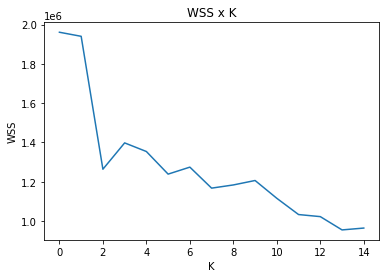

In [31]:
# Obtaining the best value of k
person_wss = calculate_WSS(df_person_num.values, 15)

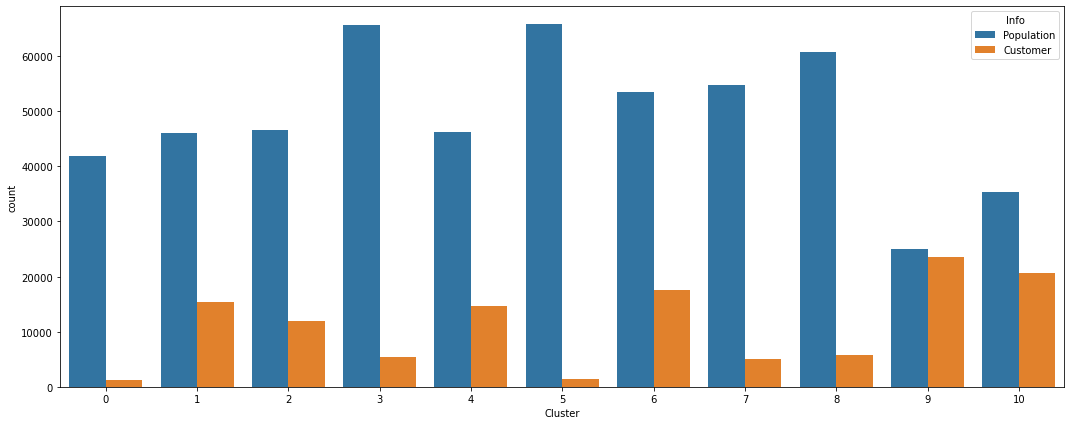

In [32]:
# Analysing the graphic above, the best value for k is 11
k_person = 11

# Using the KMeans algorithm
kmeans_person = KMeans(n_clusters = k_person, random_state=0).fit(df_person_num)

# Separating in clusters
person_cluster = kmeans_person.predict(df_person_num)

# Adding the cluster column to the dataframe
df_person_num['Cluster'] = person_cluster

# Adding the label (customer or azdias)
df_person_num['Info'] = origin_label

# Creating the graph of the cluster distribuition
fig, ax = plt.subplots(figsize = [18, 7])
ax = sns.countplot(data = df_person_num, x = 'Cluster', hue = 'Info')

**Analysis**
- Looking at the graph above, the cluster where population and customers are more similar is the cluster 9, followed by the cluster 10. Clusters 0 and 5 were the ones where the two groups were more different.

Now, looking quickly at the boxplots for each column, those where the graphs for clusters 9 are very different than the ones for clusters 0 and 5 will be chosen as good candidates of features that can be used to find possible new customers from the population dataset. 

**This will help narrow down the characteristics that make a person a potential customer.**

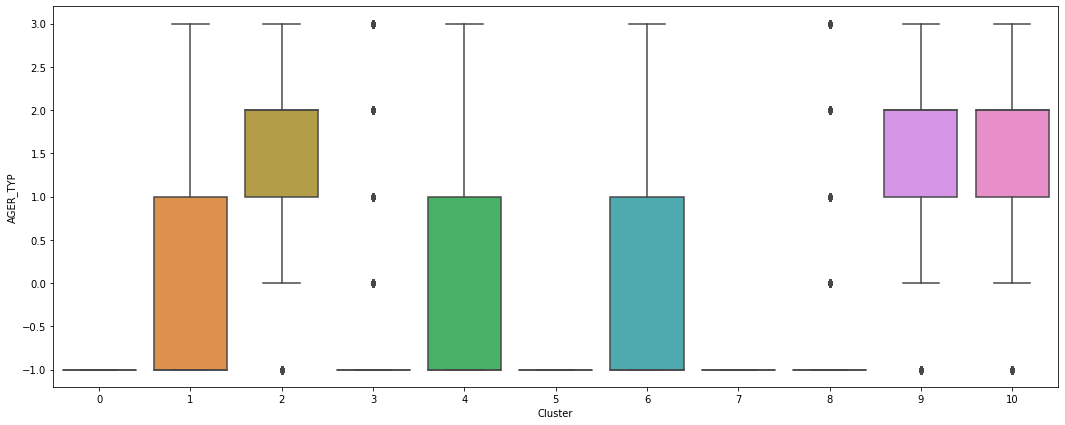

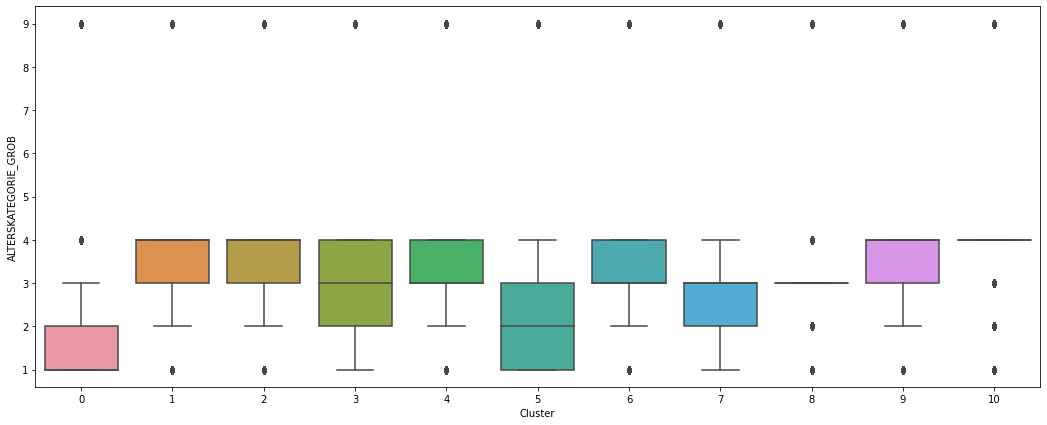

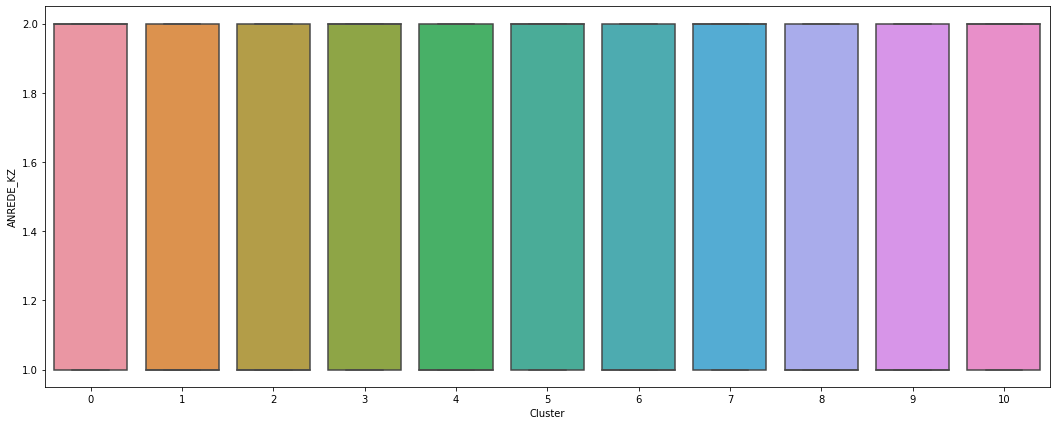

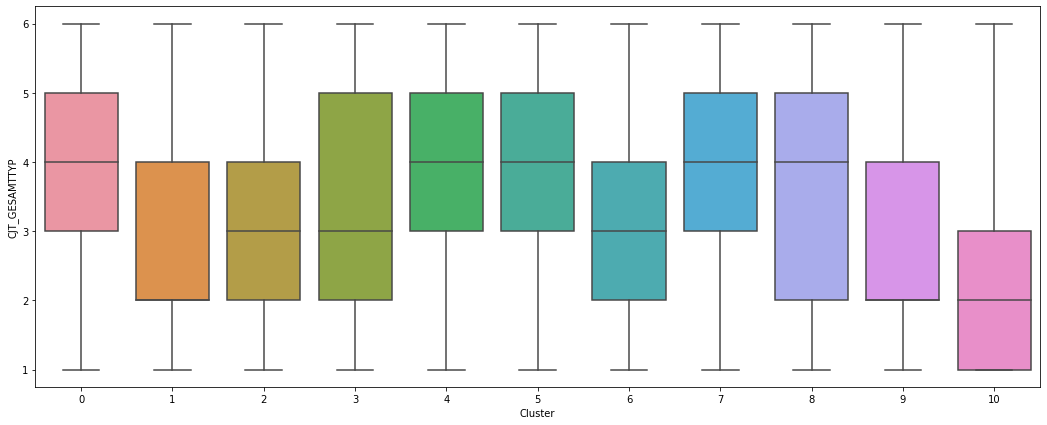

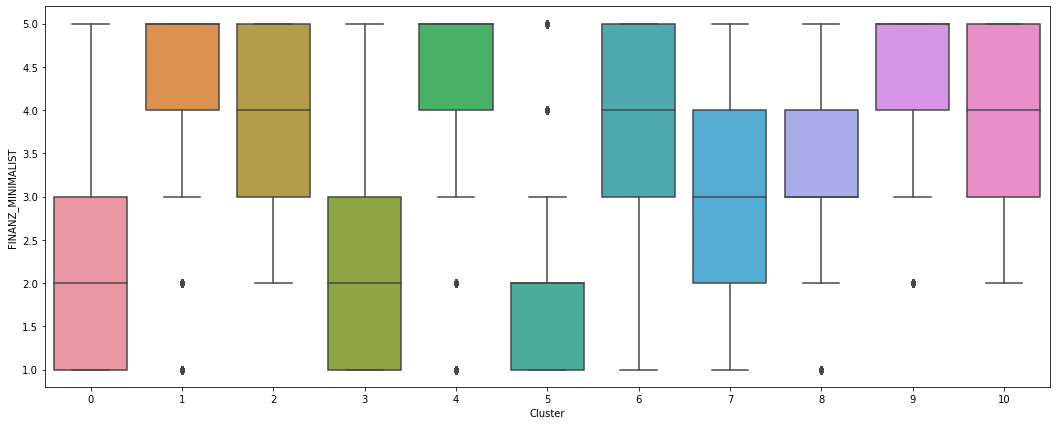

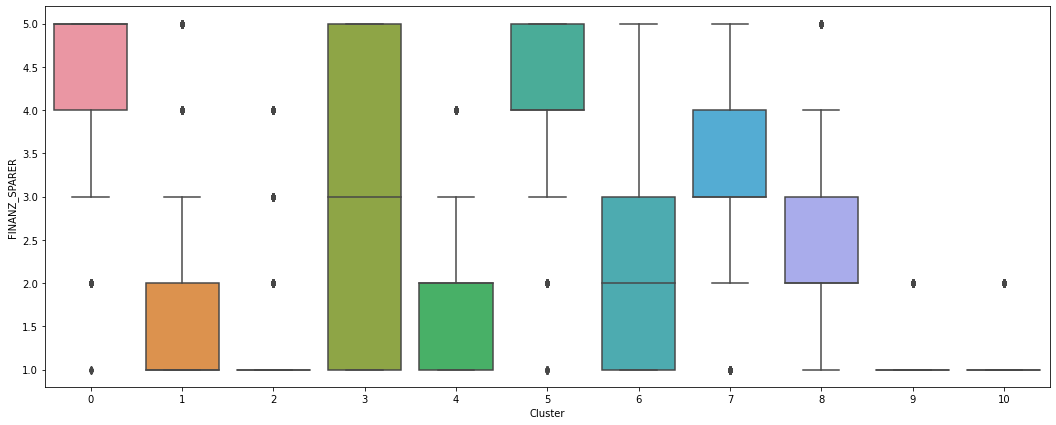

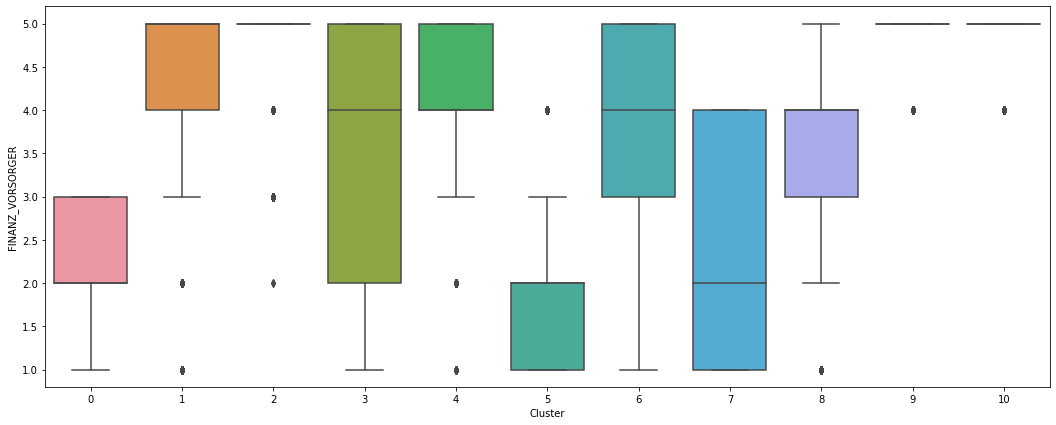

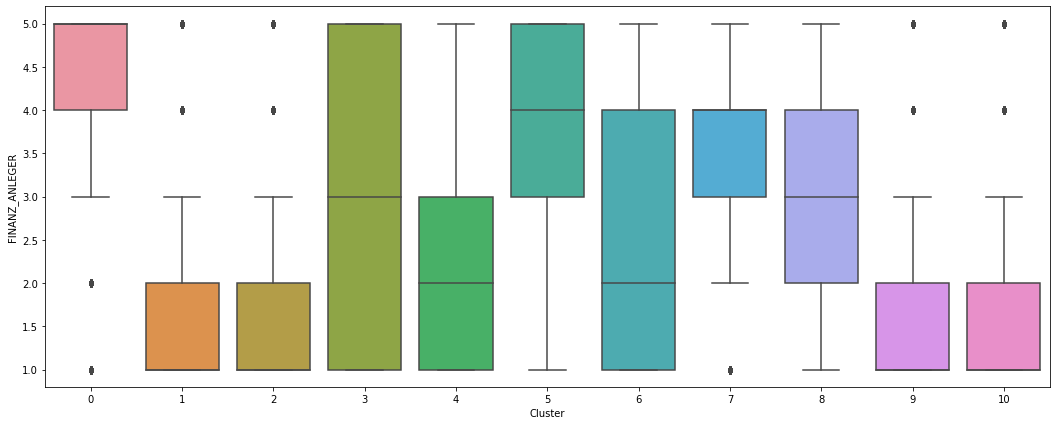

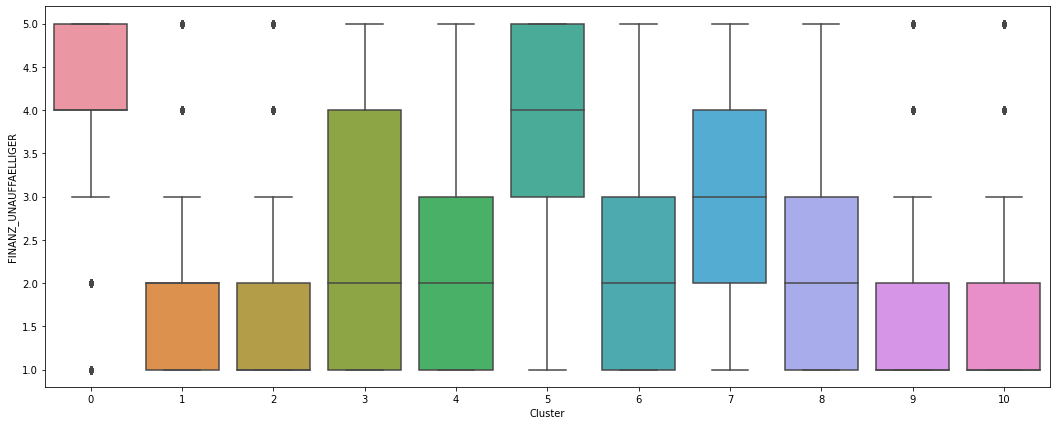

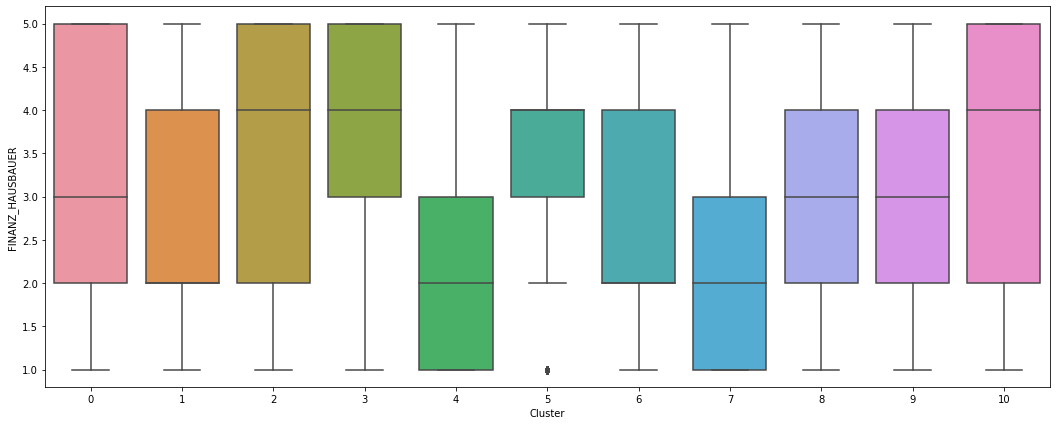

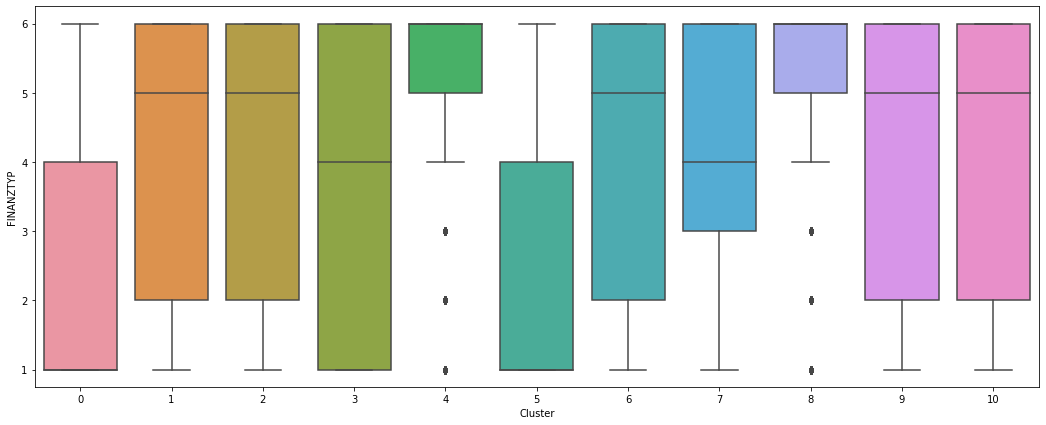

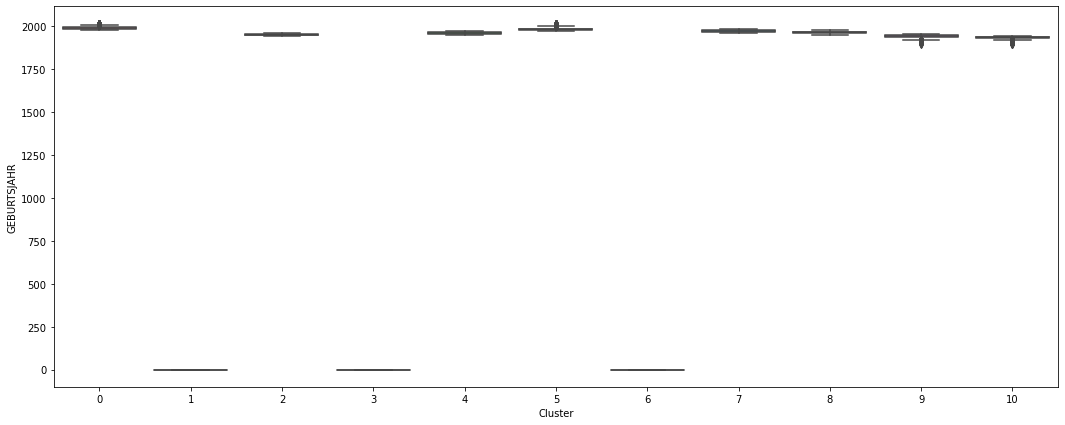

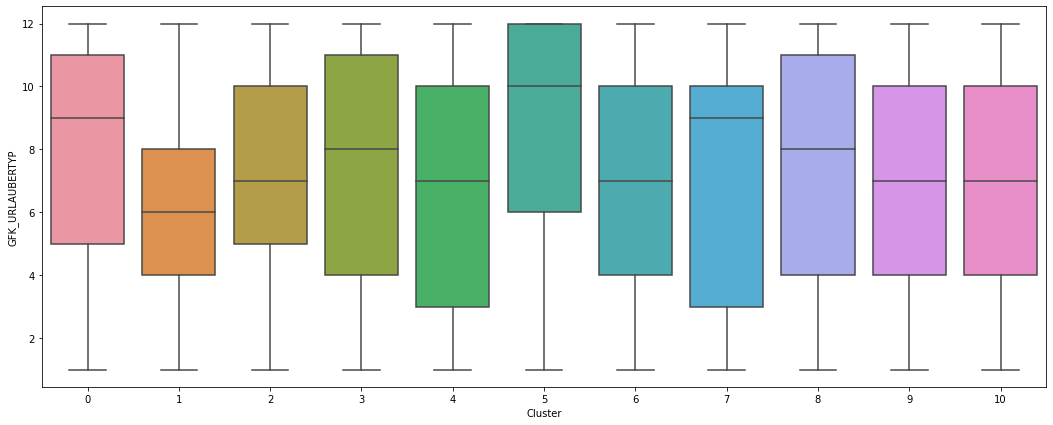

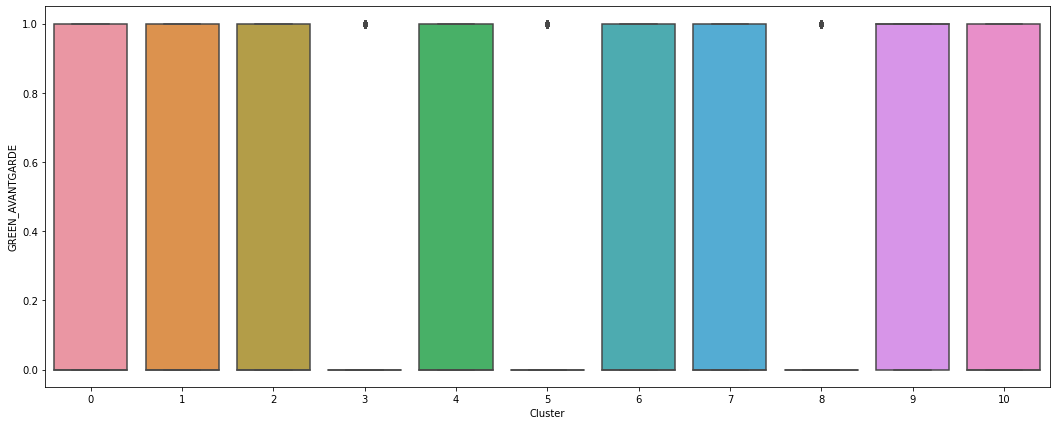

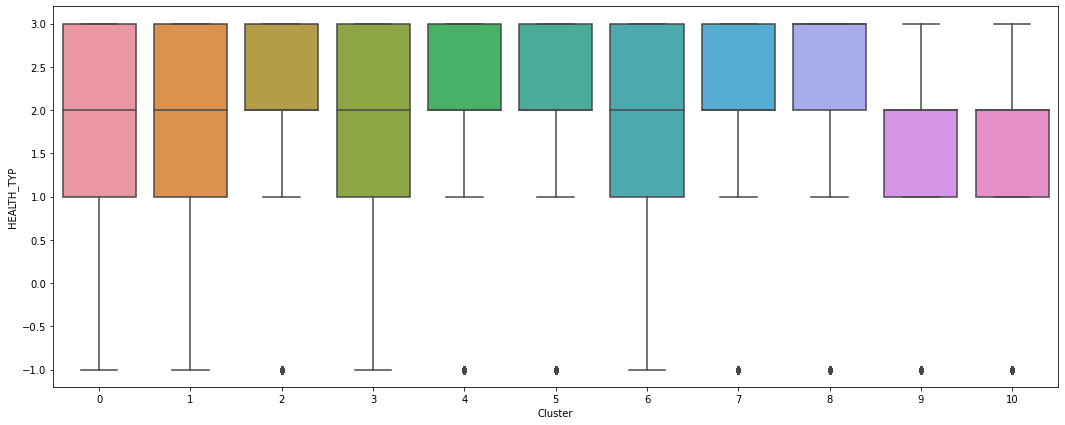

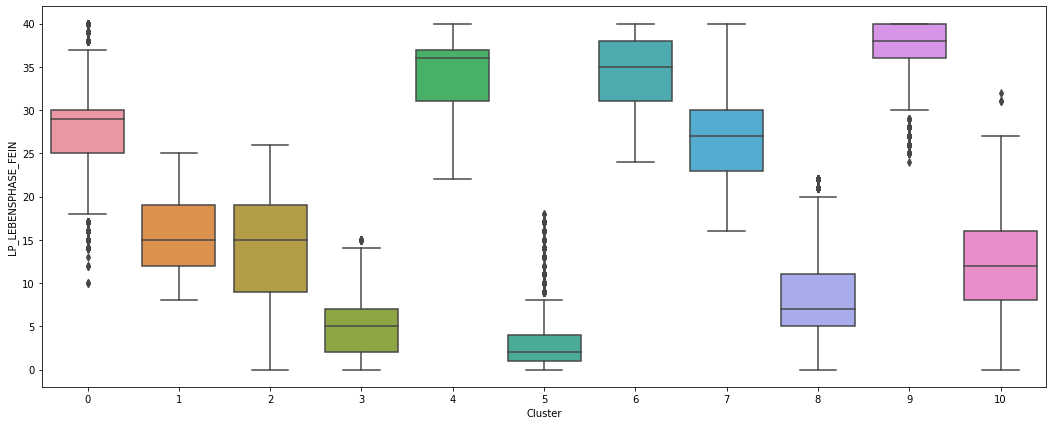

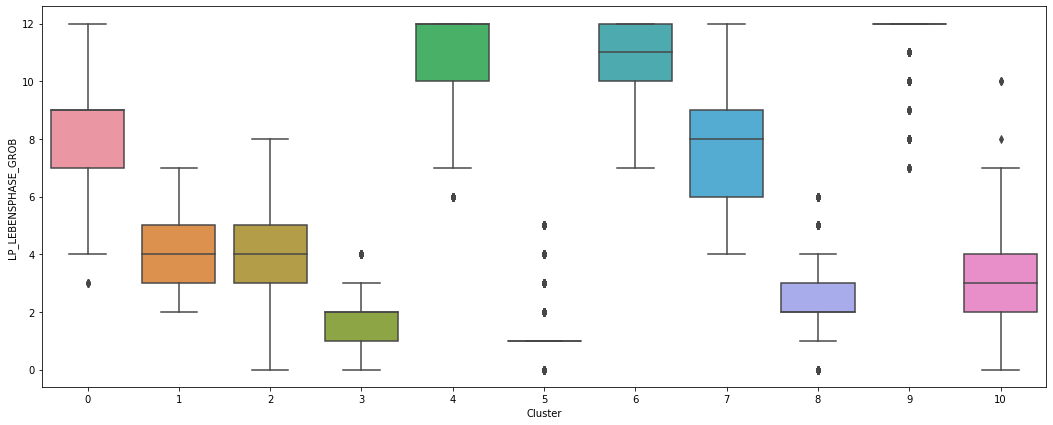

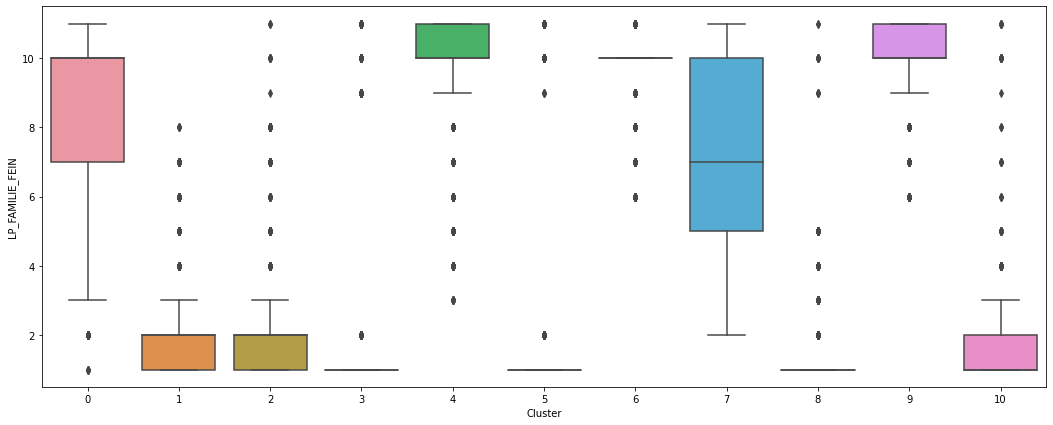

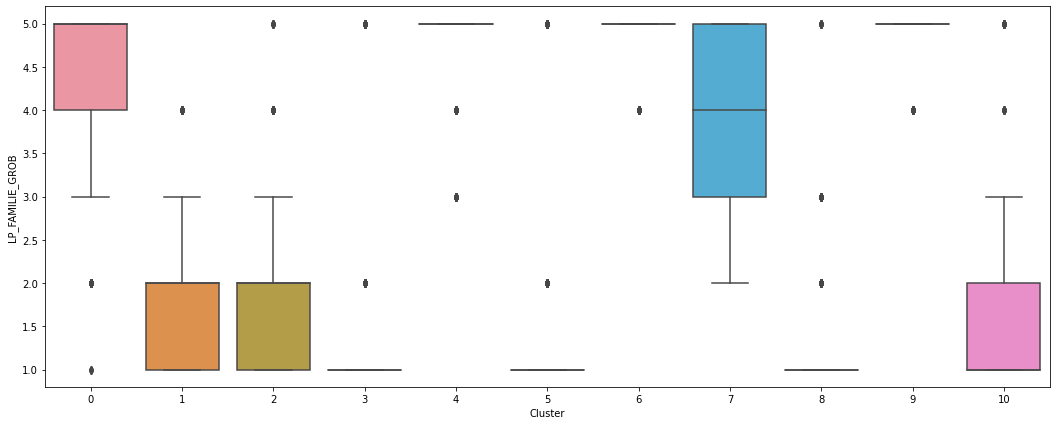

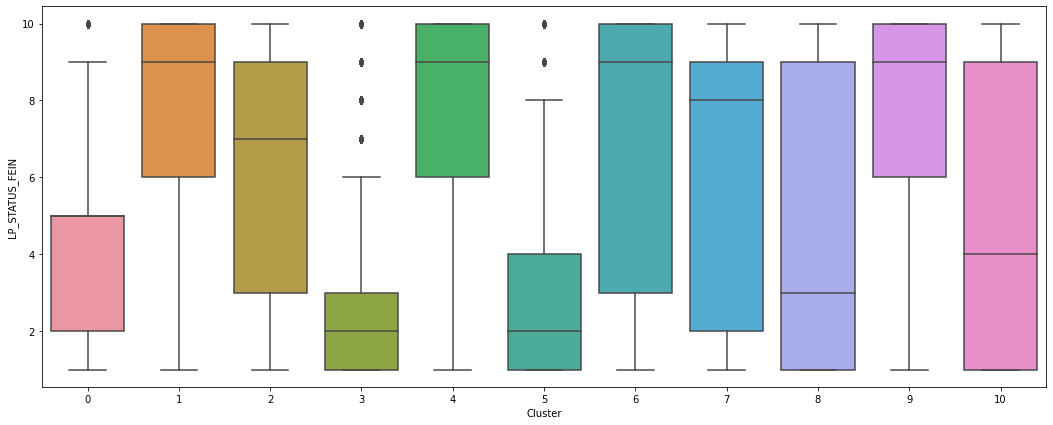

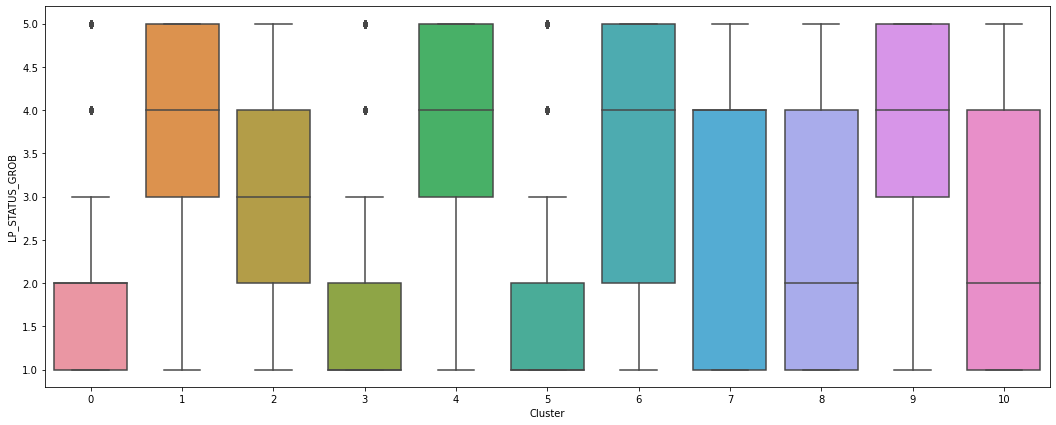

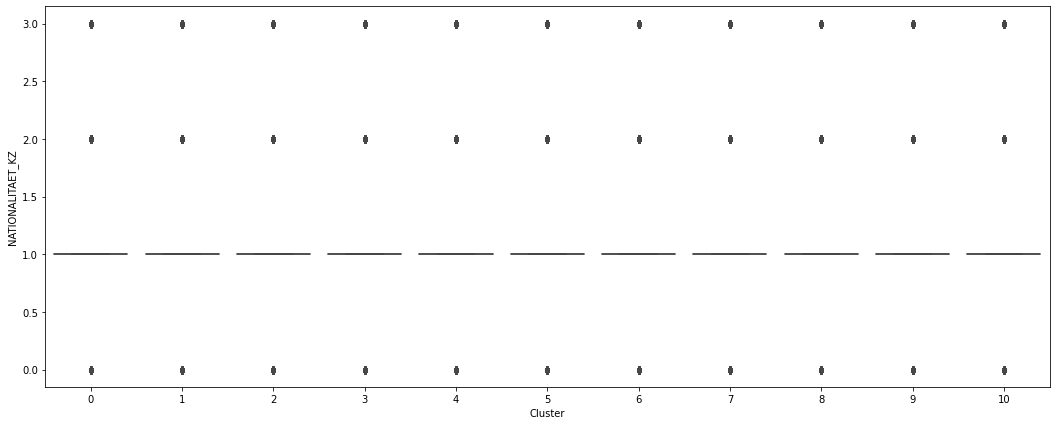

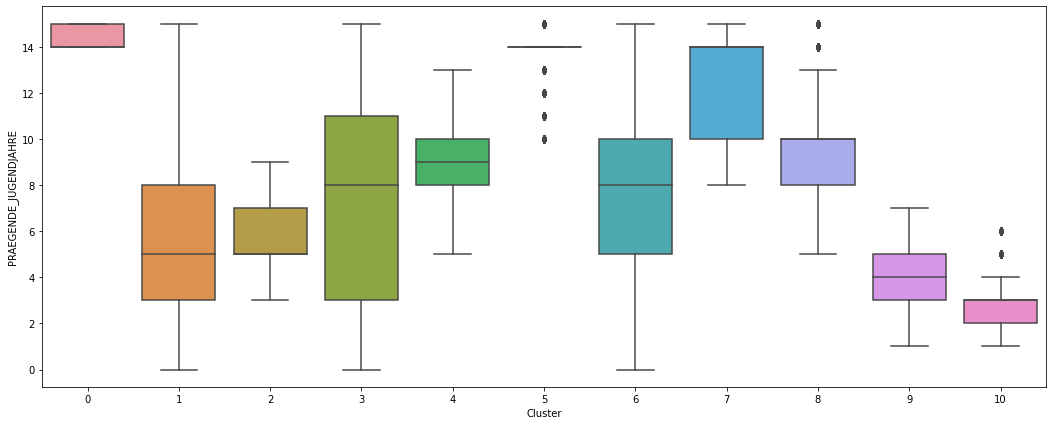

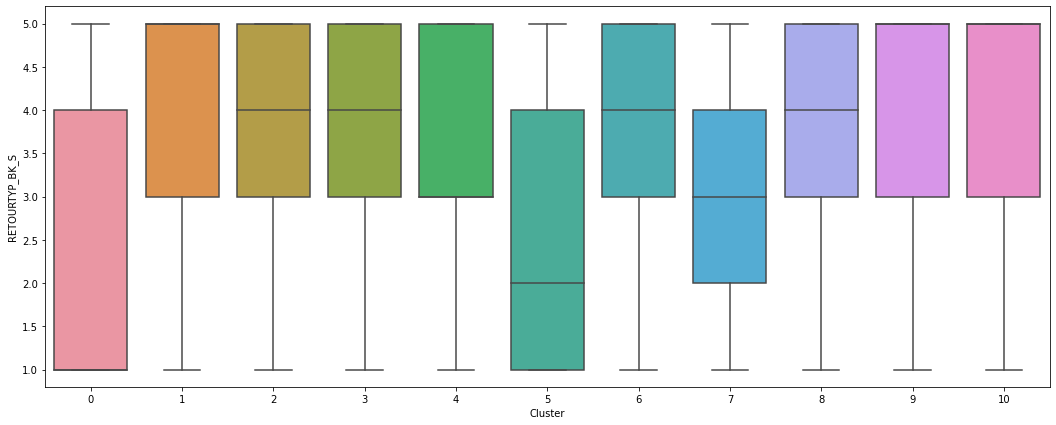

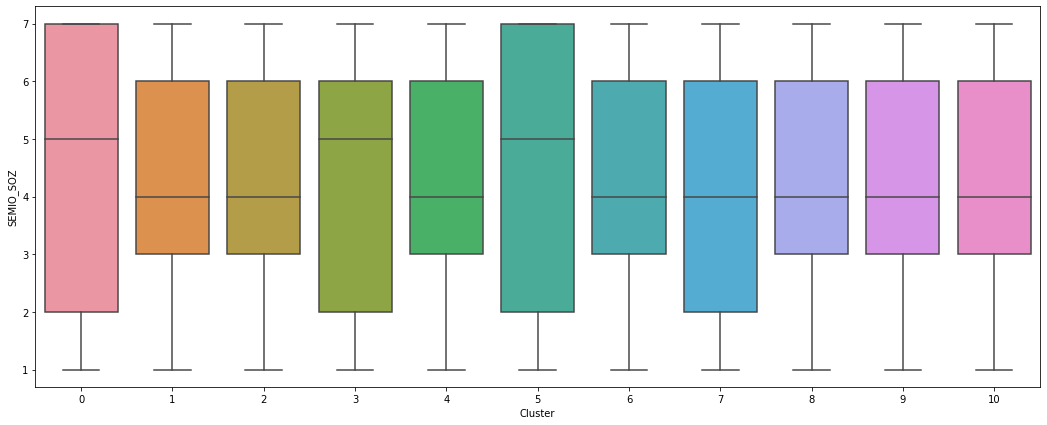

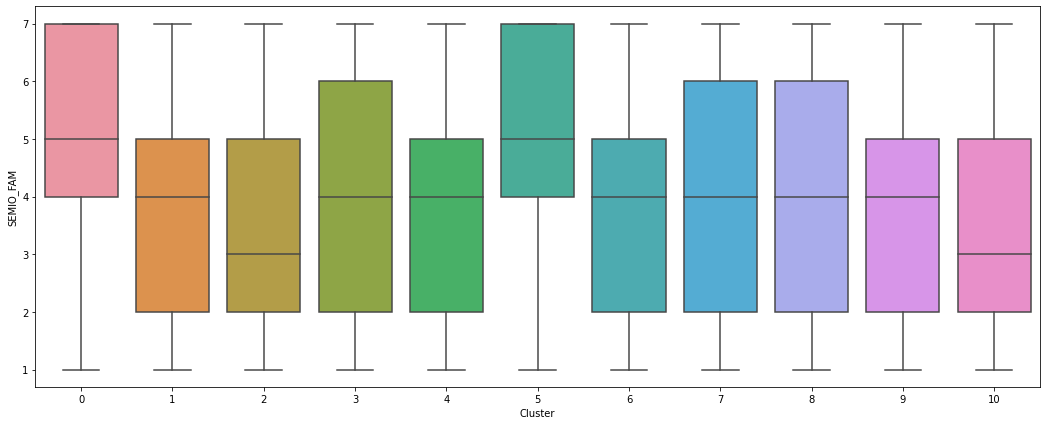

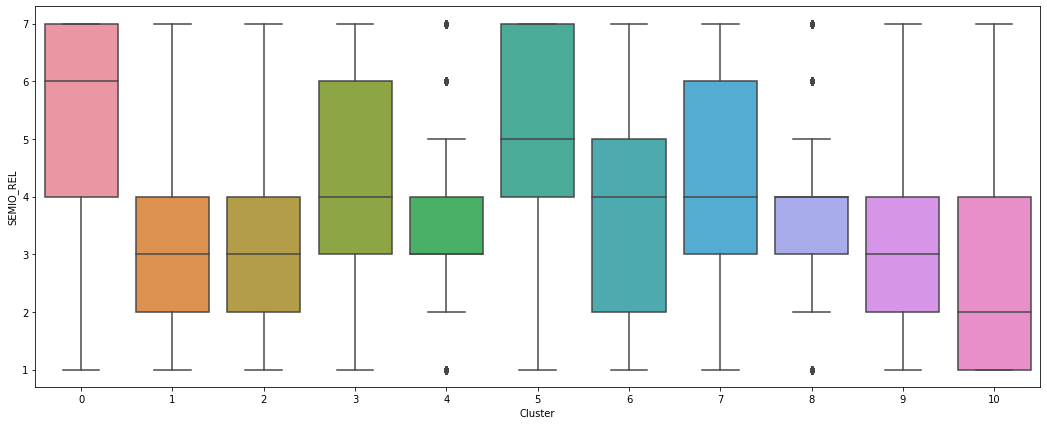

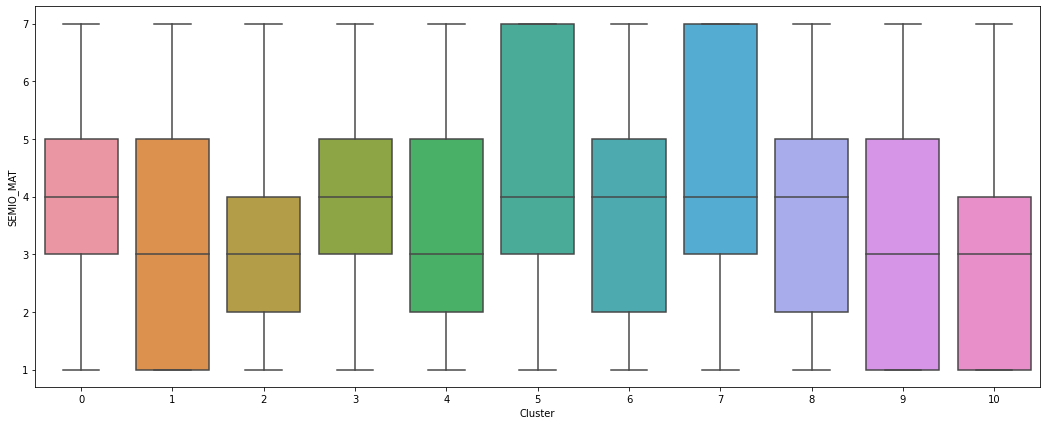

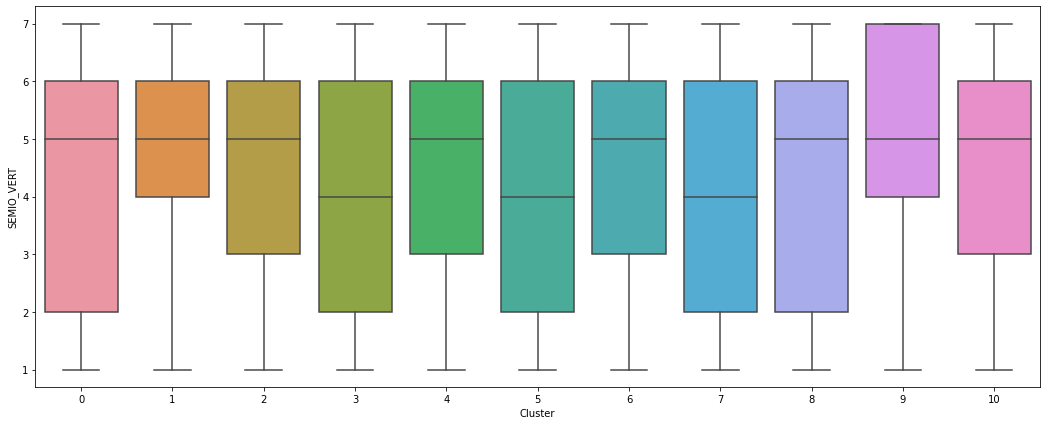

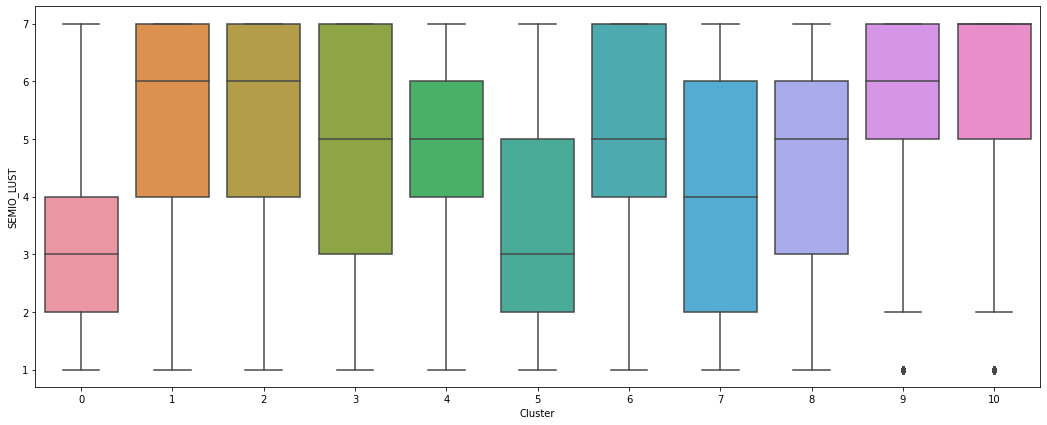

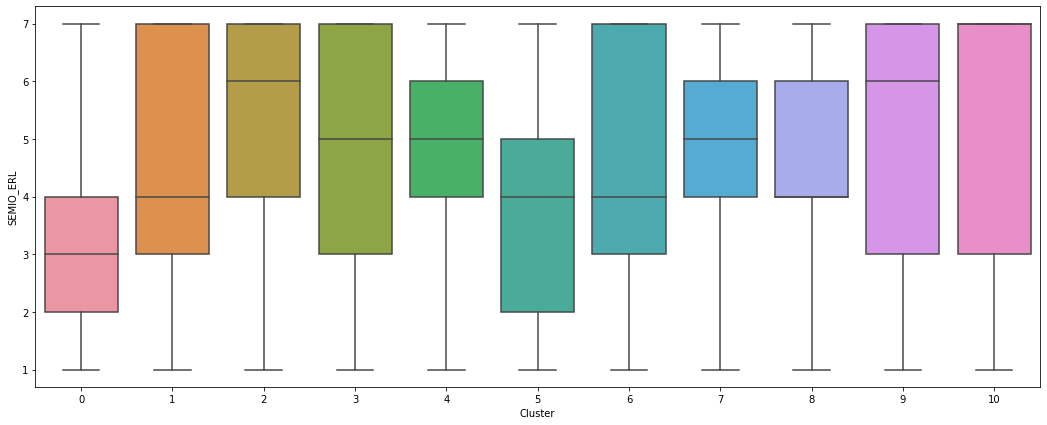

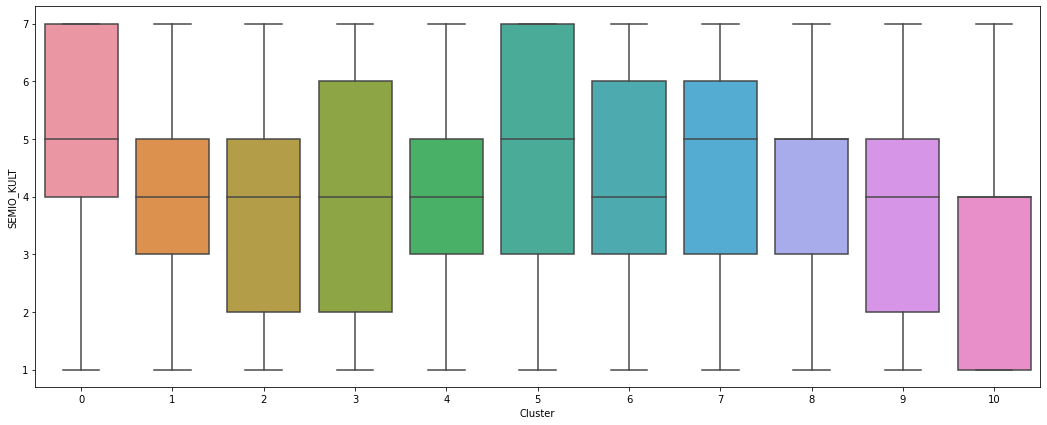

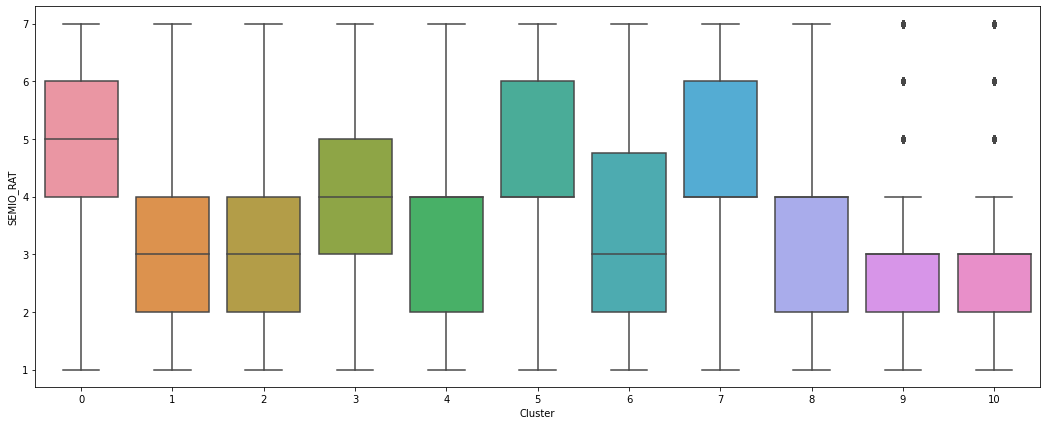

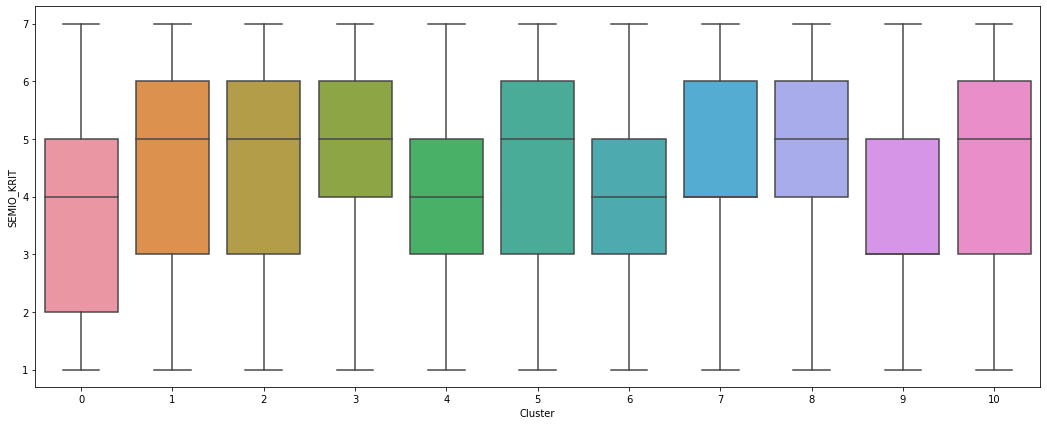

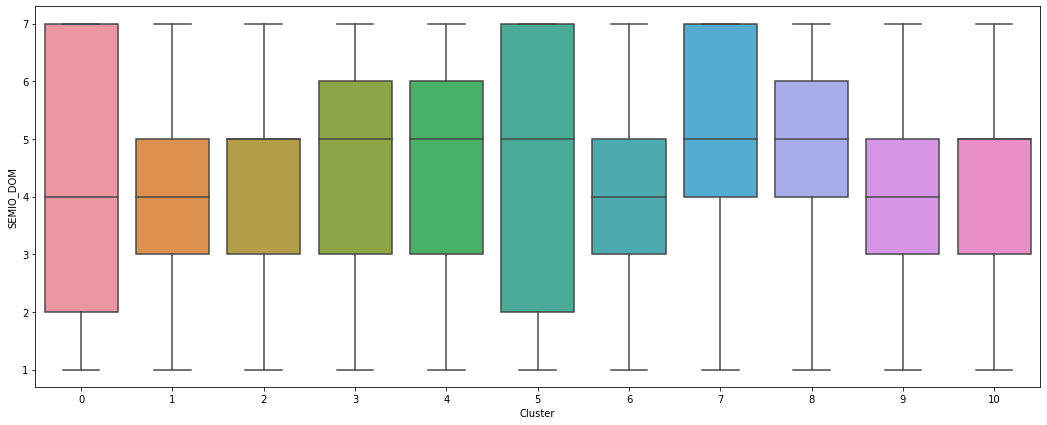

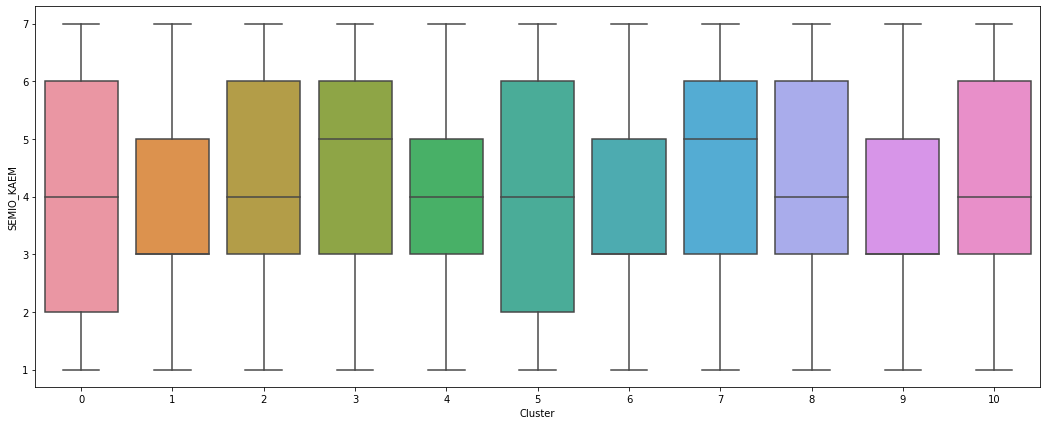

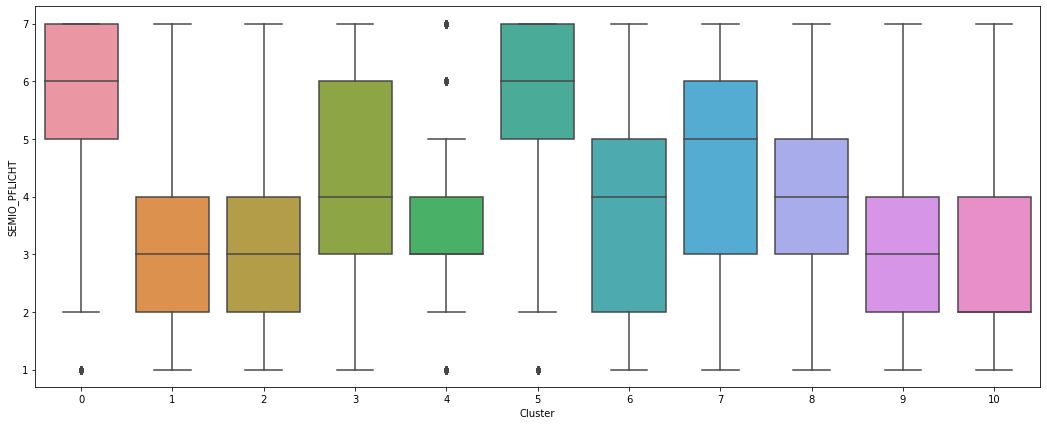

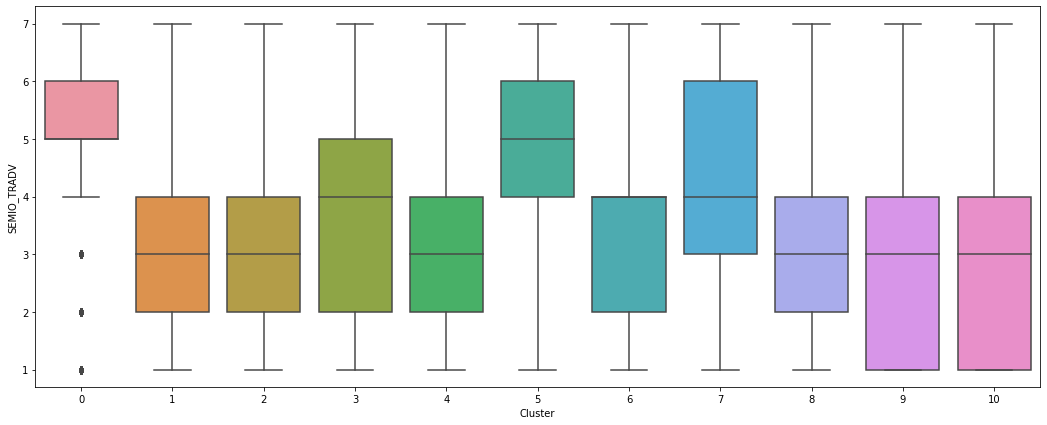

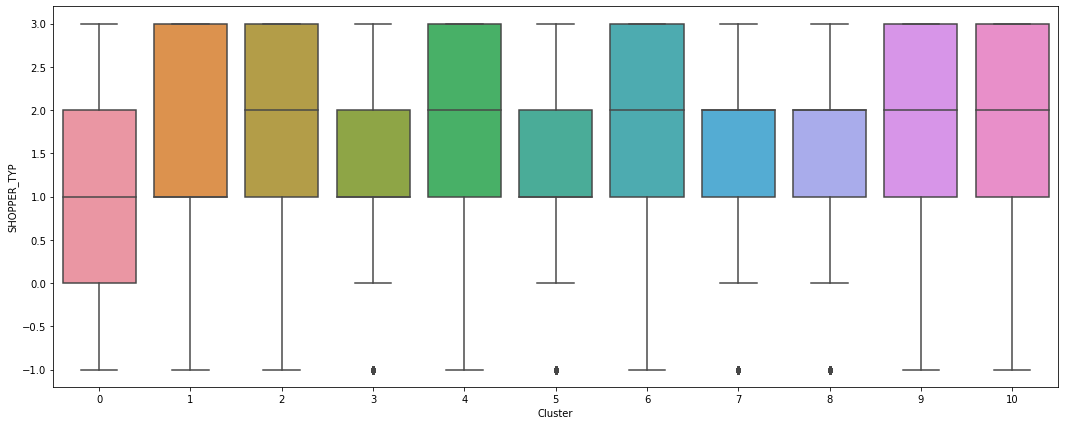

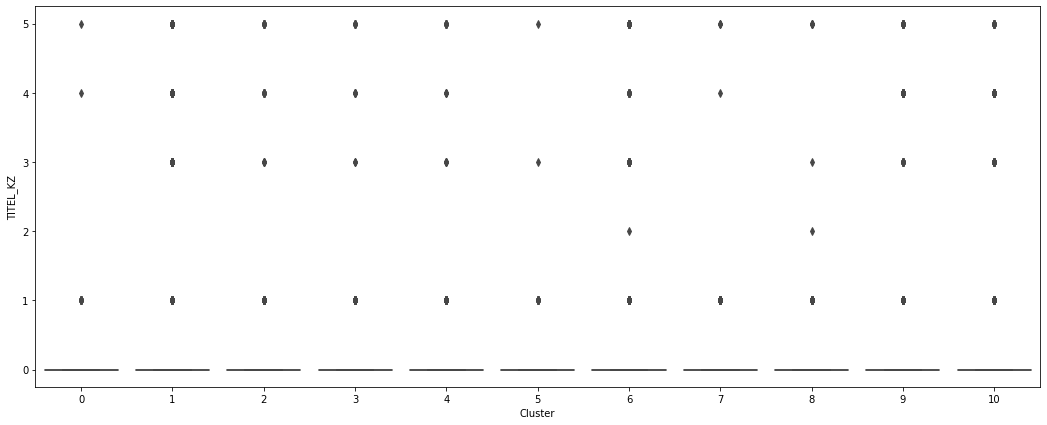

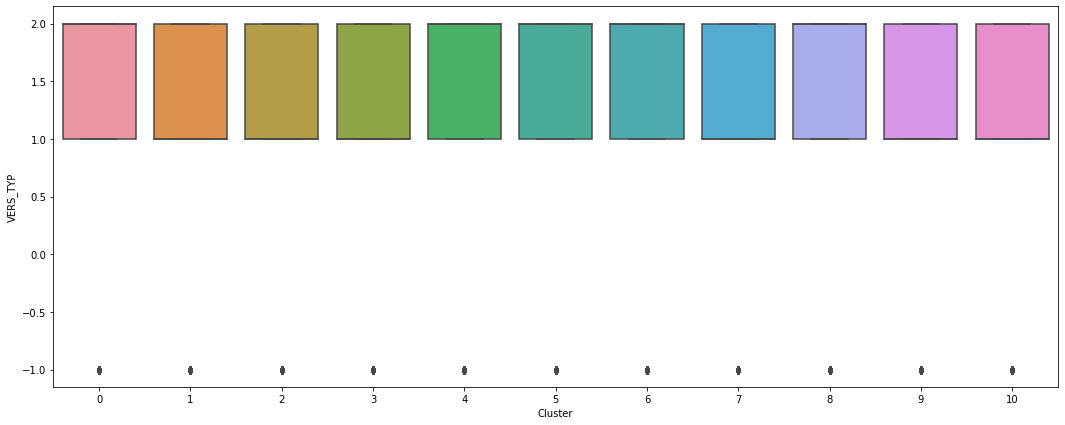

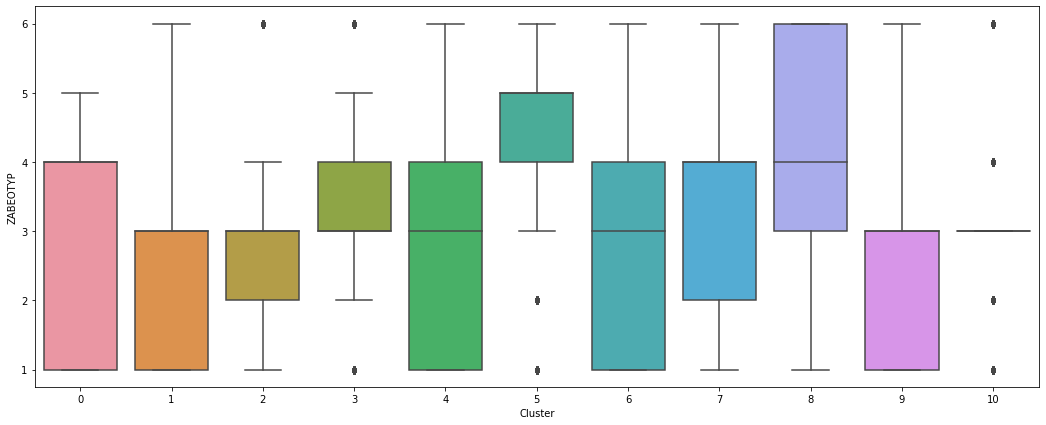

In [33]:
for col in person_cols_list:
    if col == 'Dataframe':
        pass
    else:
        fig, ax = plt.subplots(figsize = [18, 7])
        ax = sns.boxplot(data = df_person_num, x = 'Cluster', y = col
                        )

In [34]:
person_chosen_feat = [
    'AGER_TYP',
    'ALTERSKATEGORIE_GROB',
    'FINANZ_MINIMALIST',
    'FINANZ_SPARER',
    'FINANZ_VORSORGER',       # Need more information to fully understand what this column means
    'FINANZ_UNAUFFAELLIGER',  # Need more information to fully understand what this column means
    'LP_LEBENSPHASE_FEIN',
    'LP_LEBENSPHASE_GROB',
    'LP_FAMILIE_FEIN',
    'LP_FAMILIE_GROB',
    'LP_STATUS_FEIN',
    'LP_STATUS_GROB',
    'PRAEGENDE_JUGENDJAHRE',
    'SEMIO_REL',
    'SEMIO_LUST',
    'SEMIO_RAT',
    'SEMIO_PFLICHT',
    'SEMIO_TRADV'
]

print(f'Reduced the number of features from {len(person_cols)} to {len(person_chosen_feat)}')

Reduced the number of features from 42 to 18


**Conclusion:**

Looking at the graphs, the portion of the german population that most resembles the clients tend to:
- be more passive elderly or cultural elderly;
- have 46 years old or more;
- have high financial interest;
- be very money savers;
- be from multiperson households;
- be from multi-generational household;
- have high-income;
- have the dominating movement in their youth to be the economic miracle or the milk bar/individualisation
- be very religious;
- not be very sensual minded;
- be very rational;
- be more dutyfull traditional minded;
- be more traditional.


### Household information analysis

In [35]:
# Obtaining the columns in the Person Information Level
household_cols = df_columns[df_columns['Information_level'] == 'Household']
household_cols_list = list(household_cols['columns_to_use'].values)
household_cols_list.append('Dataframe')

# Creating the dataframe
df_household = data[household_cols_list]

df_household_num, origin_label = numeric_df(df_household)

print('Shape of the data: ', df_household.shape)

Number of numeric columns:  27
Shape of the data:  (664127, 28)


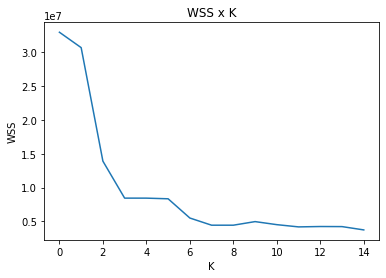

In [36]:
# Obtaining the best value of k
household_wss = calculate_WSS(df_household_num.values, 15)

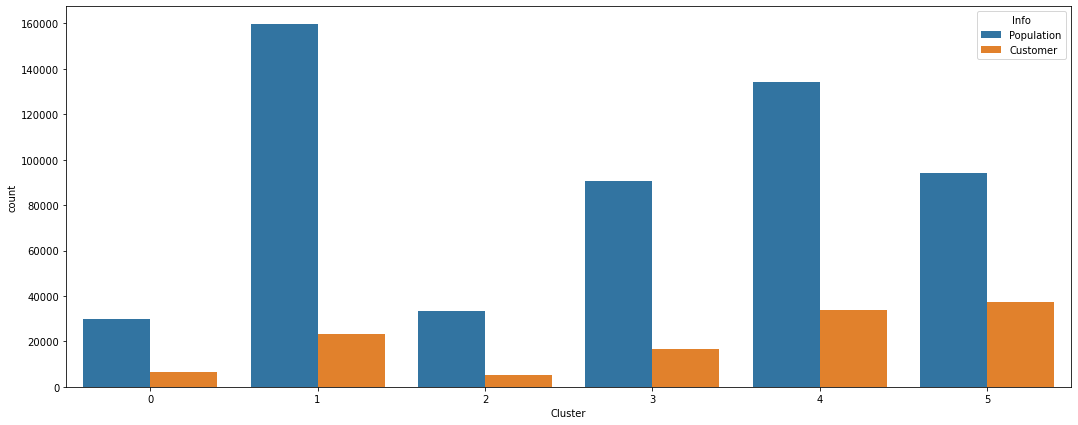

In [37]:
# Analysing the graphic above, the best value for k is 6
k_household = 6

# Using the KMeans algorithm
kmeans_household = KMeans(n_clusters = k_household, random_state=0).fit(df_household_num)

# Separating in clusters
household_cluster = kmeans_household.predict(df_household_num)

# Adding the cluster column to the dataframe
df_household_num['Cluster'] = household_cluster

# Adding the label (customer or azdias)
df_household_num['Info'] = origin_label

# Creating the graph of the cluster distribuition
fig, ax = plt.subplots(figsize = [18, 7])
ax = sns.countplot(data = df_household_num, x = 'Cluster', hue = 'Info')

**Analysis**

- For this group of information, there wasn't a cluster that clearly showed similarity between the two groups. Here, we can use clusters 5, 1 and 3 to make an analysis, but the results should be less trustworthy than the previous one.

- Following the same analysis as before, the clusters chosen to help determin what are the caracteristics of possible customers are: 5 (similarity between populatio and customers) and 1 and 3 (difference between populatio and customers).

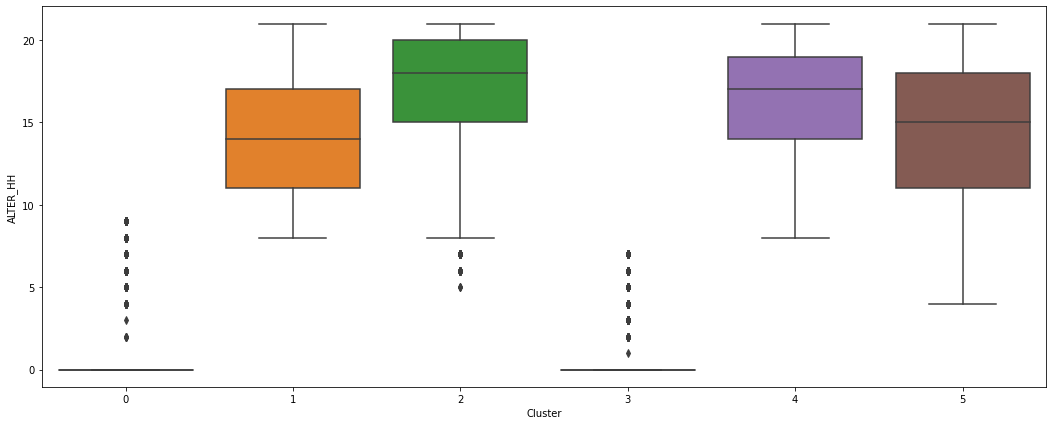

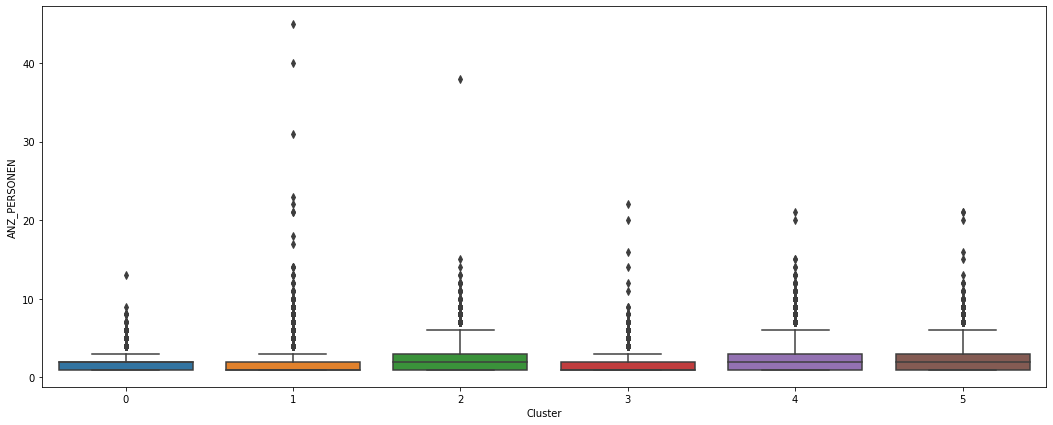

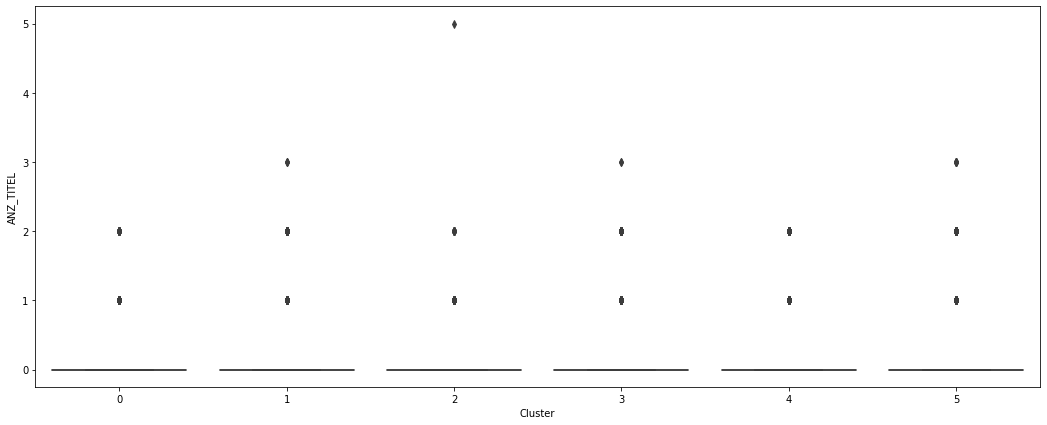

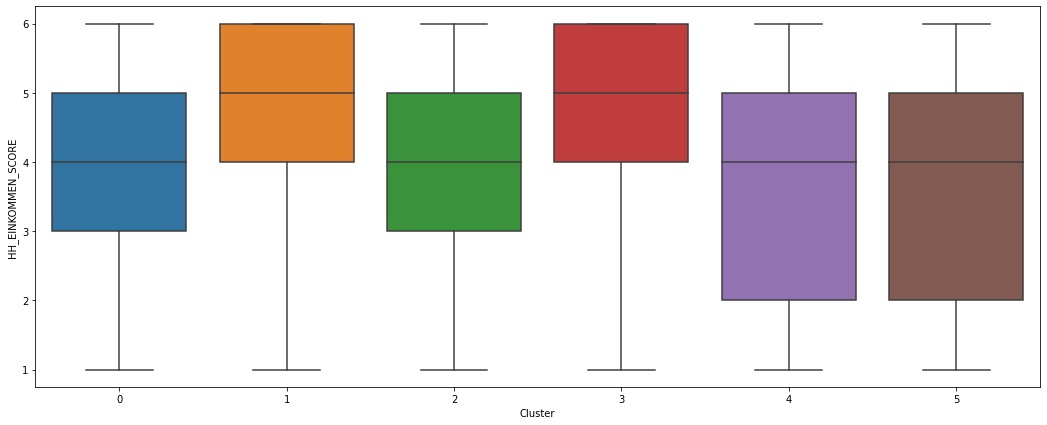

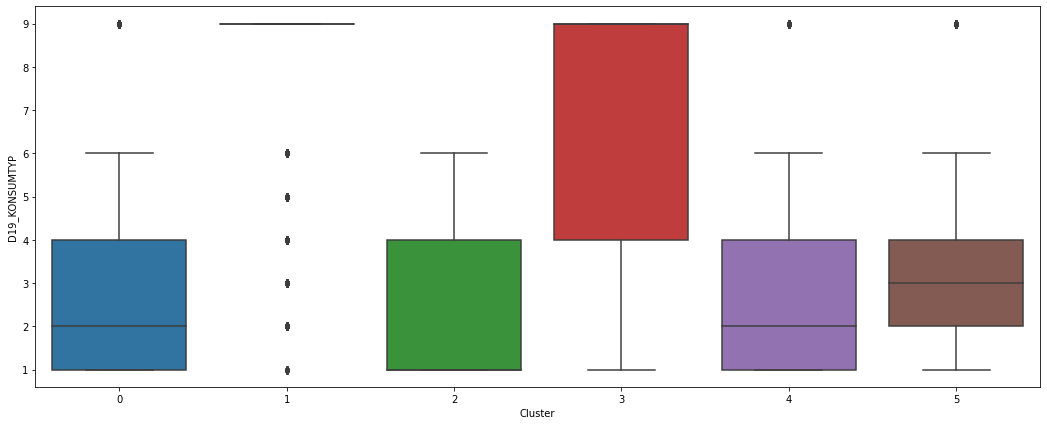

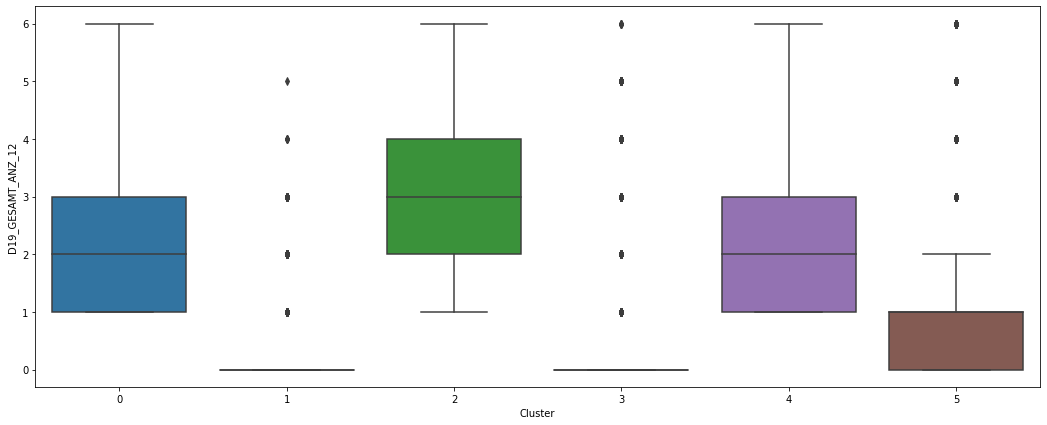

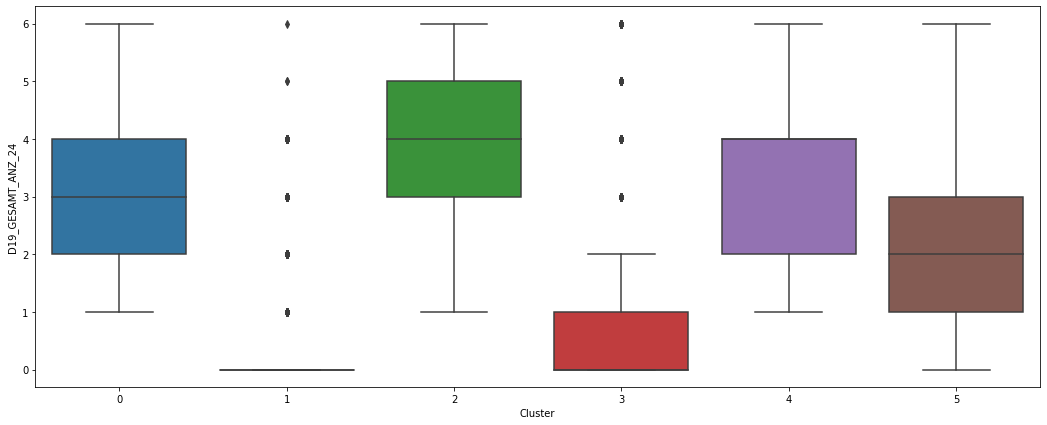

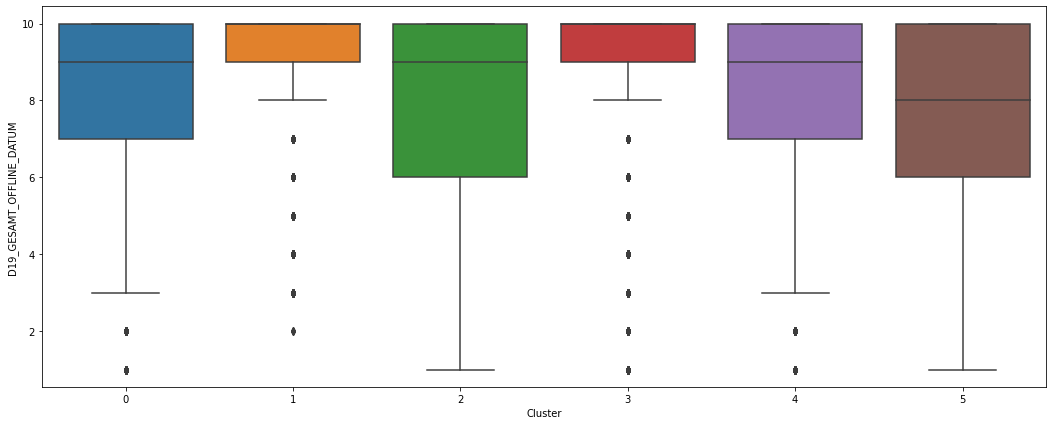

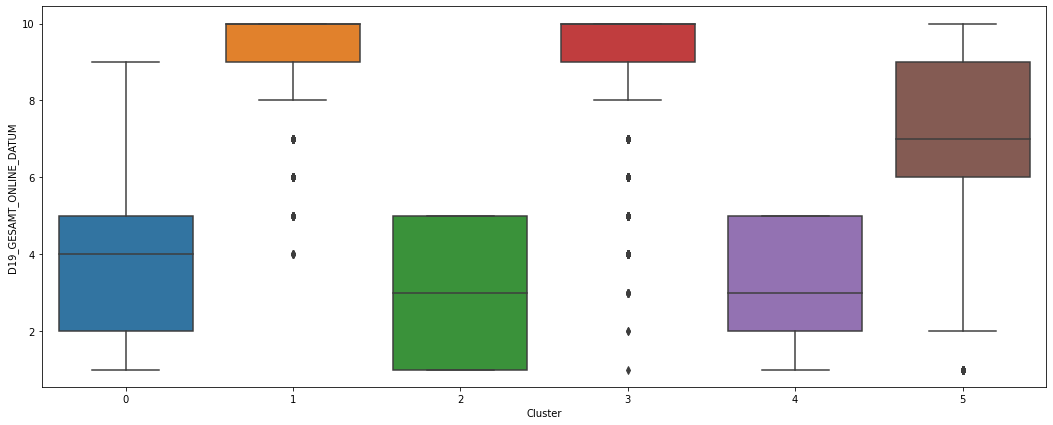

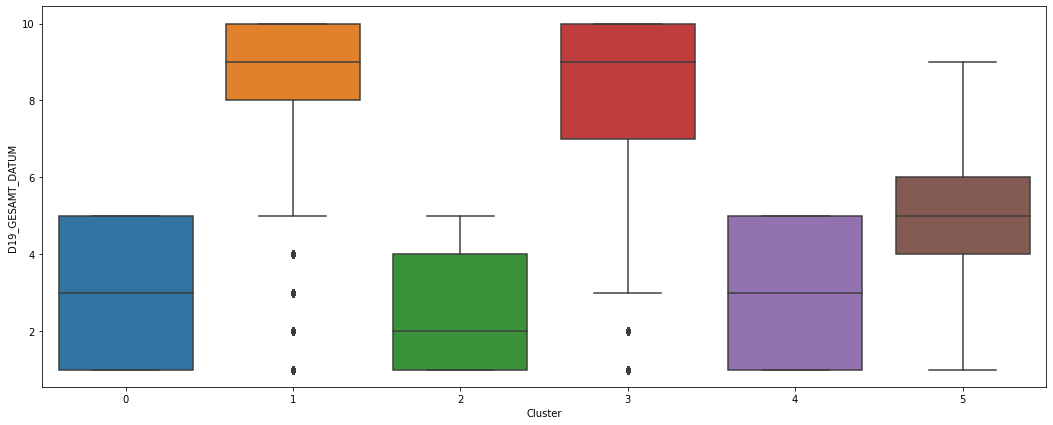

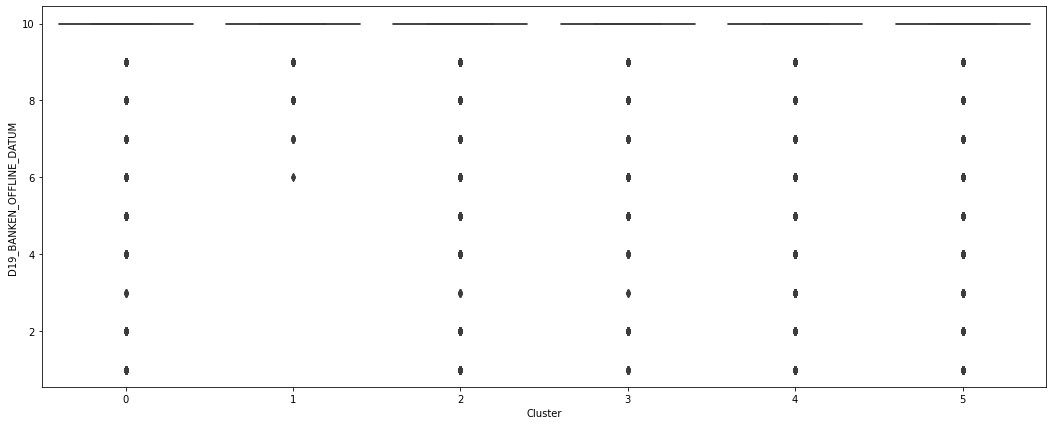

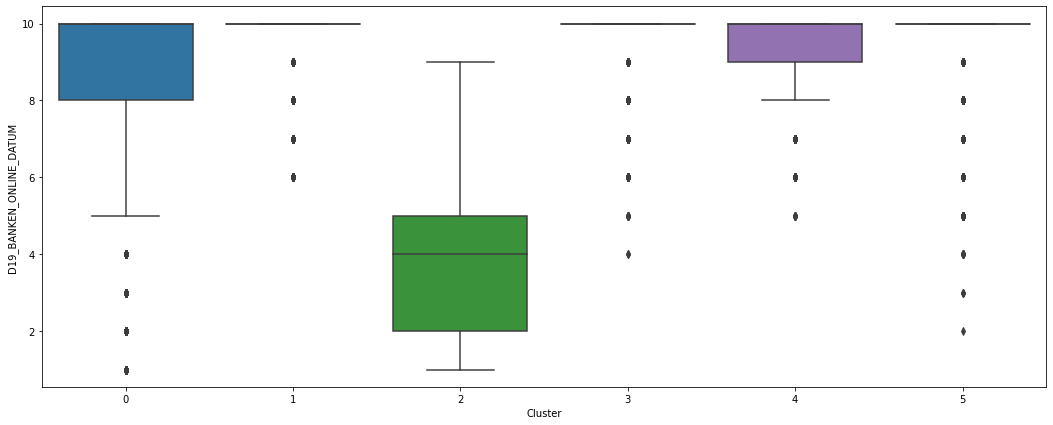

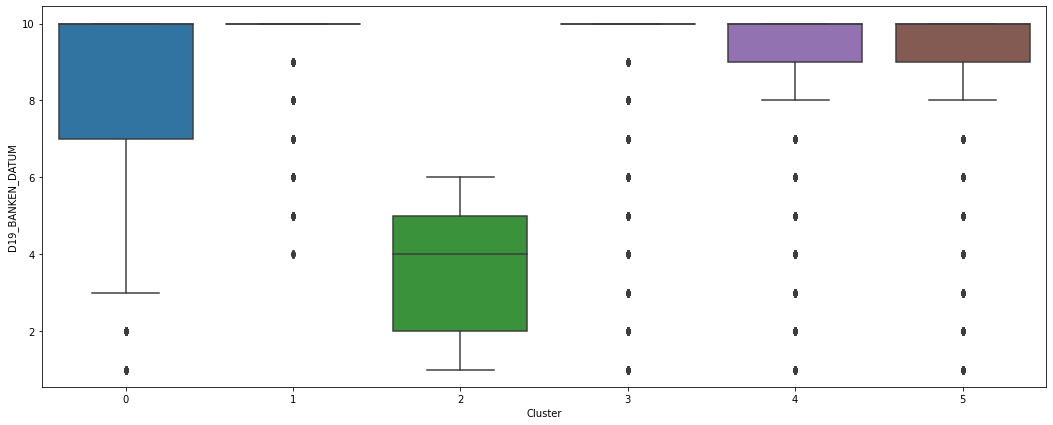

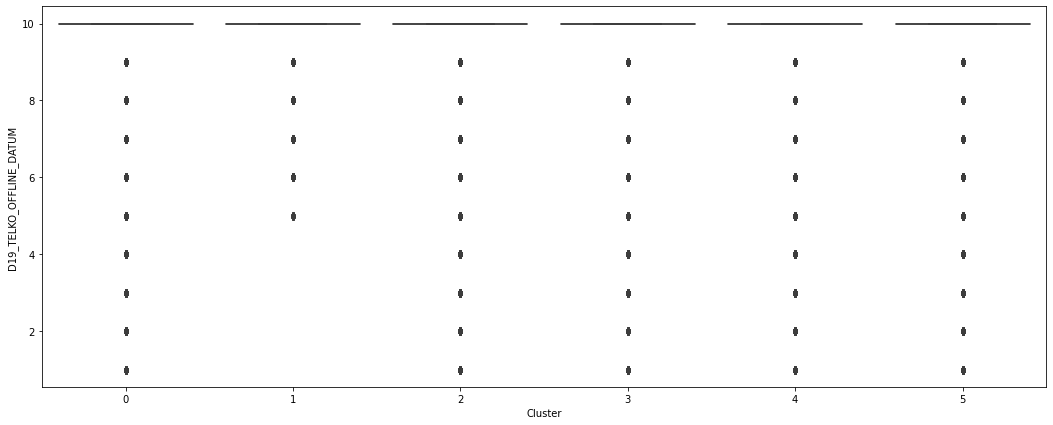

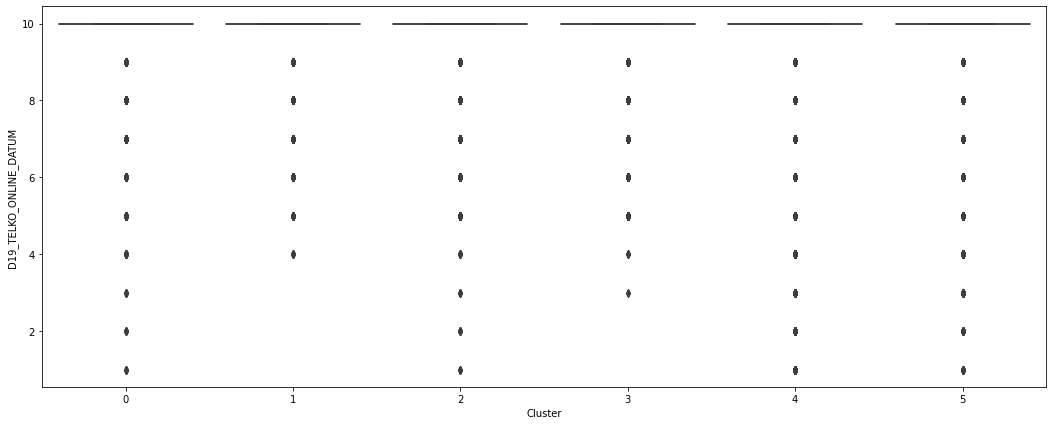

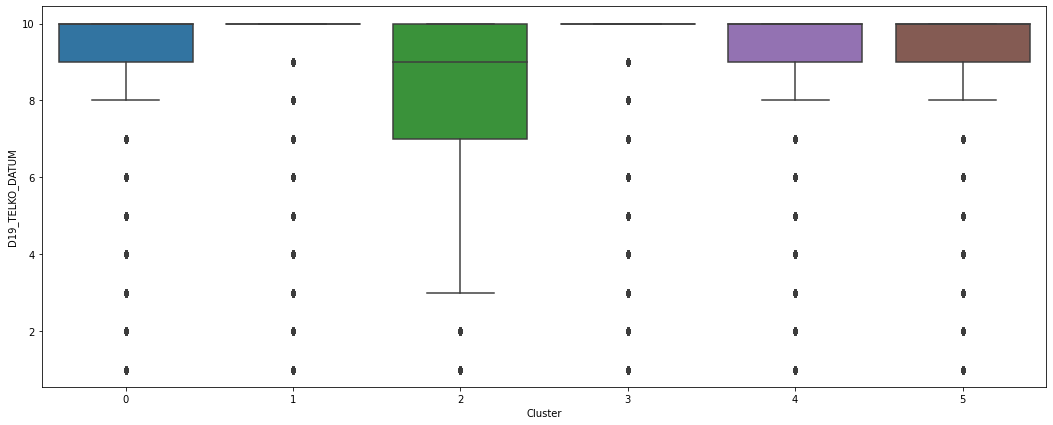

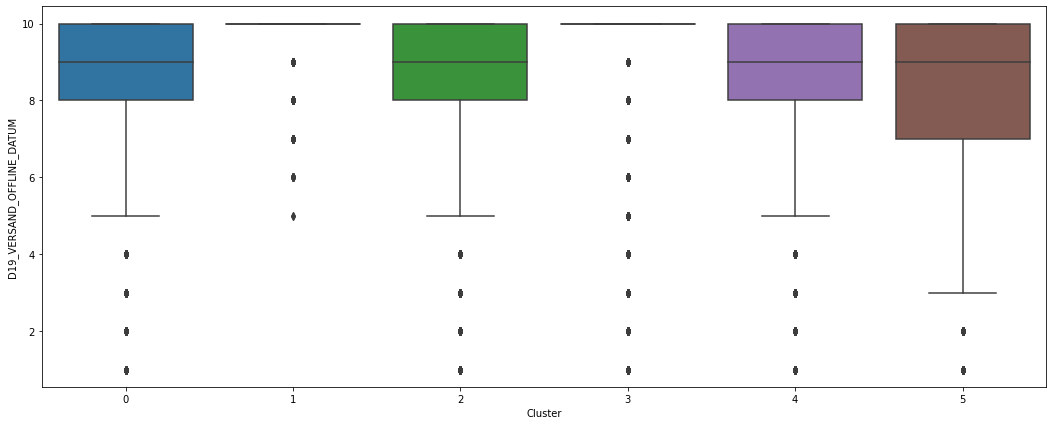

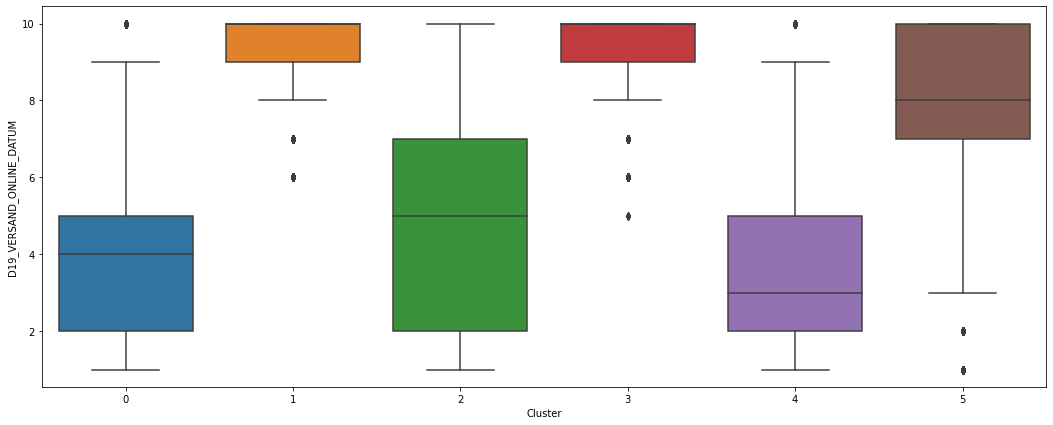

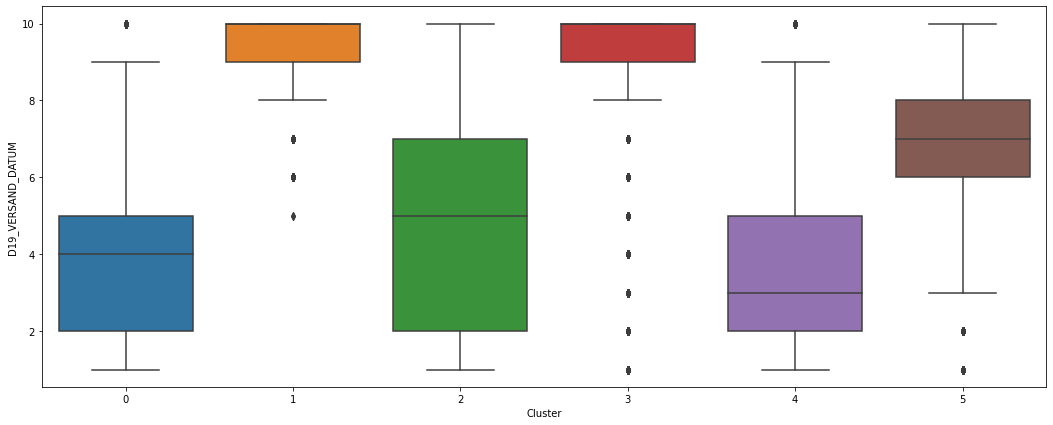

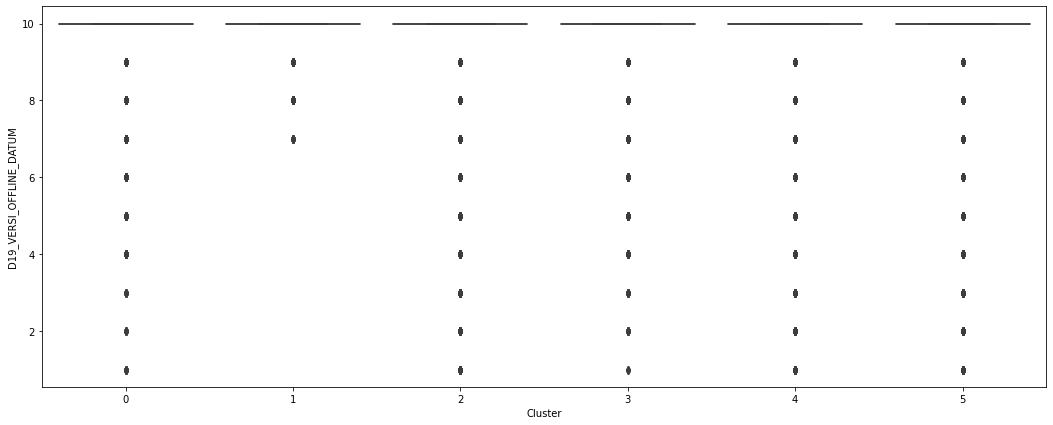

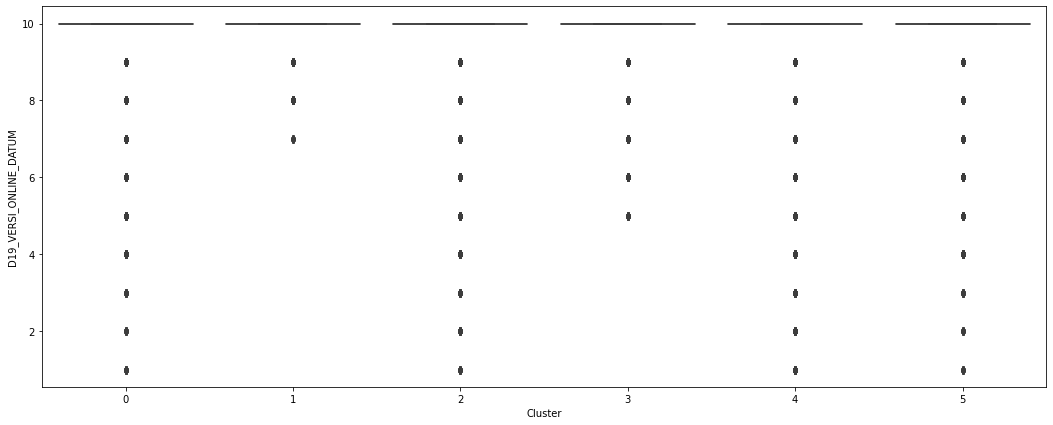

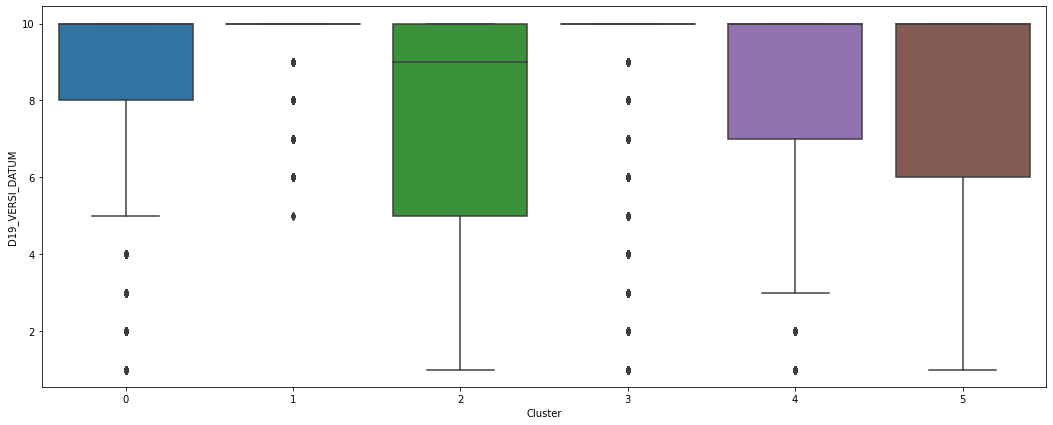

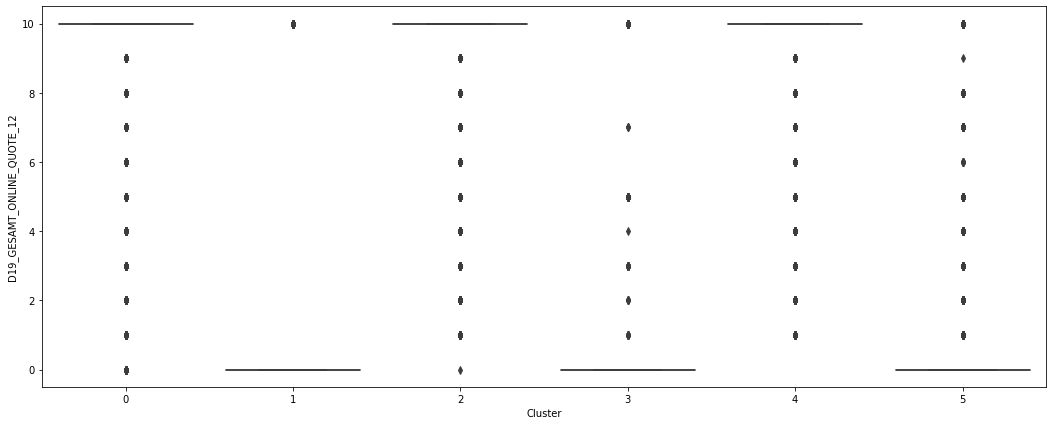

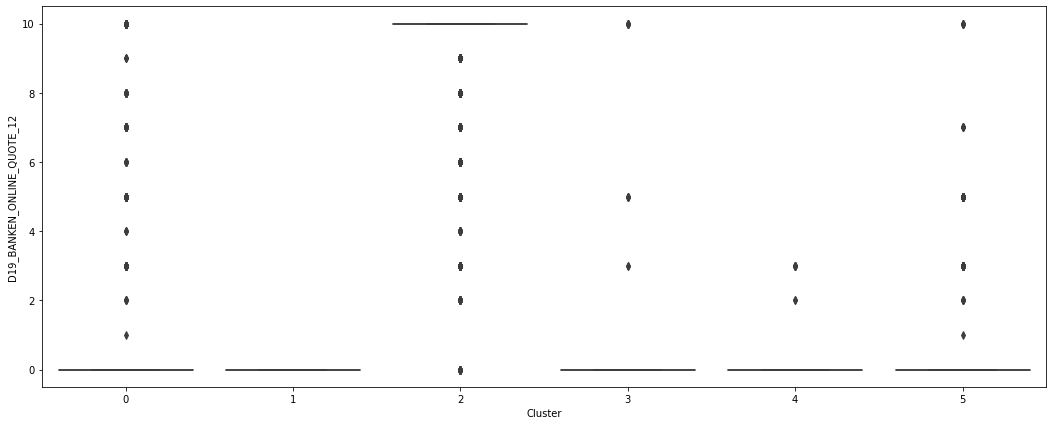

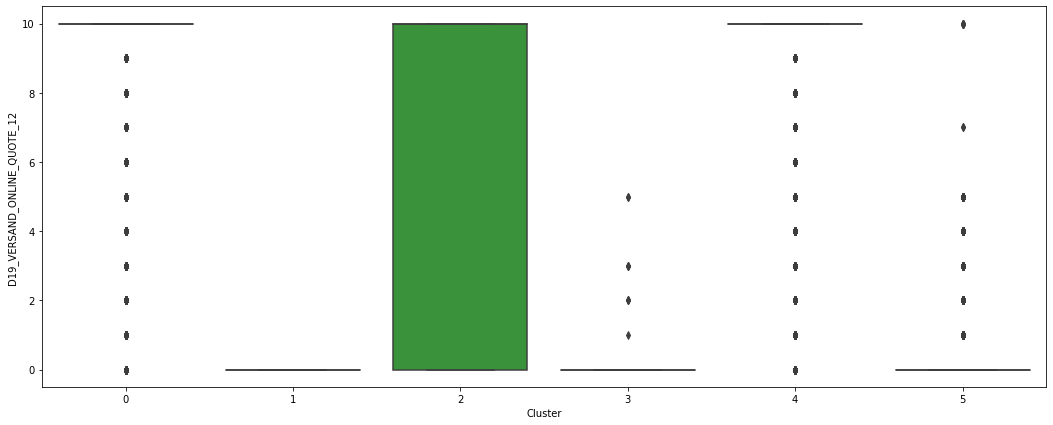

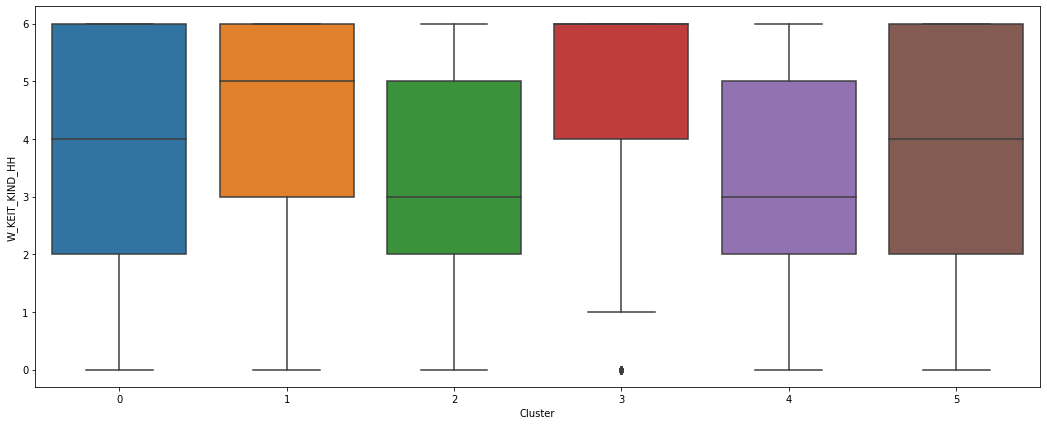

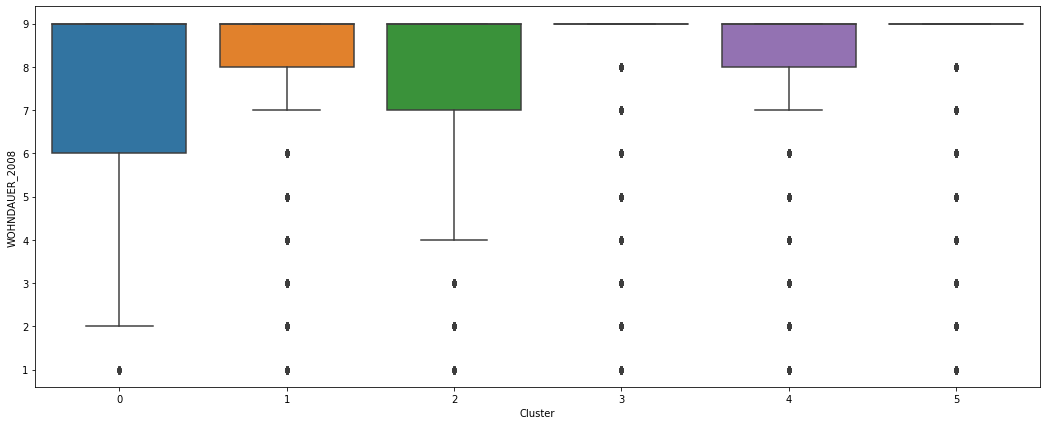

In [38]:
for col in household_cols_list:
    if col == 'Dataframe':
        pass
    else:
        fig, ax = plt.subplots(figsize = [18, 7])
        ax = sns.boxplot(data = df_household_num, x = 'Cluster', y = col
                        )

In [39]:
household_chosen_feat = [
    'ALTER_HH',
    'D19_GESAMT_ANZ_12',
    'D19_GESAMT_ANZ_24',
    'D19_GESAMT_OFFLINE_DATUM',   # Need more information to fully understand what this column means
    'D19_GESAMT_ONLINE_DATUM',    # Need more information to fully understand what this column means
    'D19_VERSAND_DATUM',          # Need more information to fully understand what this column means
]

print(f'Reduced the number of features from {len(household_cols)} to {len(household_chosen_feat)}')

Reduced the number of features from 27 to 6


**Conclusion:**

Looking at the graphs, the portion of the german population that most resembles the clients tend to:
- have a more gourmet and versatile consumption type;
- have a very low transaction activity in the last 12 and 24 months;

**Observation**
- Some of the meanings of the columns were hard to understand.

### Building information analysis

In [40]:
# Obtaining the columns in the Person Information Level
building_cols = df_columns[df_columns['Information_level'] == 'Building']
building_cols_list = list(building_cols['columns_to_use'].values)
building_cols_list.append('Dataframe')

# Creating the dataframe
df_building = data[building_cols_list]

df_building_num, origin_label = numeric_df(df_building)

print('Shape of the data: ', df_building.shape)

Number of numeric columns:  8
Shape of the data:  (664127, 10)


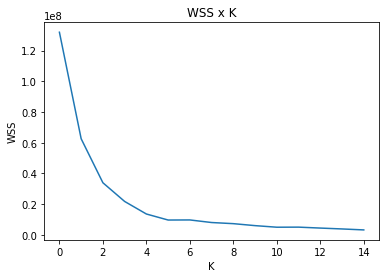

In [41]:
# Obtaining the best value of k
building_wss = calculate_WSS(df_building_num.values, 15)

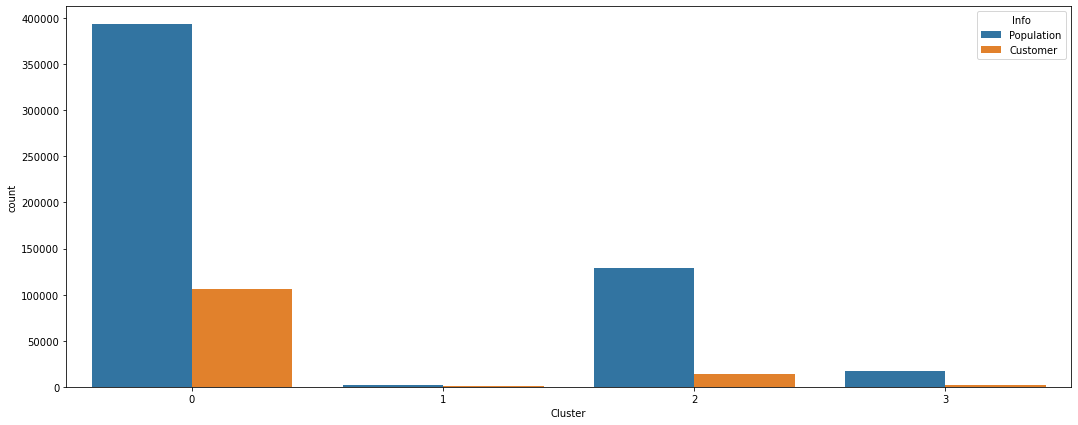

In [42]:
# Analysing the graphic above, the best value for k is 4
k_building = 4

# Using the KMeans algorithm
kmeans_building = KMeans(n_clusters = k_building, random_state=0).fit(df_building_num)

# Separating in clusters
building_cluster = kmeans_building.predict(df_building_num)

# Adding the cluster column to the dataframe
df_building_num['Cluster'] = building_cluster

# Adding the label (customer or azdias)
df_building_num['Info'] = origin_label

# Creating the graph of the cluster distribuition
fig, ax = plt.subplots(figsize = [18, 7])
ax = sns.countplot(data = df_building_num, x = 'Cluster', hue = 'Info')

**Analysis**

- For this group of information, there were no good clusters to be used for an analysis.

### Microcell (RR4_ID) information analysis

In [43]:
# Obtaining the columns in the Person Information Level
rr4_cols = df_columns[df_columns['Information_level'] == 'Microcell (RR4_ID)']
rr4_cols_list = list(rr4_cols['columns_to_use'].values)
rr4_cols_list.append('Dataframe')

# Creating the dataframe
df_rr4 = data[rr4_cols_list]

df_rr4_num, origin_label = numeric_df(df_rr4)

print('Shape of the data: ', df_rr4.shape)

Number of numeric columns:  0
Shape of the data:  (664127, 3)


**Since this information group don't have any numeric values, they will be discarted**

### Microcell (RR3_ID) information analysis

In [44]:
# Obtaining the columns in the Person Information Level
rr3_cols = df_columns[df_columns['Information_level'] == 'Microcell (RR3_ID)']
rr3_cols_list = list(rr3_cols['columns_to_use'].values)
rr3_cols_list.append('Dataframe')

# Creating the dataframe
df_rr3 = data[rr3_cols_list]

df_rr3_num, origin_label = numeric_df(df_rr3)

print('Shape of the data: ', df_rr3.shape)

Number of numeric columns:  63
Shape of the data:  (664127, 64)


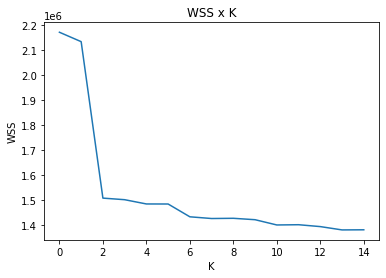

In [45]:
# Obtaining the best value of k
rr3_wss = calculate_WSS(df_rr3_num.values, 15)

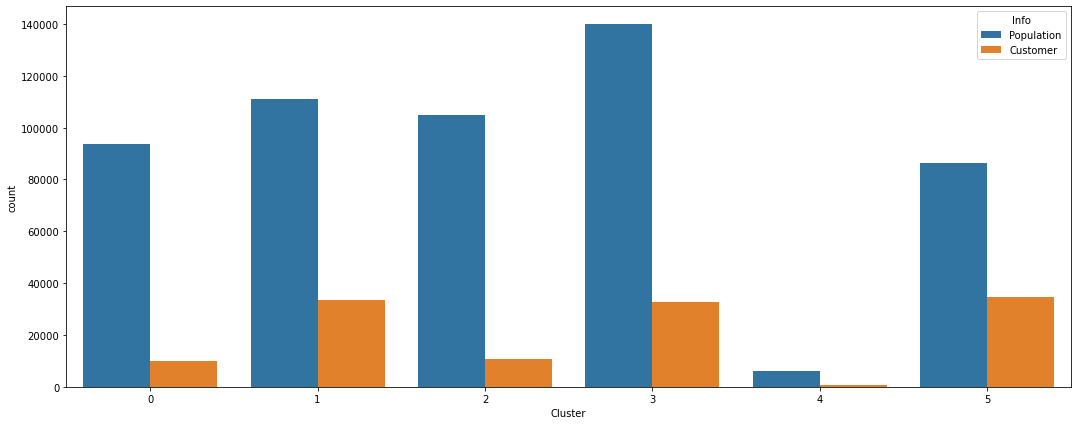

In [46]:
# Analysing the graphic above, the best value for k is 6
k_rr3 = 6

# Using the KMeans algorithm
kmeans_rr3 = KMeans(n_clusters = k_rr3, random_state=0).fit(df_rr3_num)

# Separating in clusters
rr3_cluster = kmeans_rr3.predict(df_rr3_num)

# Adding the cluster column to the dataframe
df_rr3_num['Cluster'] = rr3_cluster

# Adding the label (customer or azdias)
df_rr3_num['Info'] = origin_label

# Creating the graph of the cluster distribuition
fig, ax = plt.subplots(figsize = [18, 7])
ax = sns.countplot(data = df_rr3_num, x = 'Cluster', hue = 'Info')

**Analysis**

- For this group of information, the, clusters 5, 1 and 3 will be used to make an analysis.

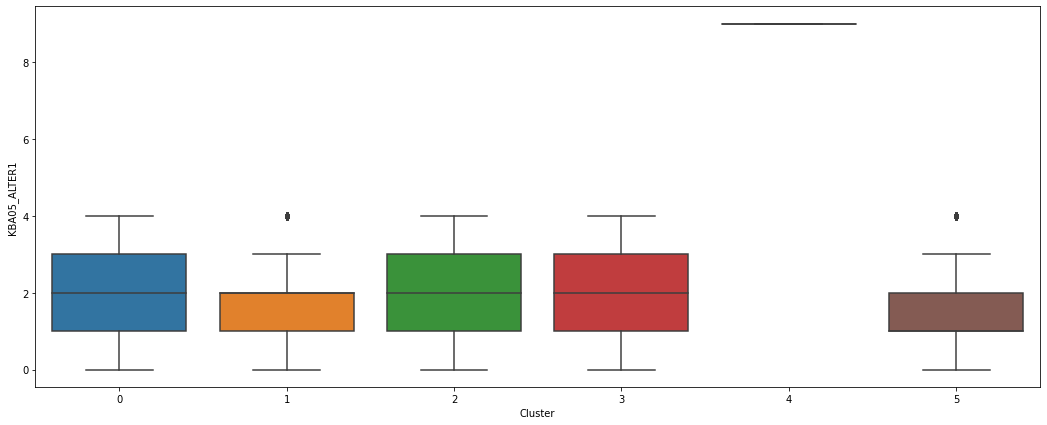

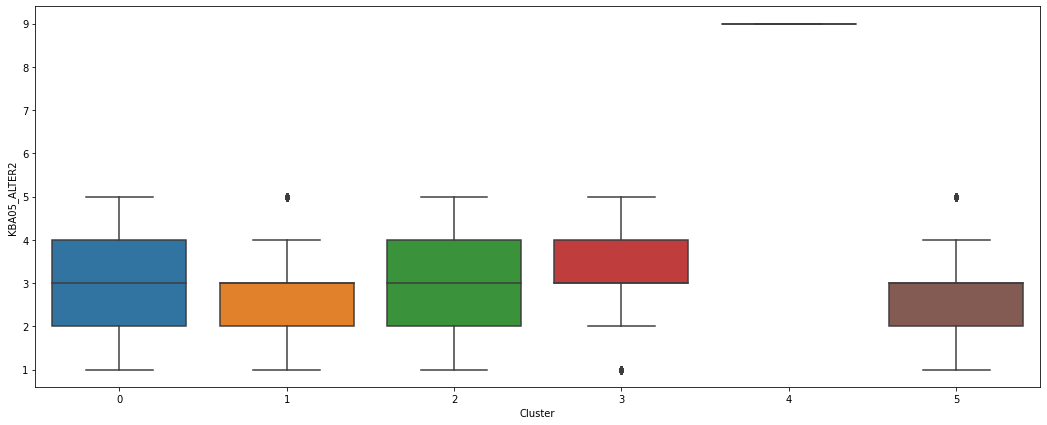

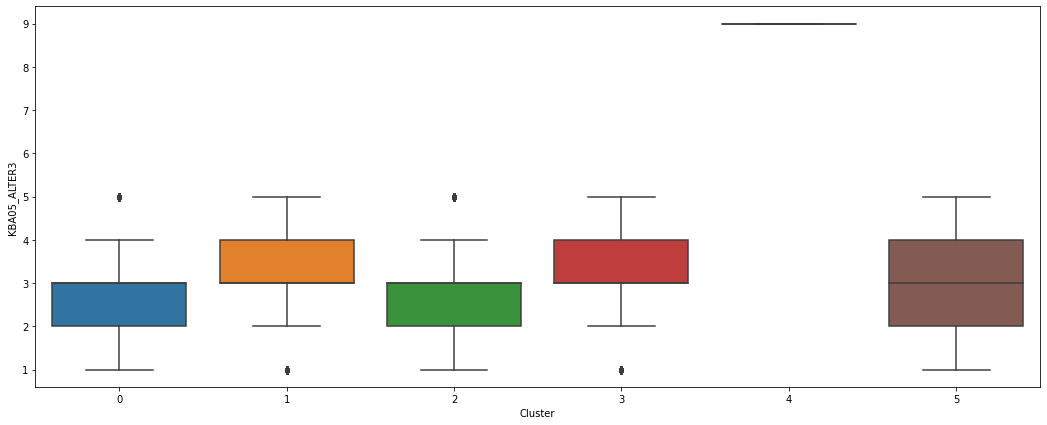

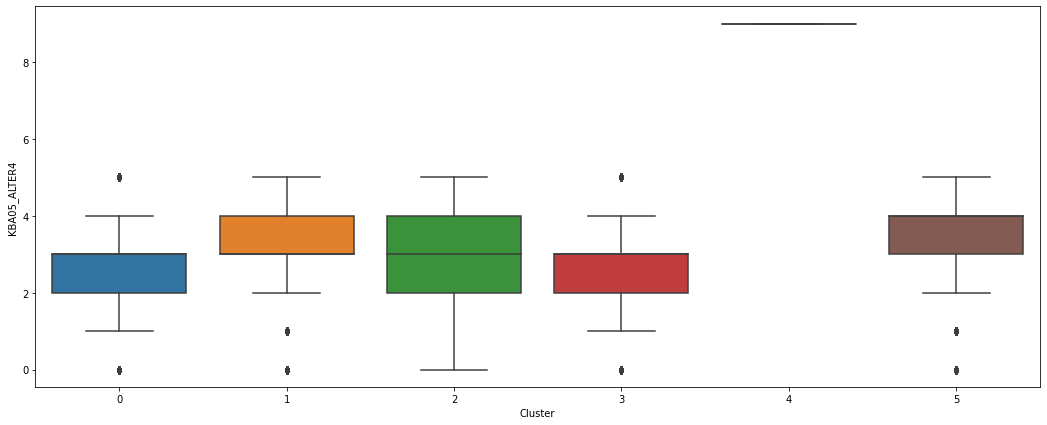

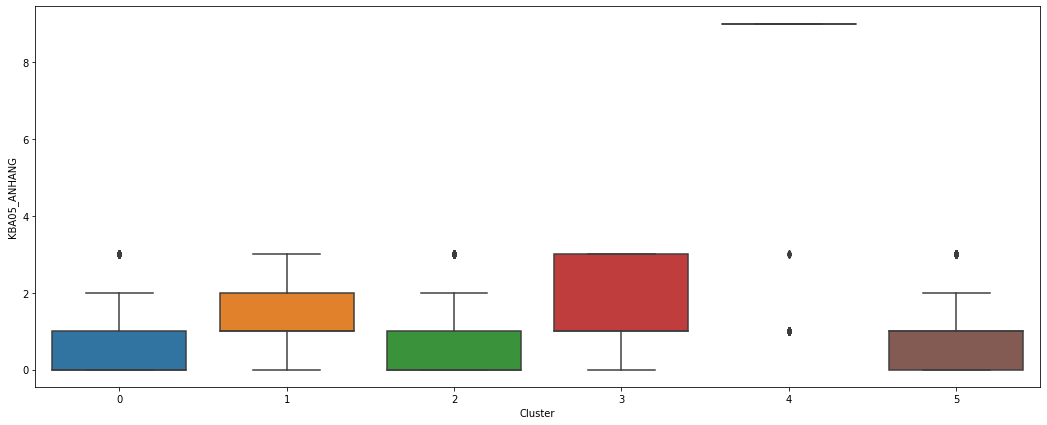

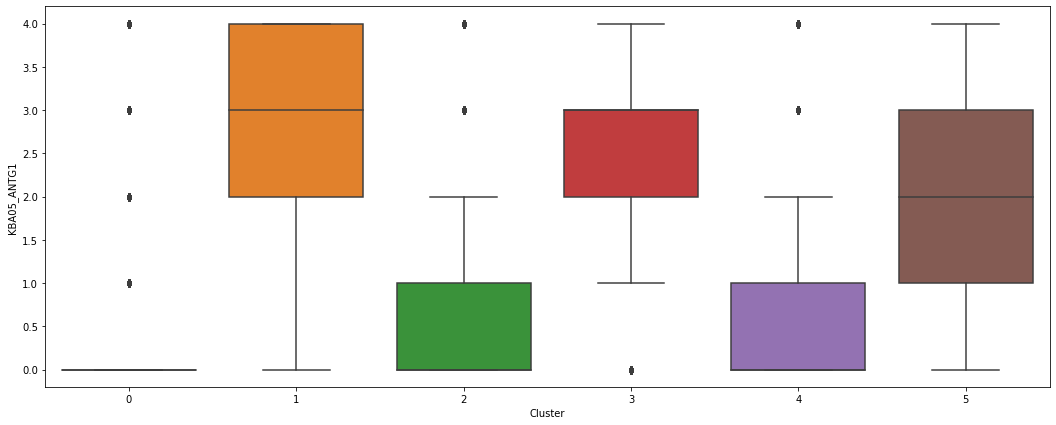

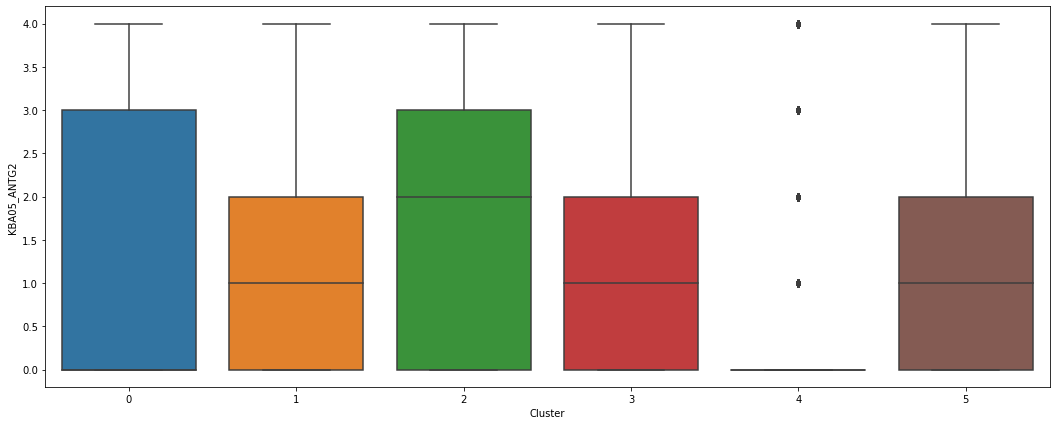

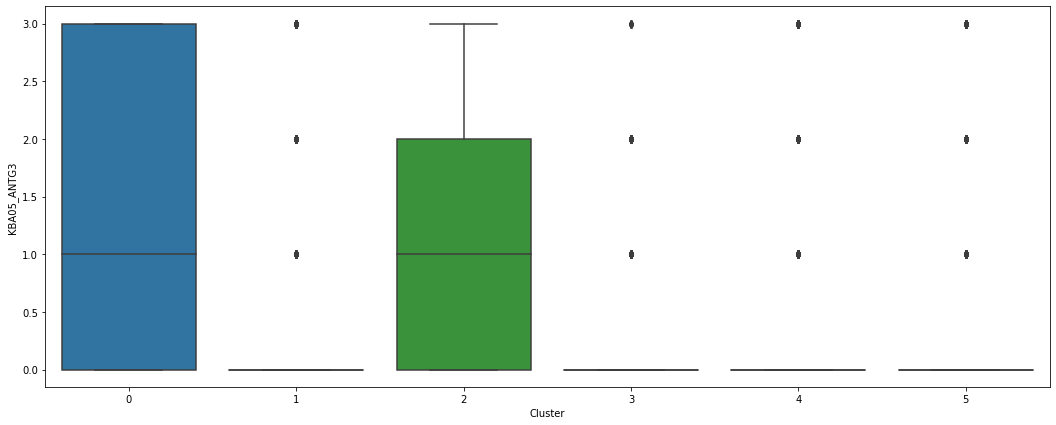

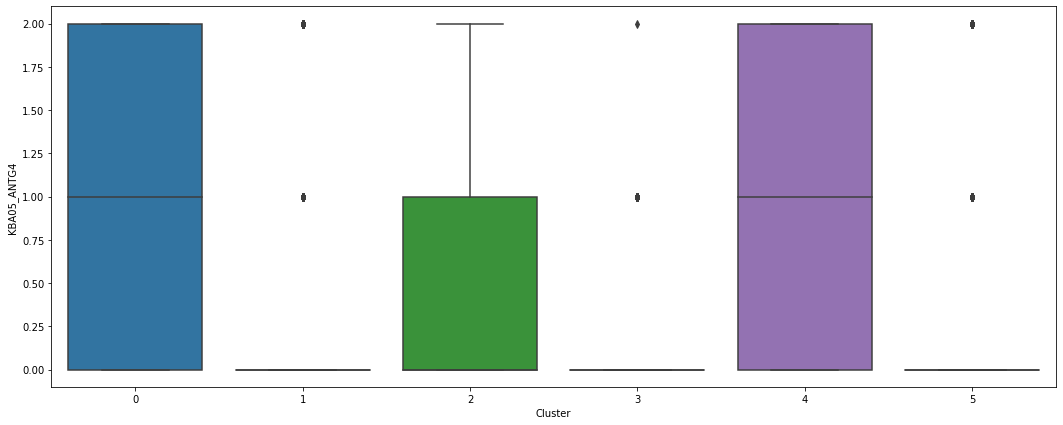

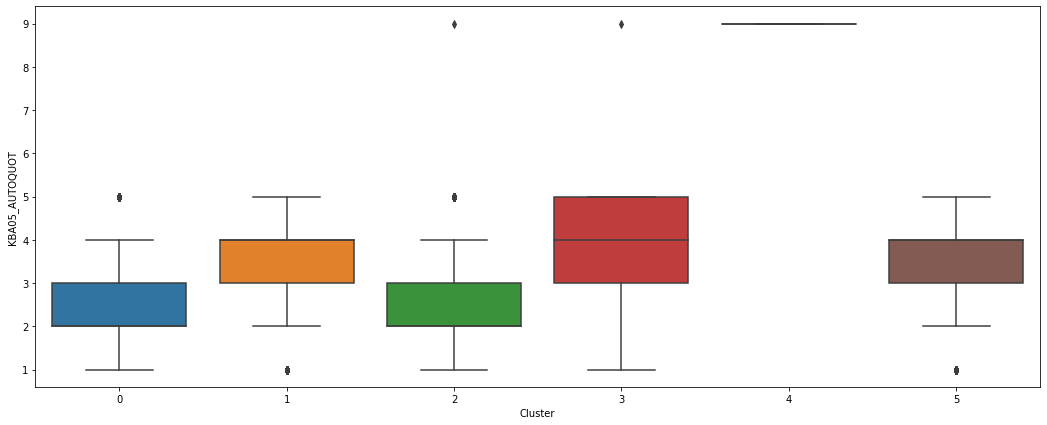

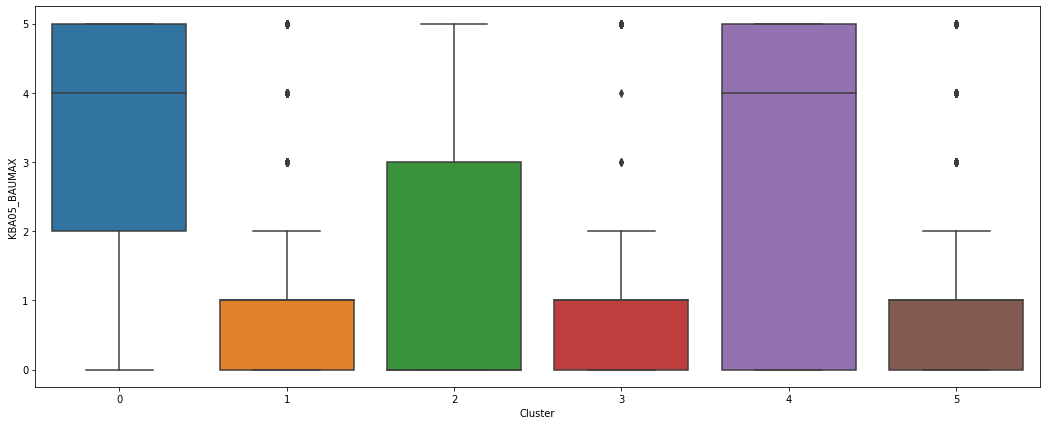

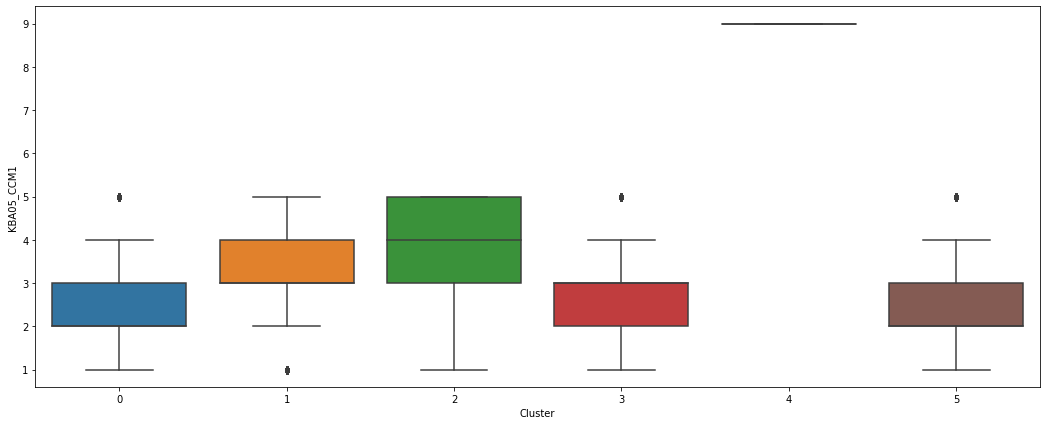

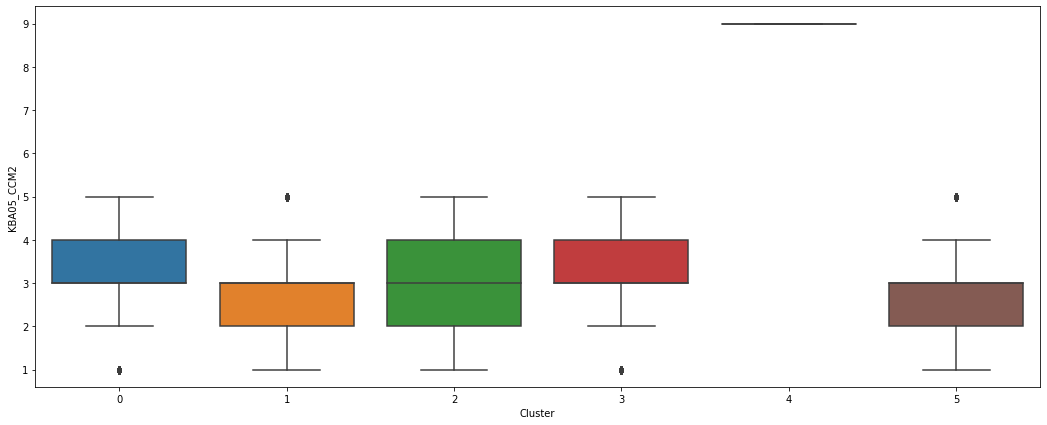

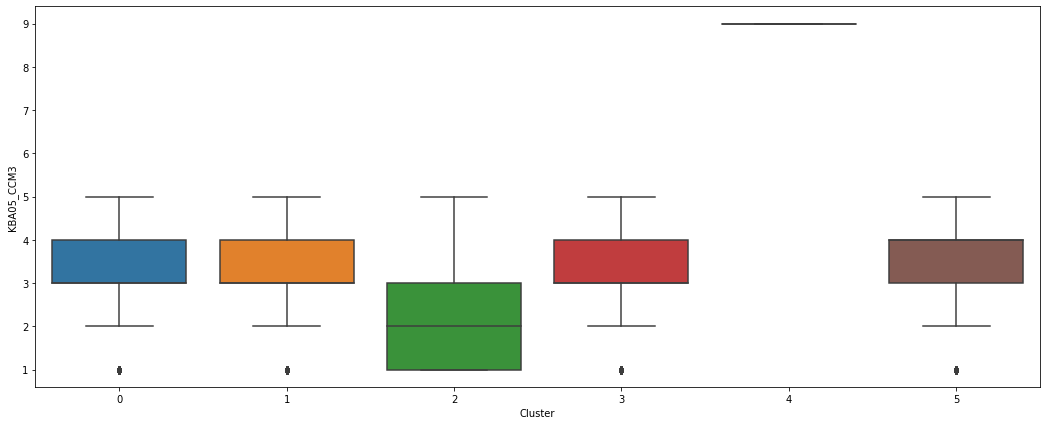

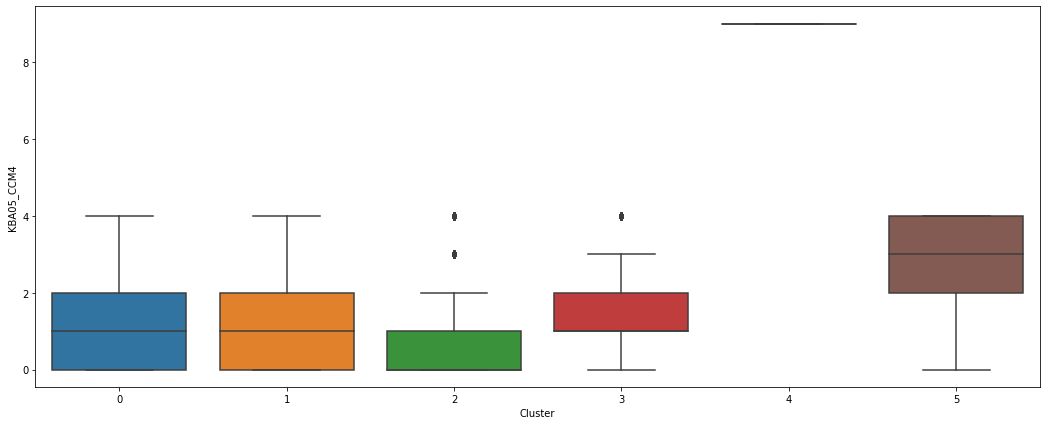

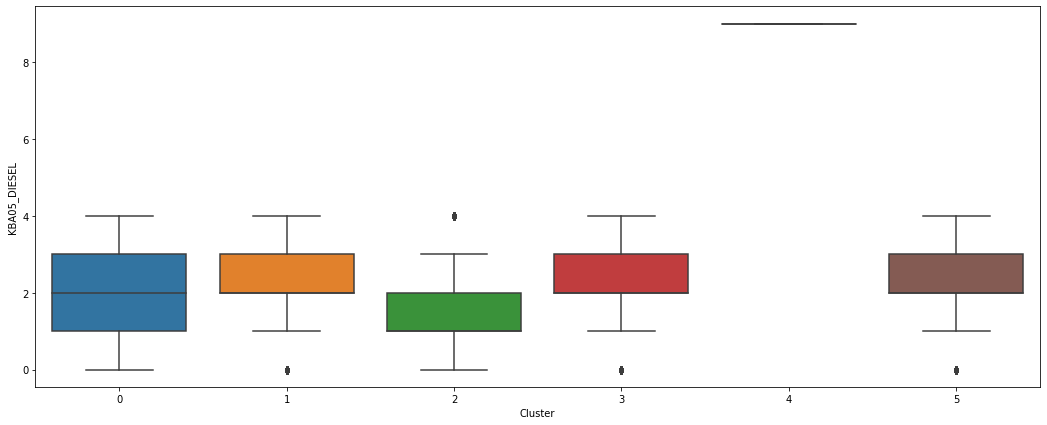

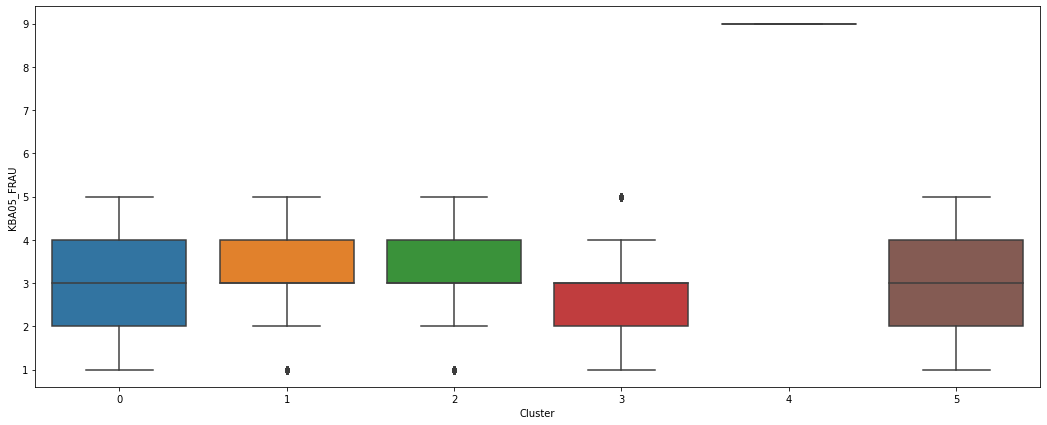

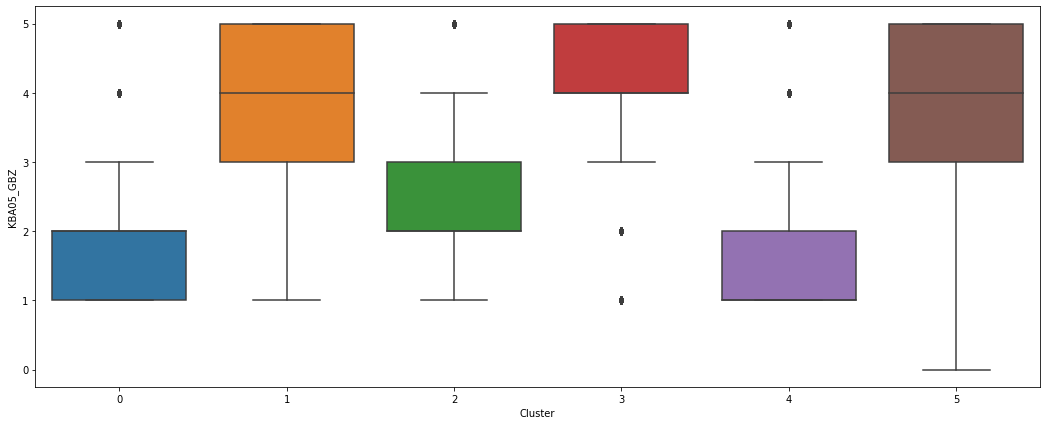

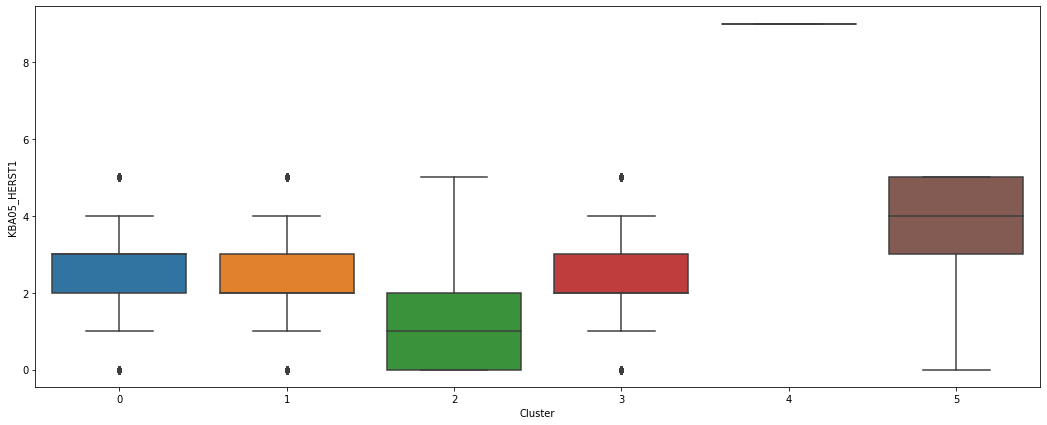

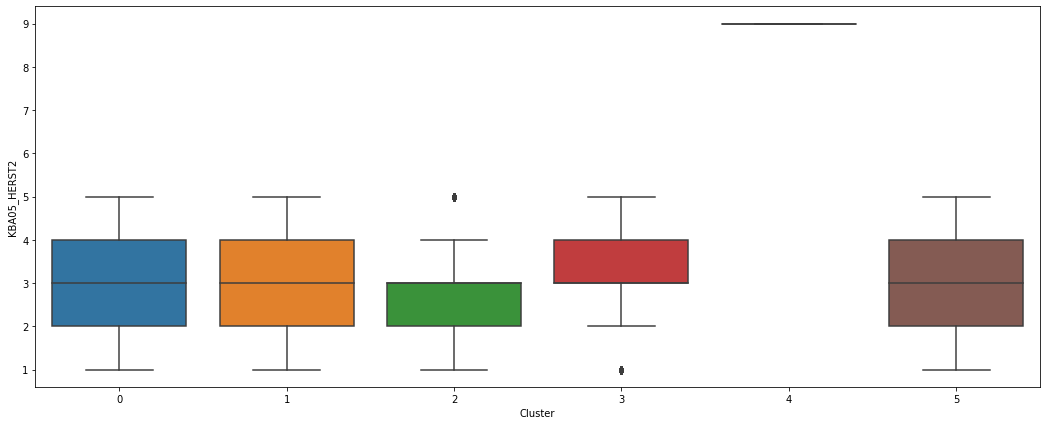

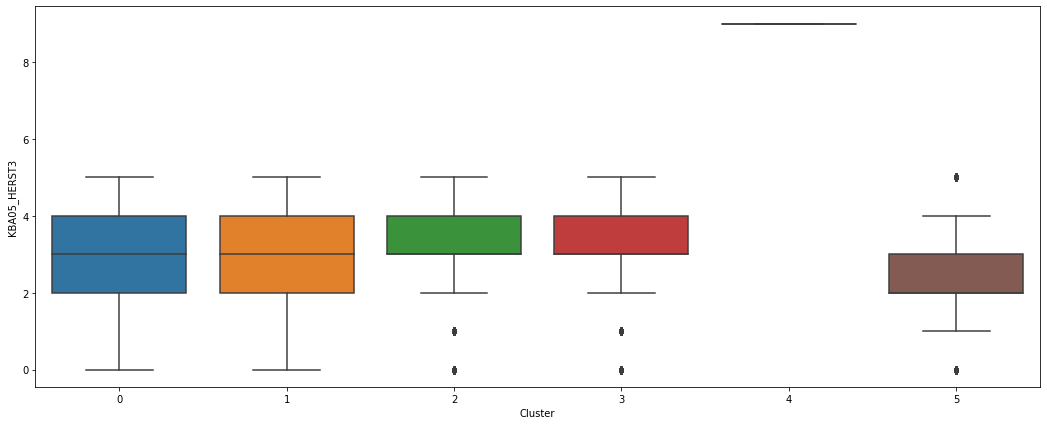

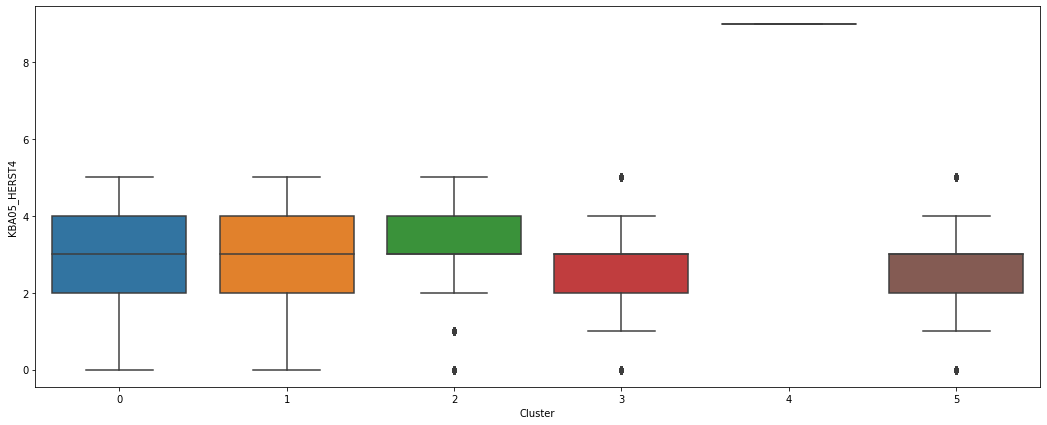

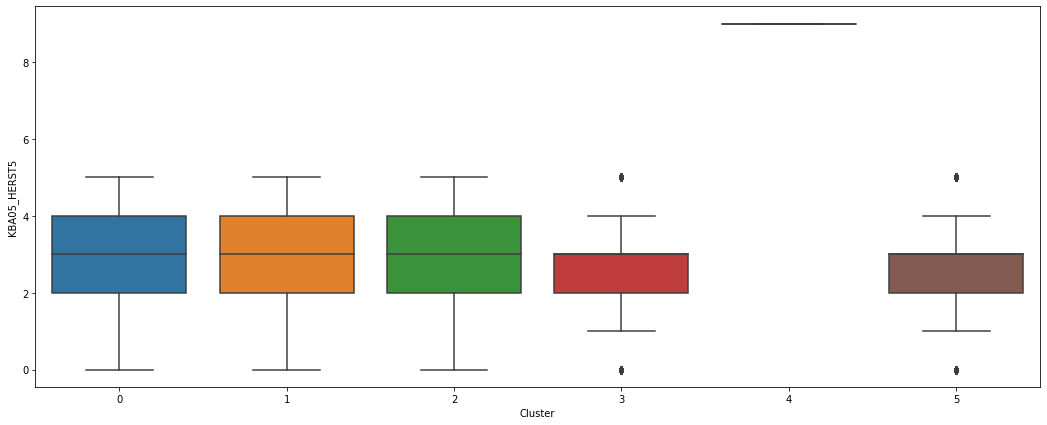

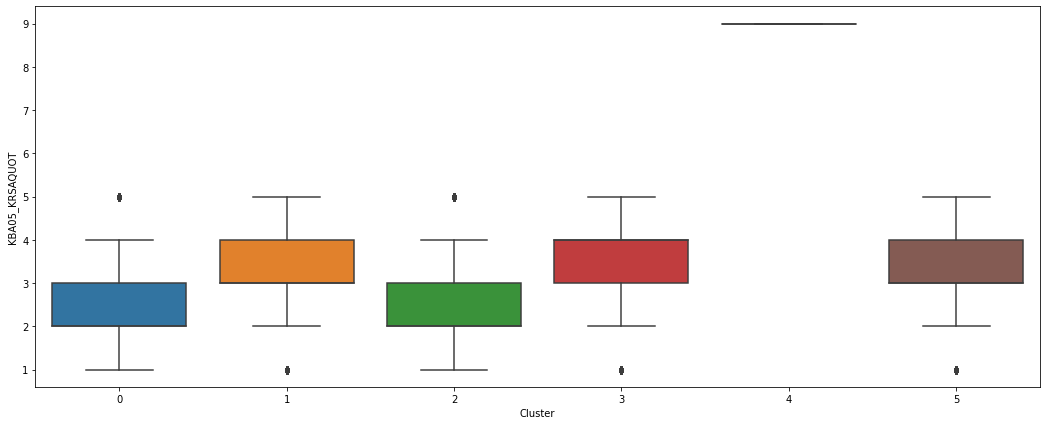

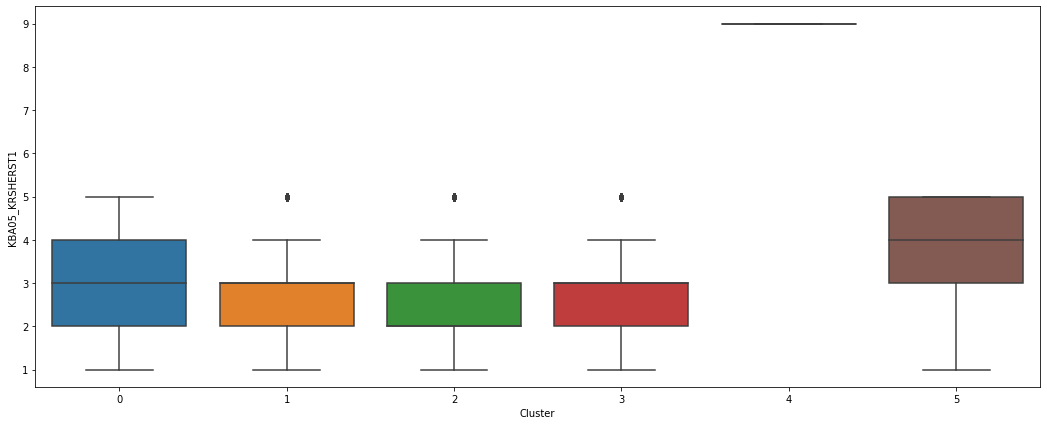

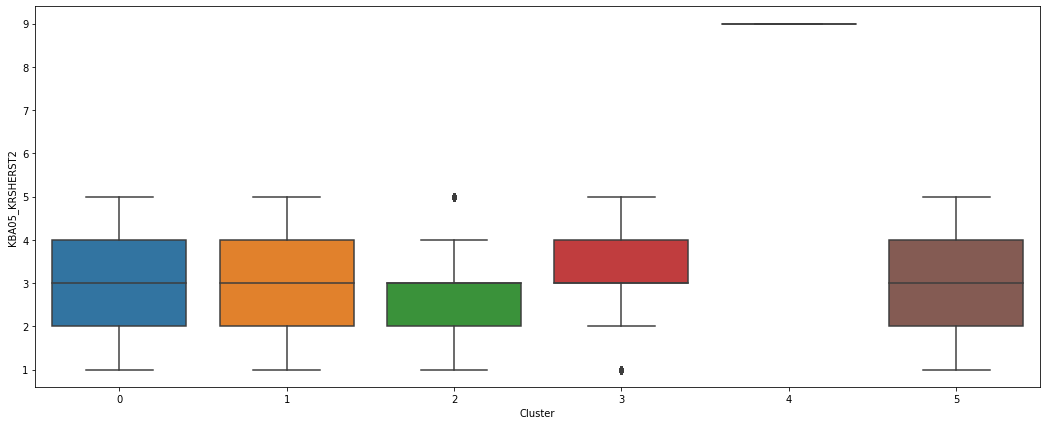

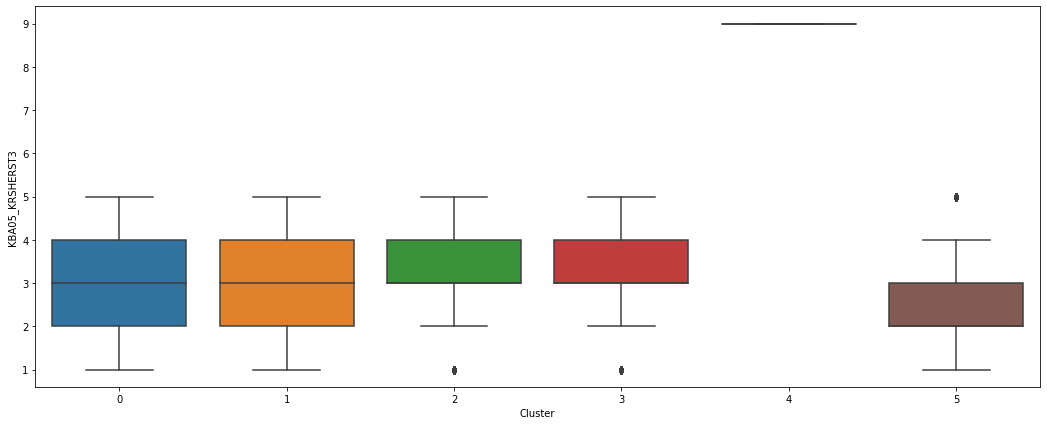

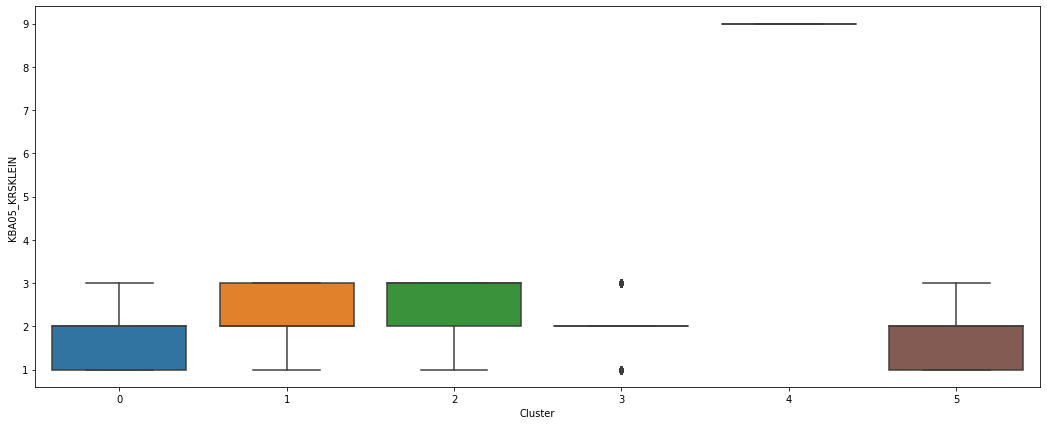

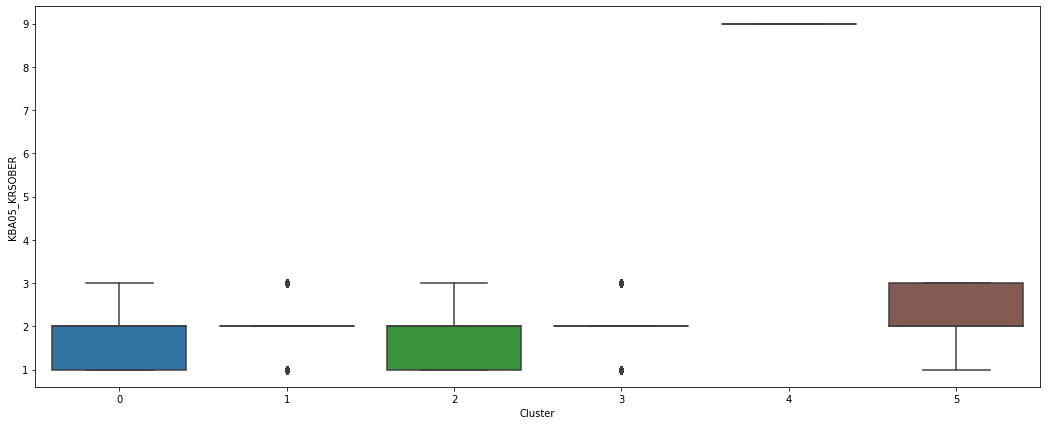

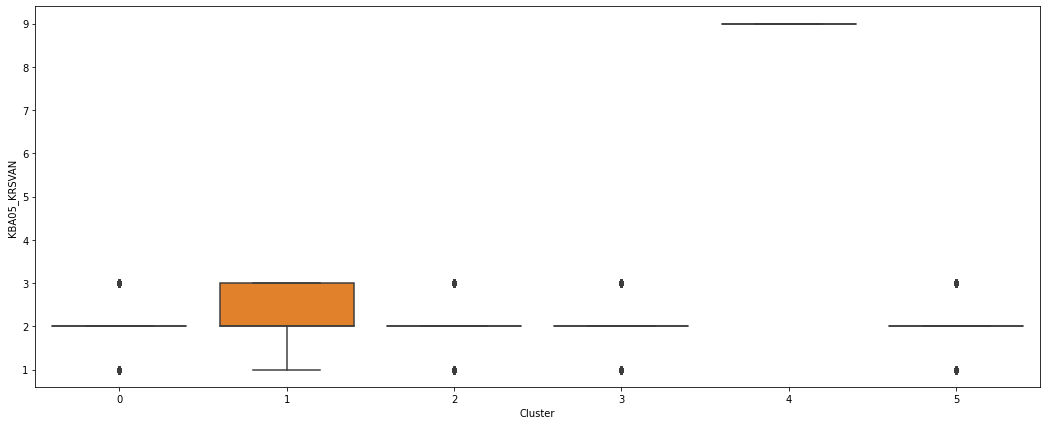

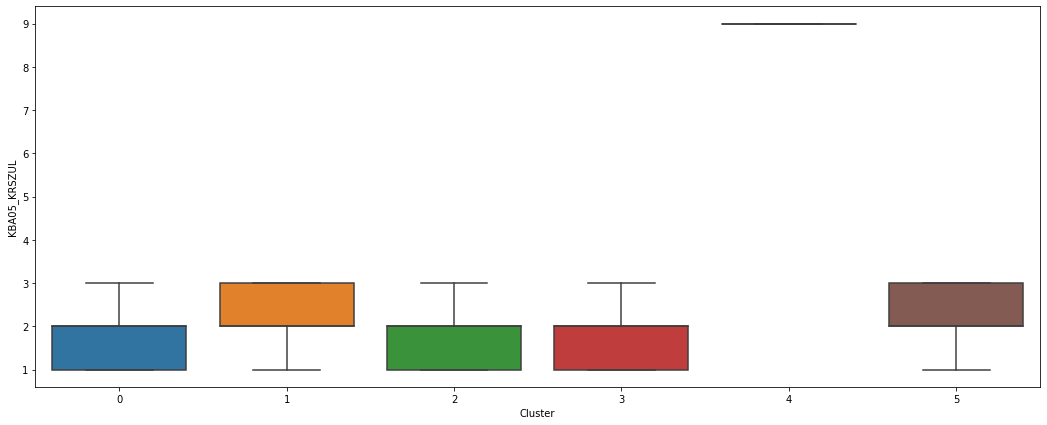

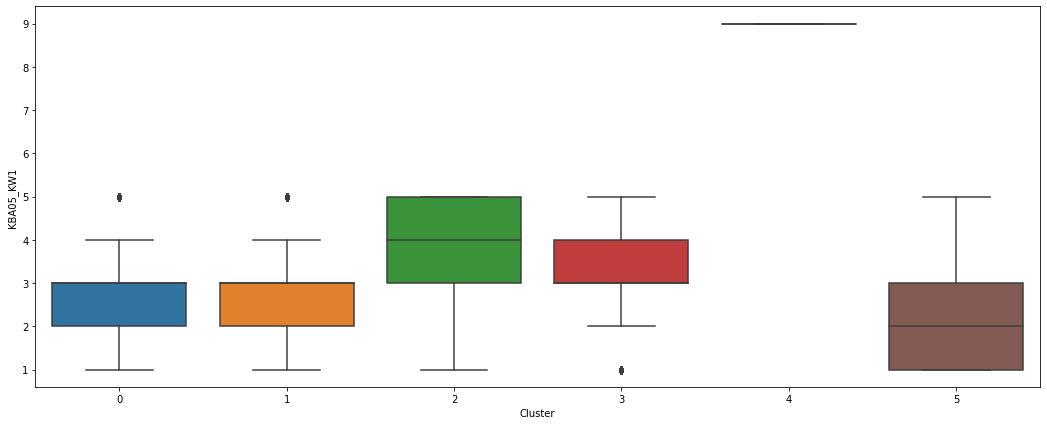

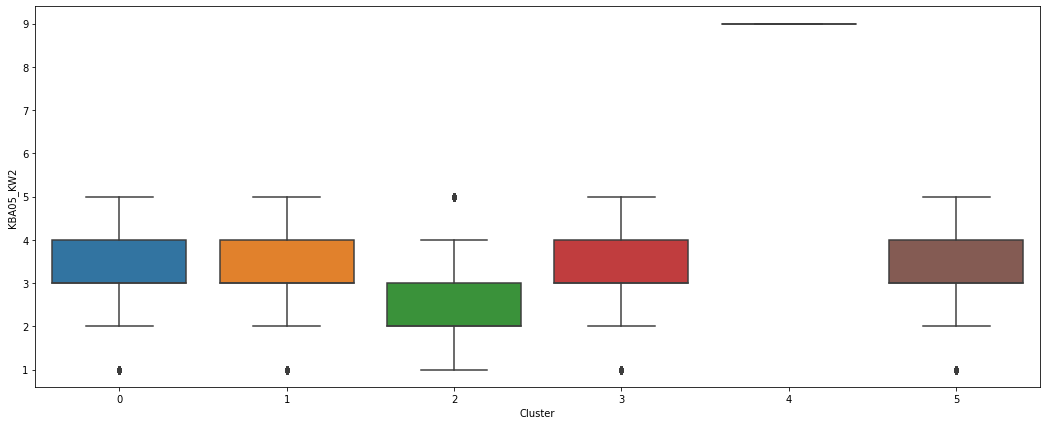

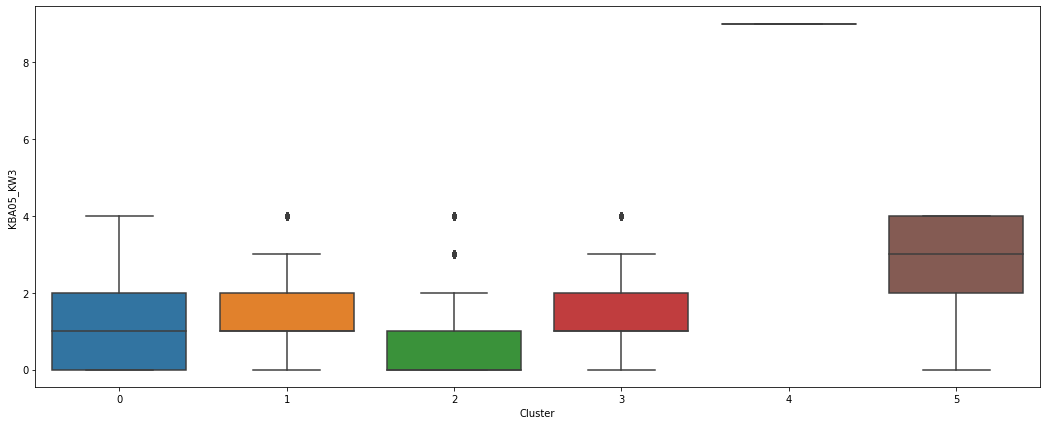

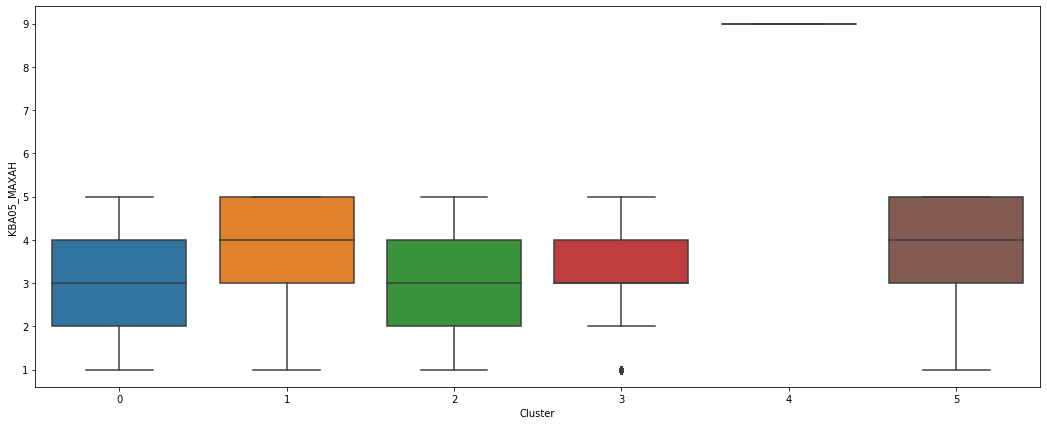

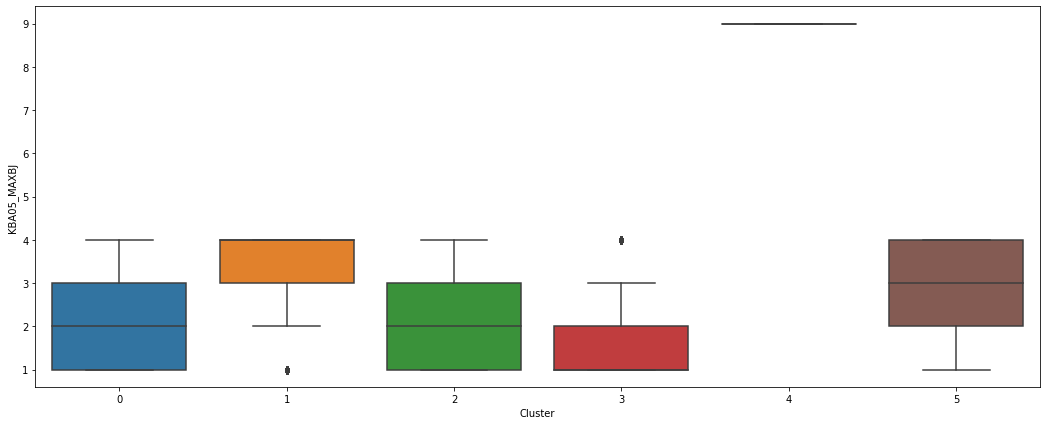

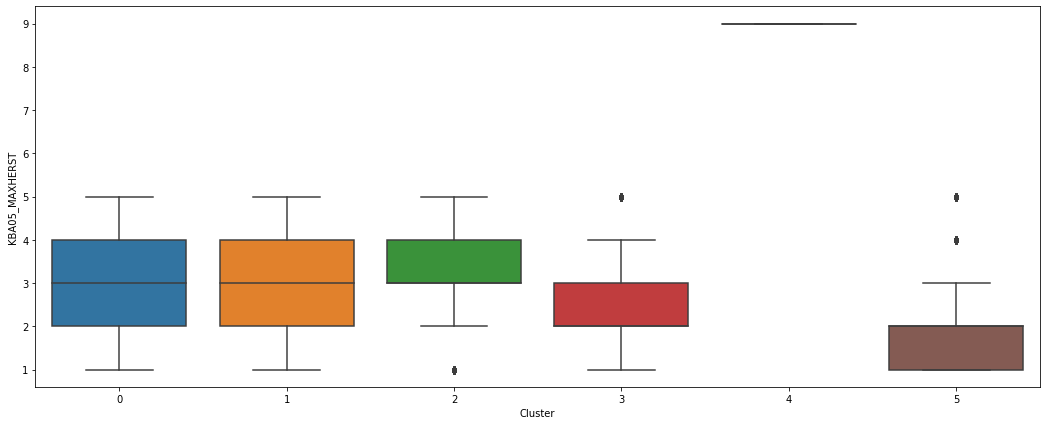

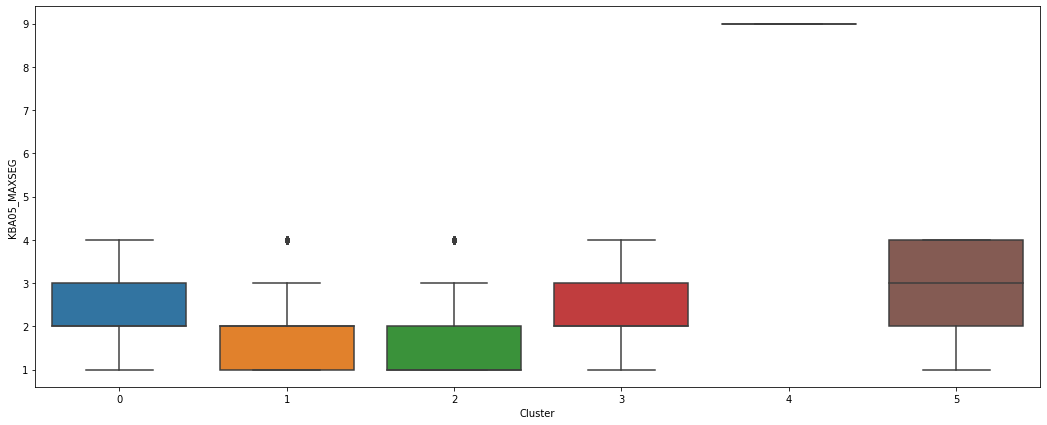

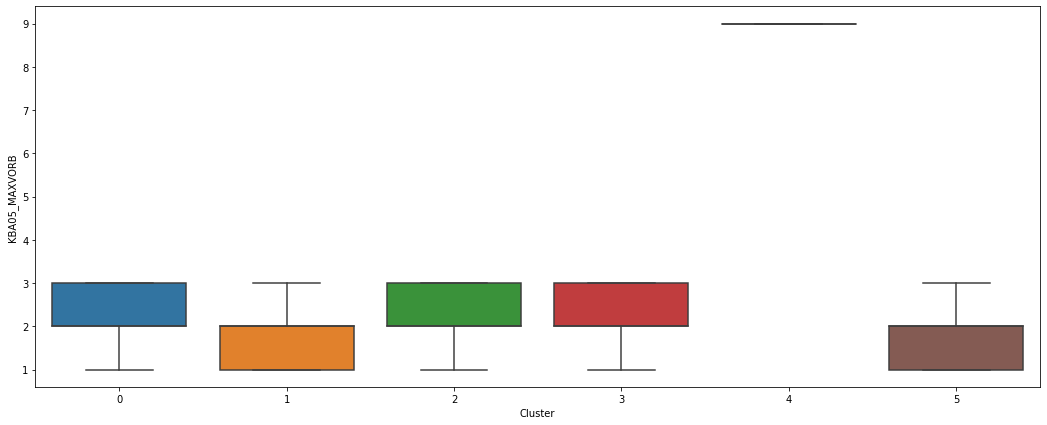

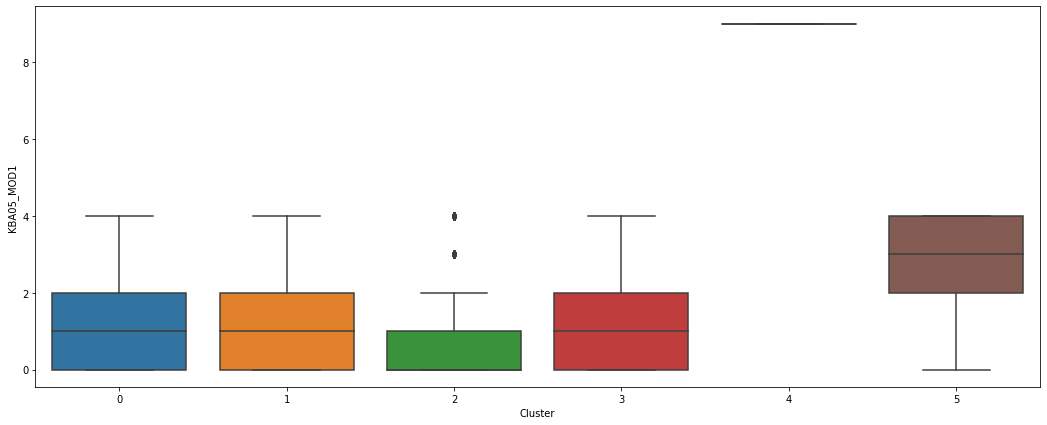

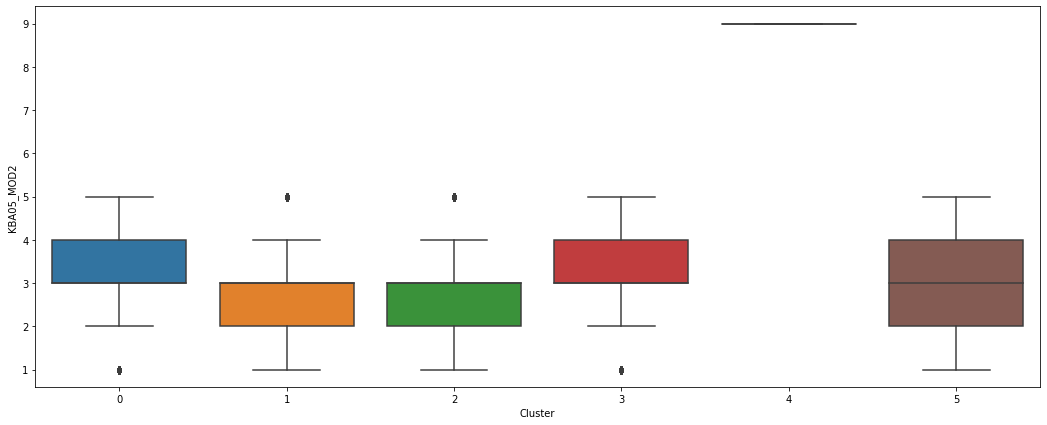

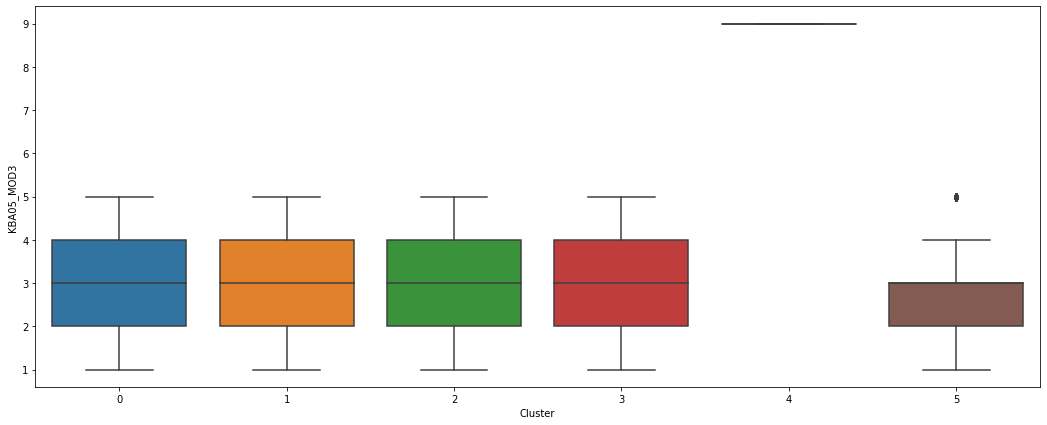

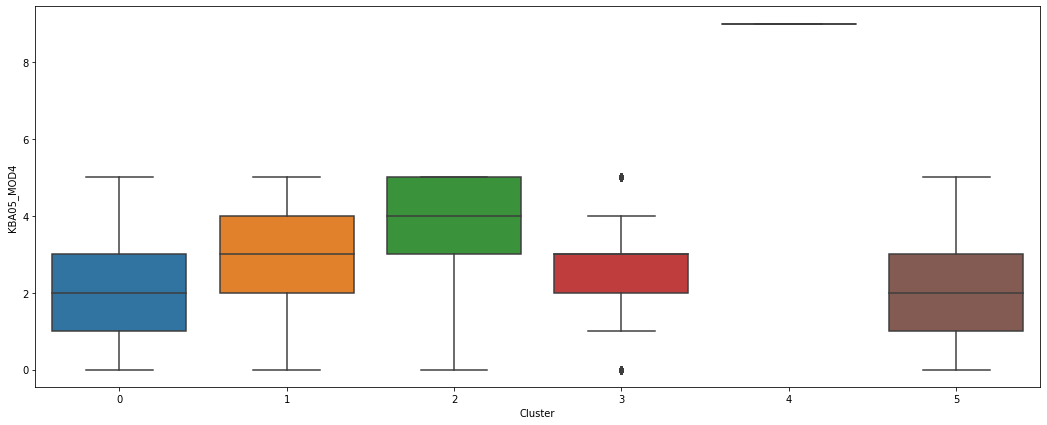

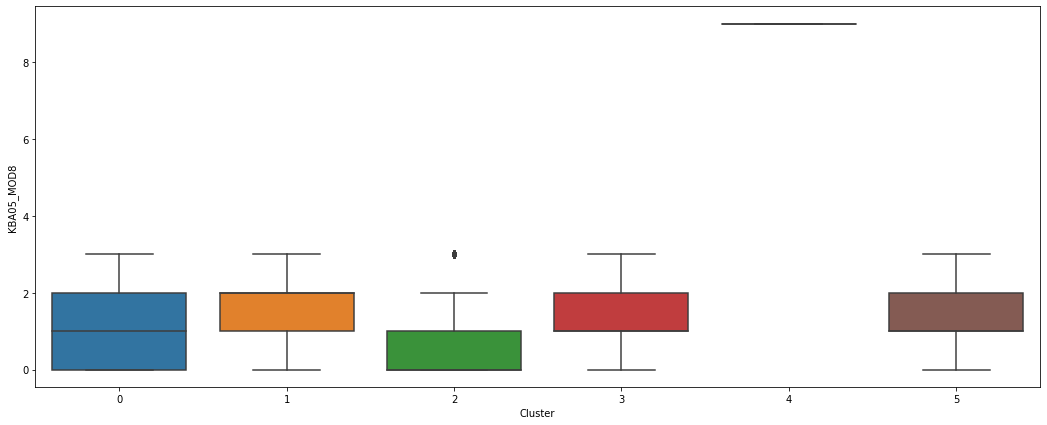

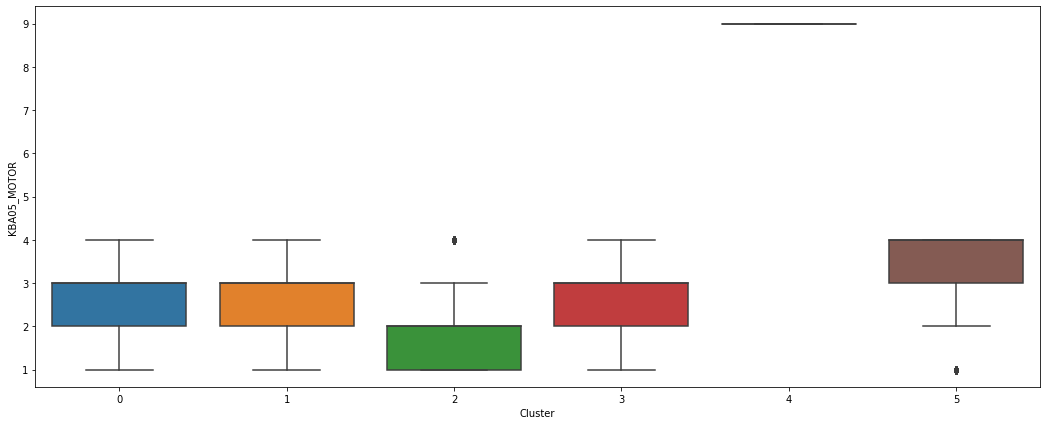

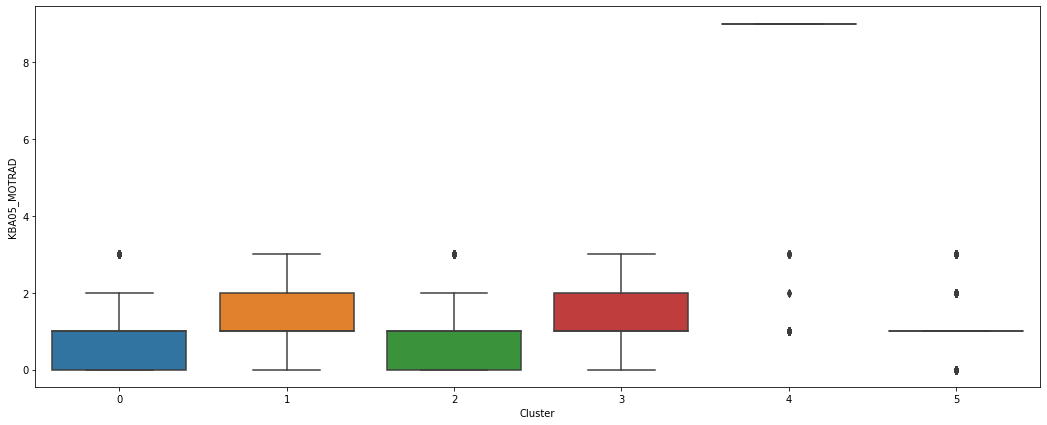

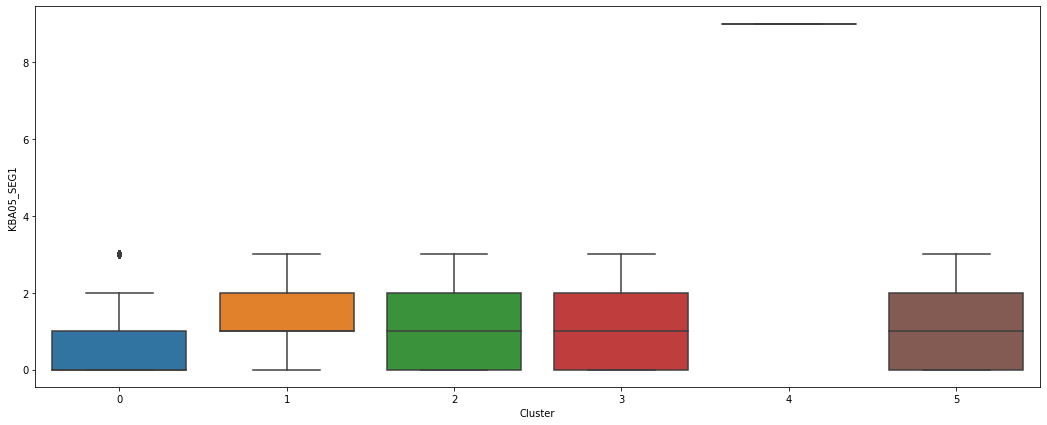

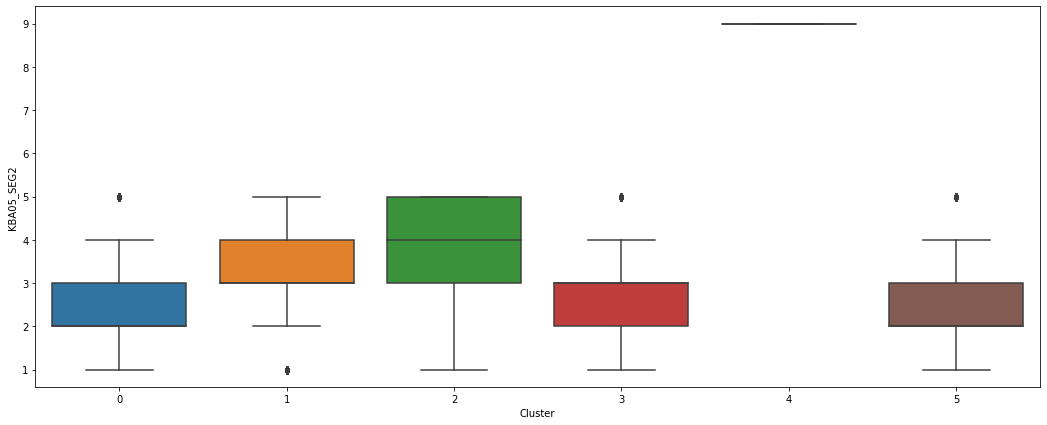

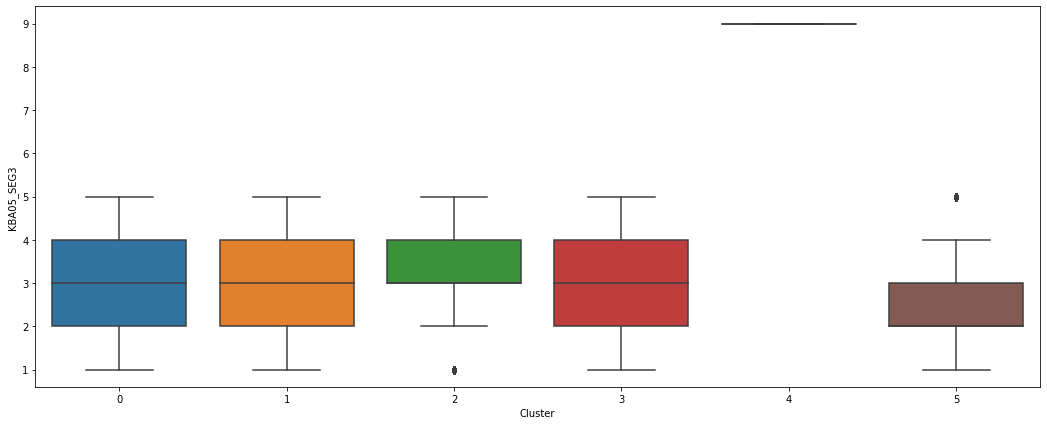

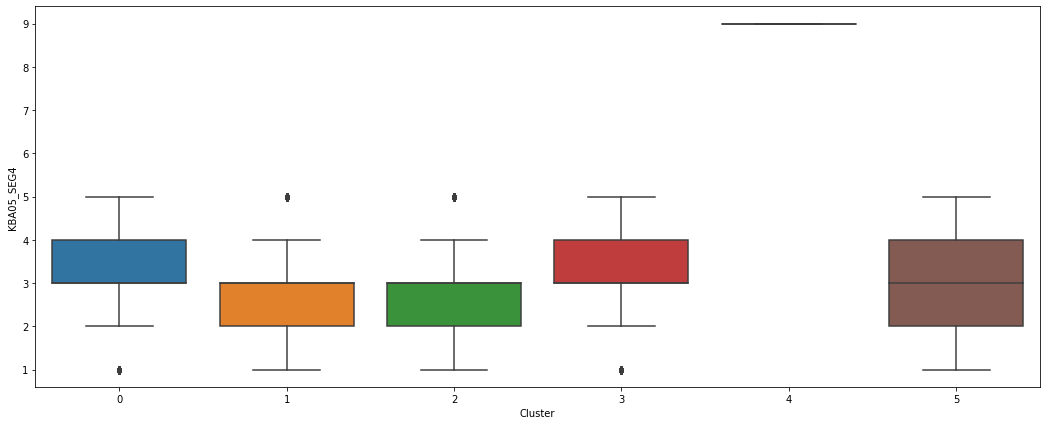

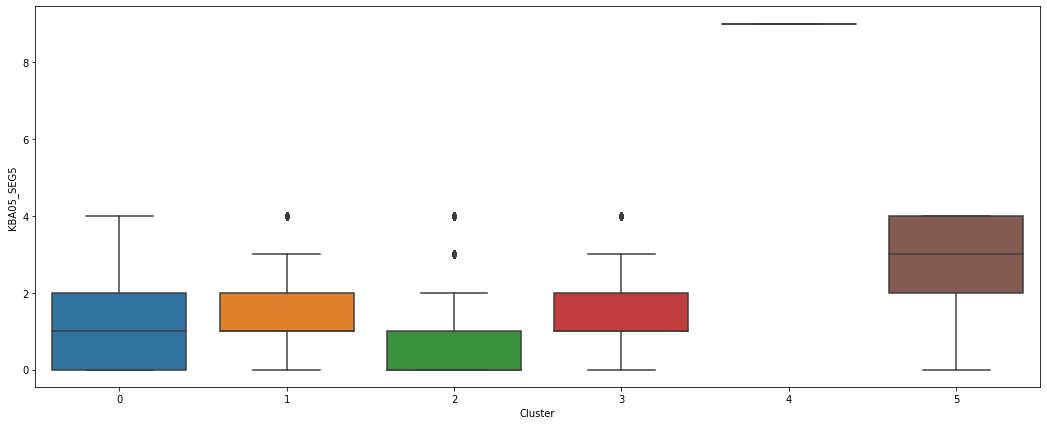

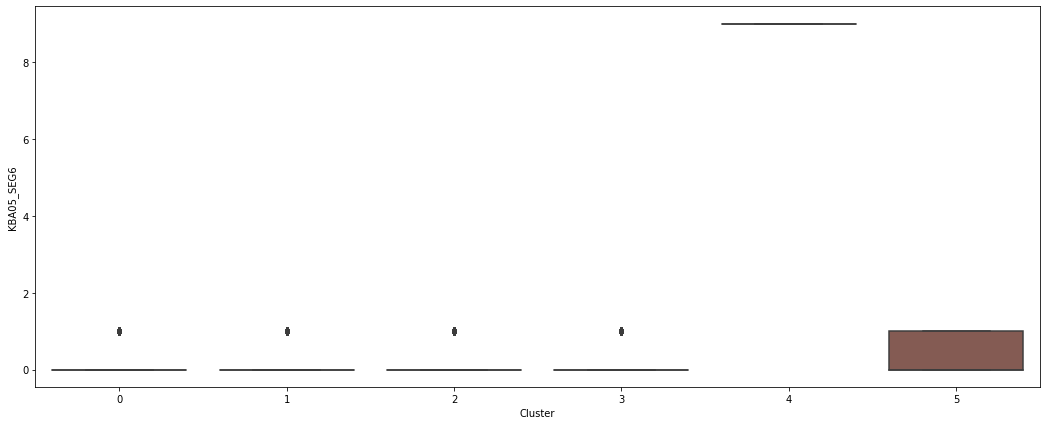

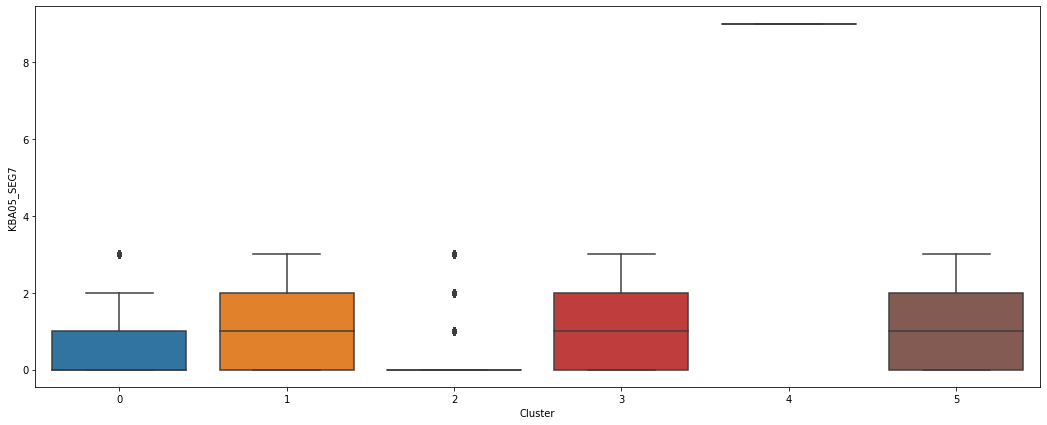

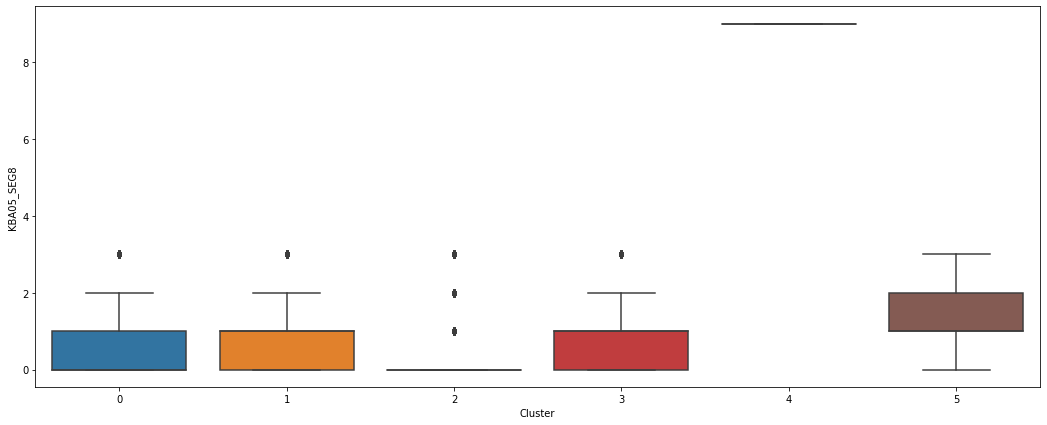

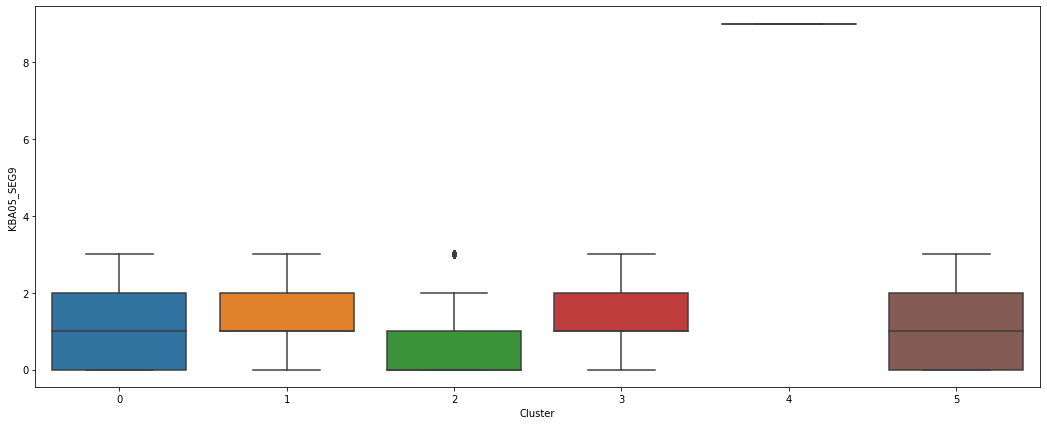

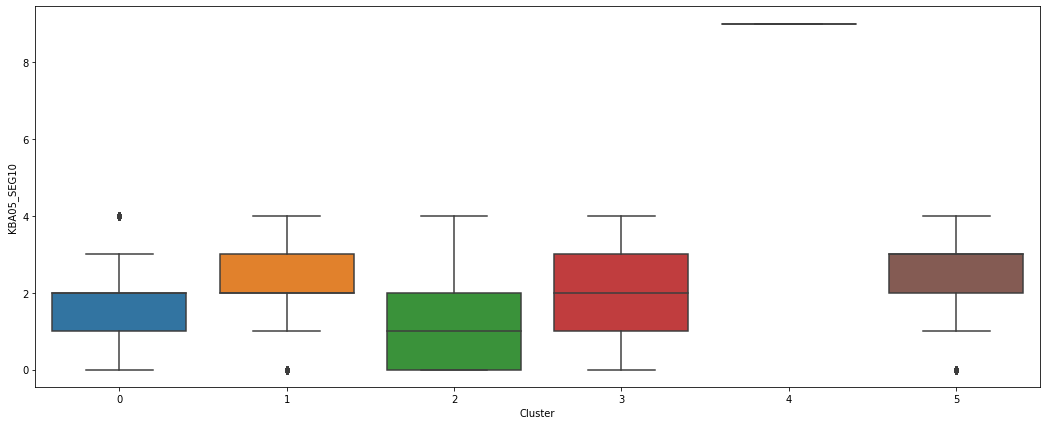

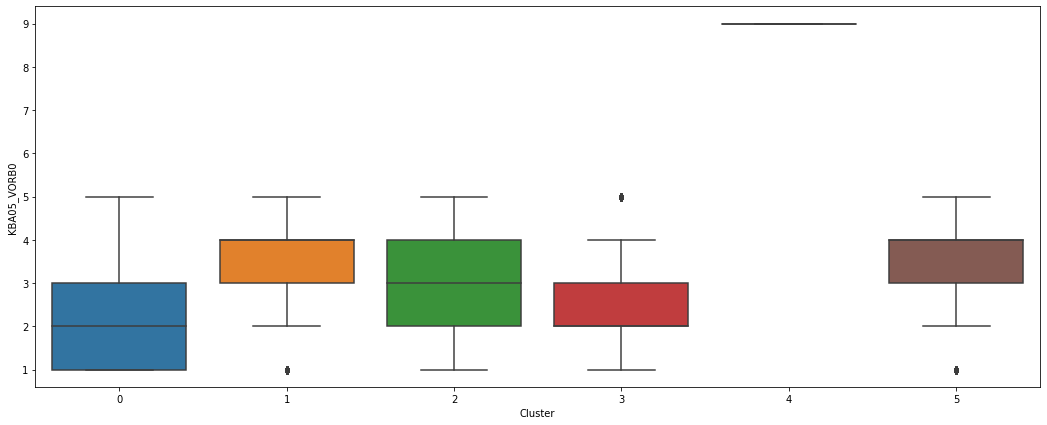

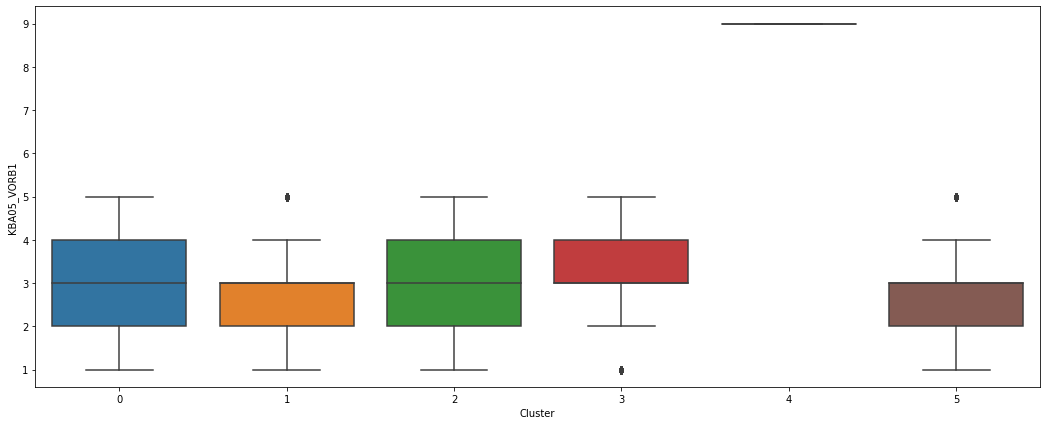

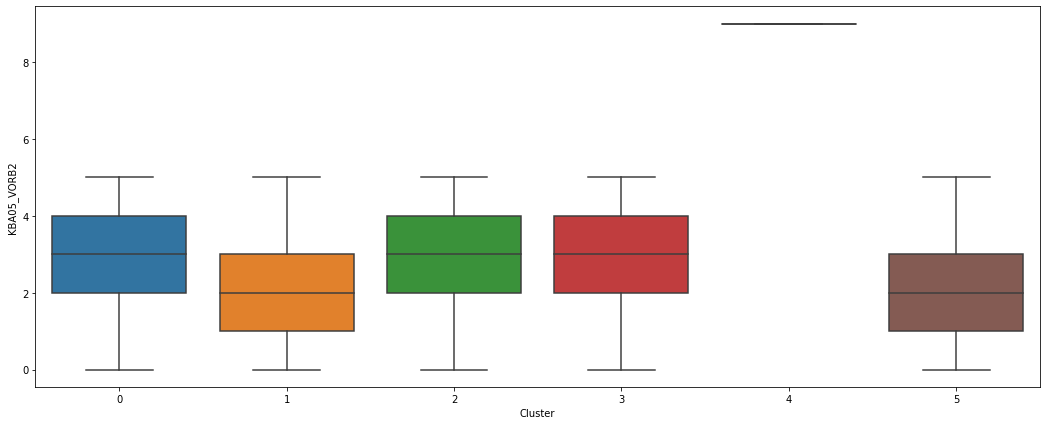

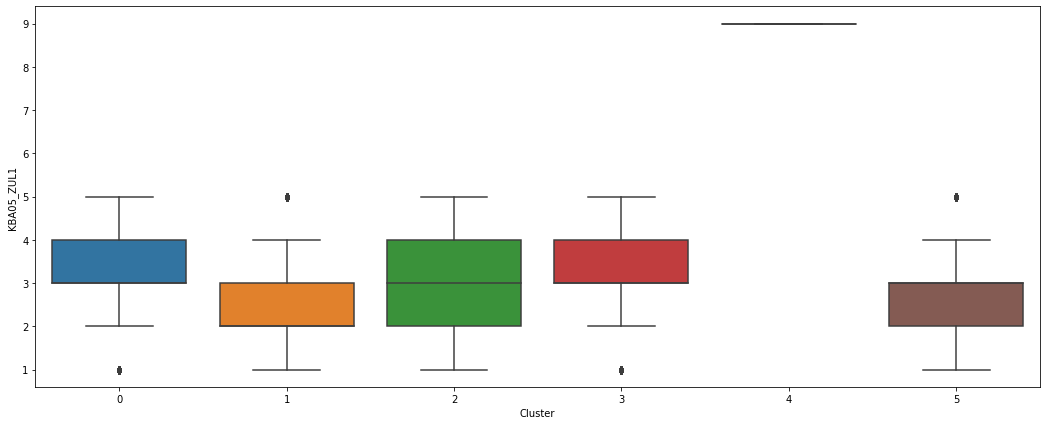

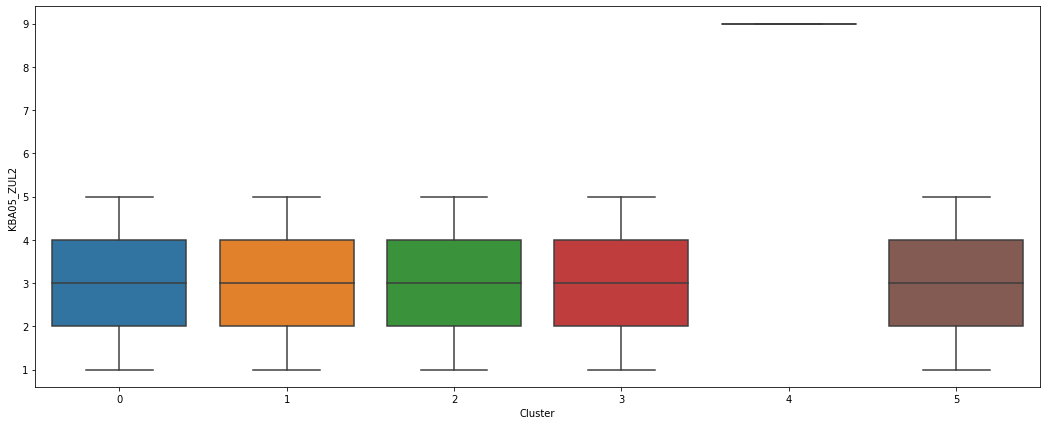

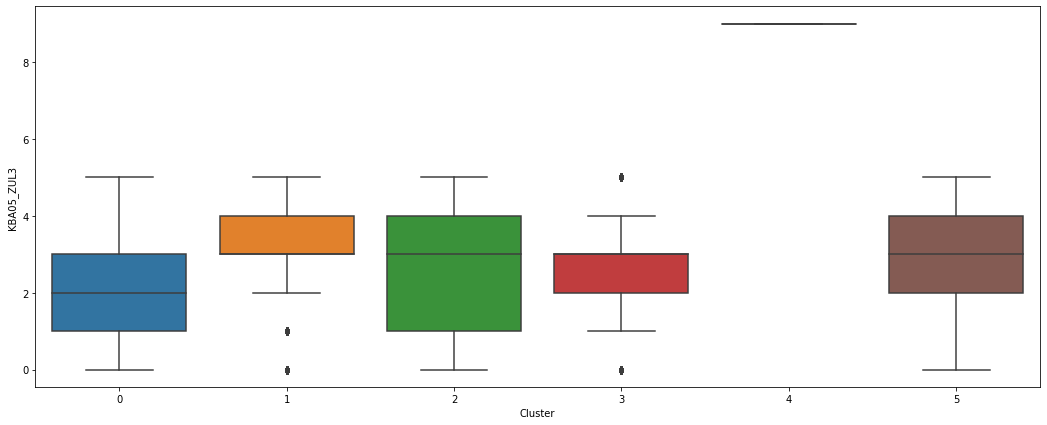

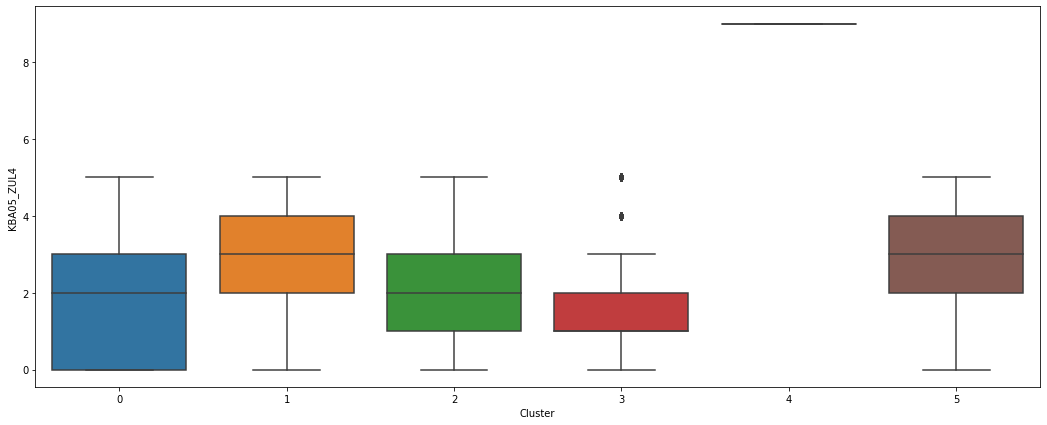

In [47]:
for col in rr3_cols_list:
    if col == 'Dataframe':
        pass
    else:
        fig, ax = plt.subplots(figsize = [18, 7])
        ax = sns.boxplot(data = df_rr3_num, x = 'Cluster', y = col
                        )

In [48]:
rr3_chosen_feat = [
    'KBA05_CCM4',
    'KBA05_FRAU',
    'KBA05_HERST1',
    'KBA05_KRSHERST1',
    'KBA05_KRSKLEIN',
    'KBA05_KRSOBER',
    'KBA05_KW1',
    'KBA05_KW3',
    'KBA05_MAXHERST',
    'KBA05_MOD1',
    'KBA05_MOTOR',
    'KBA05_SEG2',
    'KBA05_SEG5',
    'KBA05_SEG6',
    'KBA05_SEG8',
]

print(f'Reduced the number of features from {len(rr3_cols)} to {len(rr3_chosen_feat)}')

Reduced the number of features from 63 to 15


**Conclusion:**

Looking at the graphs, the portion of the german population that most resembles the clients tend to:
- have a higher share of cars with more than 2499ccm;
- have a lower share of female car owners;
- have a higher share of top German manufacturer (Mercedes, BMW);
- have a lower share of small cars (referred to the county average)
- have a higher share of share of upper class cars (referred to the county average);
- have a lower share of cars with less than 59 KW engine power;
- have a higher share of cars with an engine power of more than 119 KW;
- have as the most common car manufacturer in the microcell: Top-German or VW-Audi;
- have a higher share of upper class cars (in an AZ specific definition);
- have biggers sized engines in the microcell;
- have a lower share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the microcell;
- have a higher share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.);
- have a higher share of upper class cars (BMW 7er etc.) in the microcell;
- have a higher share of roadster and convertables in the microcell;

### Postcode information analysis

In [49]:
# Obtaining the columns in the Person Information Level
postcode_cols = df_columns[df_columns['Information_level'] == 'Postcode']
postcode_cols_list = list(postcode_cols['columns_to_use'].values)
postcode_cols_list.append('Dataframe')

# Creating the dataframe
df_postcode = data[postcode_cols_list]

df_postcode_num, origin_label = numeric_df(df_postcode)

print('Shape of the data: ', df_postcode.shape)

Number of numeric columns:  3
Shape of the data:  (664127, 4)


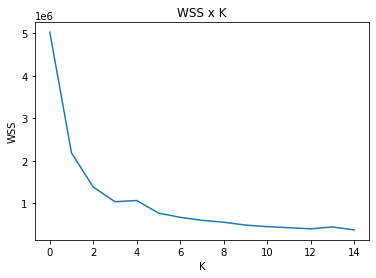

In [50]:
# Obtaining the best value of k
postcode_wss = calculate_WSS(df_postcode_num.values, 15)

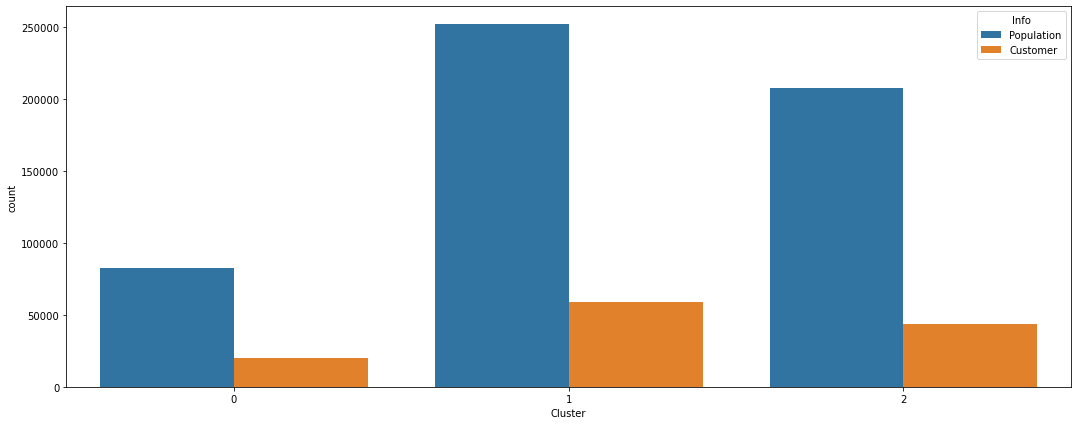

In [51]:
# Analysing the graphic above, the best value for k is 3
k_postcode = 3

# Using the KMeans algorithm
kmeans_postcode = KMeans(n_clusters = k_postcode, random_state=0).fit(df_postcode_num)

# Separating in clusters
postcode_cluster = kmeans_postcode.predict(df_postcode_num)

# Adding the cluster column to the dataframe
df_postcode_num['Cluster'] = postcode_cluster

# Adding the label (customer or azdias)
df_postcode_num['Info'] = origin_label

# Creating the graph of the cluster distribuition
fig, ax = plt.subplots(figsize = [18, 7])
ax = sns.countplot(data = df_postcode_num, x = 'Cluster', hue = 'Info')

**Analysis**

- For this group of information, there were no good clusters to be used for an analysis.

### RR1_ID information analysis

In [52]:
# Obtaining the columns in the Person Information Level
rr1_cols = df_columns[df_columns['Information_level'] == 'RR1_ID']
rr1_cols_list = list(rr1_cols['columns_to_use'].values)
rr1_cols_list.append('Dataframe')

# Creating the dataframe
df_rr1 = data[rr1_cols_list]

df_rr1_num, origin_label = numeric_df(df_rr1)

print('Shape of the data: ', df_rr1.shape)

Number of numeric columns:  5
Shape of the data:  (664127, 6)


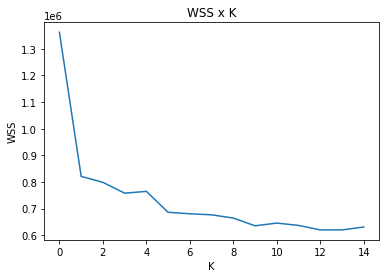

In [53]:
# Obtaining the best value of k
rr1_wss = calculate_WSS(df_rr1_num.values, 15)

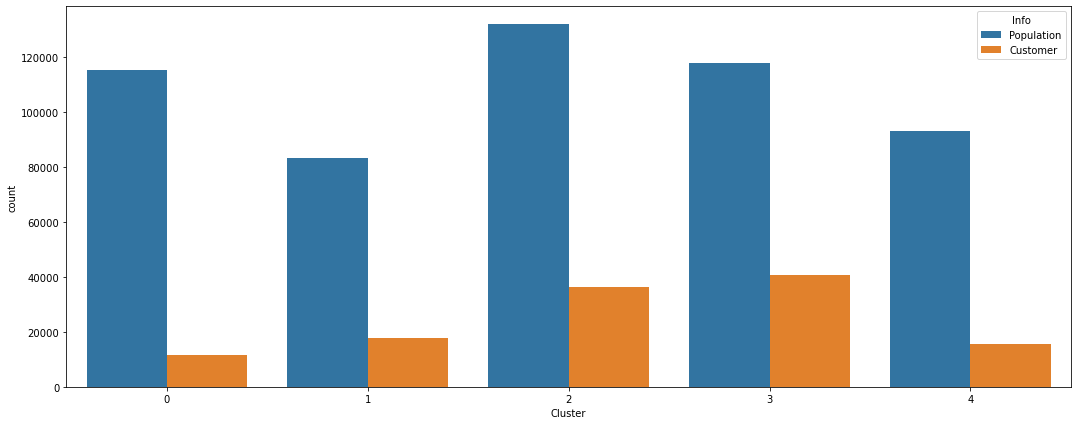

In [54]:
# Analysing the graphic above, the best value for k is 5
k_rr1 = 5

# Using the KMeans algorithm
kmeans_rr1 = KMeans(n_clusters = k_rr1, random_state=0).fit(df_rr1_num)

# Separating in clusters
rr1_cluster = kmeans_rr1.predict(df_rr1_num)

# Adding the cluster column to the dataframe
df_rr1_num['Cluster'] = rr1_cluster

# Adding the label (customer or azdias)
df_rr1_num['Info'] = origin_label

# Creating the graph of the cluster distribuition
fig, ax = plt.subplots(figsize = [18, 7])
ax = sns.countplot(data = df_rr1_num, x = 'Cluster', hue = 'Info')

**Analysis**

- For this group of information, there were no good clusters to be used for an analysis.

### PLZ8 information analysis

In [55]:
# Obtaining the columns in the Person Information Level
plz8_cols = df_columns[df_columns['Information_level'] == 'PLZ8']
plz8_cols_list = list(plz8_cols['columns_to_use'].values)
plz8_cols_list.append('Dataframe')

# Creating the dataframe
df_plz8 = data[plz8_cols_list]

df_plz8_num, origin_label = numeric_df(df_plz8)

print('Shape of the data: ', df_plz8.shape)

Number of numeric columns:  112
Shape of the data:  (664127, 113)


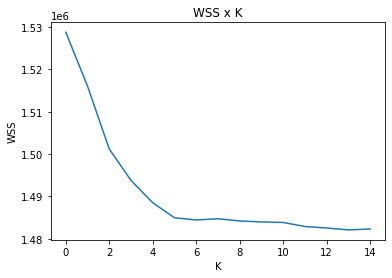

In [56]:
# Obtaining the best value of k
plz8_wss = calculate_WSS(df_plz8_num.values, 15)

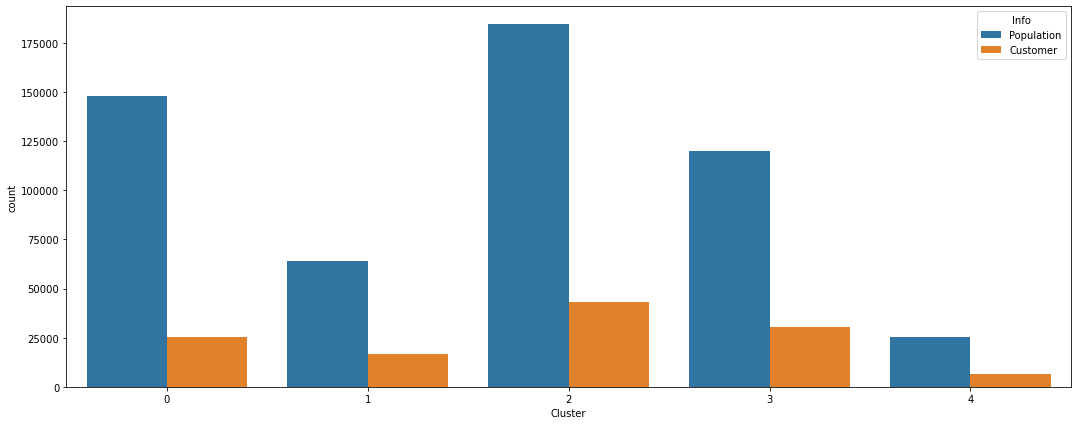

In [57]:
# Analysing the graphic above, the best value for k is 5
k_plz8 = 5

# Using the KMeans algorithm
kmeans_plz8 = KMeans(n_clusters = k_plz8, random_state=0).fit(df_plz8_num)

# Separating in clusters
plz8_cluster = kmeans_plz8.predict(df_plz8_num)

# Adding the cluster column to the dataframe
df_plz8_num['Cluster'] = plz8_cluster

# Adding the label (customer or azdias)
df_plz8_num['Info'] = origin_label

# Creating the graph of the cluster distribuition
fig, ax = plt.subplots(figsize = [18, 7])
ax = sns.countplot(data = df_plz8_num, x = 'Cluster', hue = 'Info')

**Analysis**

- For this group of information, there were no good clusters to be used for an analysis.

### Community information analysis

In [58]:
# Obtaining the columns in the Person Information Level
community_cols = df_columns[df_columns['Information_level'] == 'Community']
community_cols_list = list(community_cols['columns_to_use'].values)
community_cols_list.append('Dataframe')

# Creating the dataframe
df_community = data[community_cols_list]

df_community_num, origin_label = numeric_df(df_community)

print('Shape of the data: ', df_community.shape)

Number of numeric columns:  3
Shape of the data:  (664127, 4)


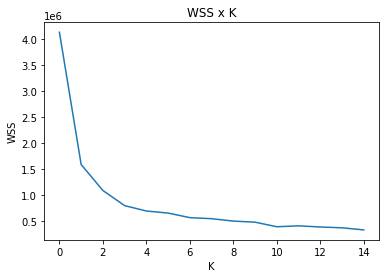

In [59]:
# Obtaining the best value of k
community_wss = calculate_WSS(df_community_num.values, 15)

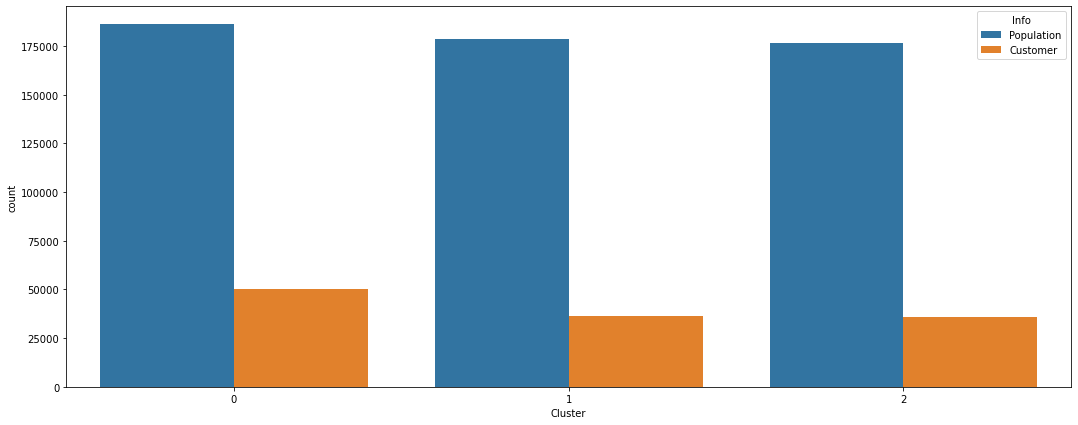

In [60]:
# Analysing the graphic above, the best value for k is 3
k_community = 3

# Using the KMeans algorithm
kmeans_community = KMeans(n_clusters = k_community, random_state=0).fit(df_community_num)

# Separating in clusters
community_cluster = kmeans_community.predict(df_community_num)

# Adding the cluster column to the dataframe
df_community_num['Cluster'] = community_cluster

# Adding the label (customer or azdias)
df_community_num['Info'] = origin_label

# Creating the graph of the cluster distribuition
fig, ax = plt.subplots(figsize = [18, 7])
ax = sns.countplot(data = df_community_num, x = 'Cluster', hue = 'Info')

**Analysis**

- For this group of information, there were no good clusters to be used for an analysis.

## Conclusion

After looking into each Information Level, I came up with the following caracteristics of the good candidates of becoming customers. The portion of the german population that most resembles the clients sample tend to:

- be more passive elderly or cultural elderly;
- have 46 years old or more;
- have high financial interest;
- be very money savers;
- be from multiperson households;
- be from multi-generational household;
- have high-income;
- have the dominating movement in their youth to be the economic miracle or the milk bar/individualisation
- be very religious;
- not be very sensual minded;
- be very rational;
- be more dutyfull traditional minded;
- be more traditional.
- have a more gourmet and versatile consumption type;
- have a very low transaction activity in the last 12 and 24 months;
- have a higher share of cars with more than 2499ccm;
- have a lower share of female car owners;
- have a higher share of top German manufacturer (Mercedes, BMW);
- have a lower share of small cars (referred to the county average)
- have a higher share of share of upper class cars (referred to the county average);
- have a lower share of cars with less than 59 KW engine power;
- have a higher share of cars with an engine power of more than 119 KW;
- have as the most common car manufacturer in the microcell: Top-German or VW-Audi;
- have a higher share of upper class cars (in an AZ specific definition);
- have biggers sized engines in the microcell;
- have a lower share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the microcell;
- have a higher share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.);
- have a higher share of upper class cars (BMW 7er etc.) in the microcell;
- have a higher share of roadster and convertables in the microcell;

# Part 4: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

## Action Plan

**First, two datasets will be generated:**

- One using all the features that are both in the excel files and in the original dataset.
- Another using the selected features discovered in the Customer Segmentation section.

**Both** datasets will be used to train and test a classifier model (Logistic Regressoion).

**Hipothesis: the result obtained using the selected features is better than the one using all the features.**

**Next**, the ADASYN algorithm will be used to see if the results are improved.

**Then**, using the dataset that provided the best result, several models will be used to determin wich one is best for the given problem. 

**After** the best model is selected, comes the hyperparameter tuning part, where the best hyperparameters are calculated to optimize the results. 

**The final result will be achieved using the best dataset, the best model and the best hyperparameters.**

**Observations**:

- Since the columns are mostly categorical, the data won't be normalized.
- Samples with null values will be removed.
- Only numeric columns will be used to train and test the models.

In [61]:
mailout_train = pd.read_csv('./Data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', index_col = 'LNR')
mailout_train.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA1

Original dataset label distribuition Counter({0: 42430, 1: 532})


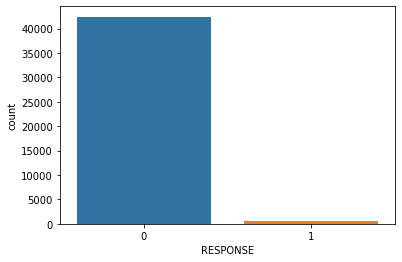

In [62]:
sns.countplot(data = mailout_train, x = 'RESPONSE');
print('Original dataset label distribuition %s' % Counter(mailout_train['RESPONSE']))

**OBSERVATION:**
- The data is highly unbalanced. Two analysis will be made, one with the data as it is and another using the ADASYN technique.

## Defining the best dataset

### All Features Analysis

In [63]:
# Creting the dataframe using only the columns present in both datasets and in the excel file
all_feat = columns_to_use.copy()
all_feat.append('RESPONSE')
df1_mailout = clean_data(mailout_train, all_feat)

# Selecting only numeric columns
df1_mailout = df1_mailout.select_dtypes(include = 'number')

# Preview of the data
df1_mailout.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,D19_KONSUMTYP,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_BANKEN_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KBA05_HERSTTEMP,KBA05_MODTEMP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_SEG10,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_0_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_180,KBA13_KMH_0_140,KBA13_KMH_140_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_0_60,KBA13_KW_70,KBA13_KW_61_120,KBA13_KW_80,KBA13_KW_90,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,RESPONSE
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [64]:
# Separating the features from the labels
X = df1_mailout.drop(columns = ['RESPONSE'])
y = df1_mailout['RESPONSE']

In [65]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 5, random_state = 0)
scores = cross_val_score(LogisticRegression(class_weight = 'balanced'), X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
score_1 = mean(scores)
print('ROC AUC: %.3f' % score_1)

ROC AUC: 0.622


### Selected Features Analysis

In [66]:
# Features selected in the Part 3

person_chosen_feat = [
    'AGER_TYP',    'ALTERSKATEGORIE_GROB',    'FINANZ_MINIMALIST',    'FINANZ_SPARER',
    'FINANZ_VORSORGER',           'FINANZ_UNAUFFAELLIGER',      'LP_LEBENSPHASE_FEIN',
    'LP_LEBENSPHASE_GROB',    'LP_FAMILIE_FEIN',    'LP_FAMILIE_GROB',    'LP_STATUS_FEIN',    
    'LP_STATUS_GROB',    'PRAEGENDE_JUGENDJAHRE',    'SEMIO_REL',    'SEMIO_LUST',    
    'SEMIO_RAT',    'SEMIO_PFLICHT',    'SEMIO_TRADV'
]

household_chosen_feat = [
    'ALTER_HH',    'D19_GESAMT_ANZ_12',    'D19_GESAMT_ANZ_24',
    'D19_GESAMT_OFFLINE_DATUM',       'D19_GESAMT_ONLINE_DATUM',        'D19_VERSAND_DATUM',          
]

rr3_chosen_feat = [
    'KBA05_CCM4',    'KBA05_FRAU',    'KBA05_HERST1',    'KBA05_KRSHERST1',    'KBA05_KRSKLEIN',    'KBA05_KRSOBER',
    'KBA05_KW1',    'KBA05_KW3',    'KBA05_MAXHERST',    'KBA05_MOD1',    'KBA05_MOTOR',    'KBA05_SEG2',
    'KBA05_SEG5',    'KBA05_SEG6',    'KBA05_SEG8',
]

In [67]:
# Using the main columns obtained in the previous part
selected_cols = []
for feature in person_chosen_feat:
    selected_cols.append(feature)
    
for feature in household_chosen_feat:
    selected_cols.append(feature)
    
for feature in rr3_chosen_feat:
    selected_cols.append(feature)

# Adding the label column
selected_cols.append('RESPONSE')

In [68]:
# Creting the dataframe using only the columns present in both datasets and in the excel file
df2_mailout = clean_data(mailout_train, selected_cols)
df2_mailout = df2_mailout.select_dtypes(include = 'number')

# Preview of the data
df2_mailout.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_UNAUFFAELLIGER,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,PRAEGENDE_JUGENDJAHRE,SEMIO_REL,SEMIO_LUST,SEMIO_RAT,SEMIO_PFLICHT,SEMIO_TRADV,ALTER_HH,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_VERSAND_DATUM,KBA05_CCM4,KBA05_FRAU,KBA05_HERST1,KBA05_KRSHERST1,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KW1,KBA05_KW3,KBA05_MAXHERST,KBA05_MOD1,KBA05_MOTOR,KBA05_SEG2,KBA05_SEG5,KBA05_SEG6,KBA05_SEG8,RESPONSE
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1763,2,4,3,1,5,1,8.0,2.0,1.0,1.0,3.0,2.0,1,1,7,2,3,1,8.0,0,0,9,9,9,3.0,3.0,4.0,4.0,1.0,2.0,1.0,2.0,3.0,3.0,2.0,2.0,2.0,0.0,2.0,0
1771,1,3,5,1,5,1,19.0,5.0,2.0,2.0,9.0,4.0,8,3,6,4,5,3,13.0,2,2,1,8,5,1.0,3.0,1.0,2.0,2.0,1.0,3.0,0.0,2.0,0.0,3.0,3.0,0.0,0.0,0.0,0
1776,1,4,5,1,4,1,0.0,0.0,0.0,0.0,10.0,5.0,2,5,7,1,1,1,9.0,0,2,6,7,6,1.0,3.0,2.0,4.0,3.0,2.0,3.0,1.0,4.0,1.0,2.0,4.0,2.0,0.0,0.0,0
1460,2,4,4,1,5,2,16.0,4.0,2.0,2.0,3.0,2.0,2,2,7,2,4,3,6.0,0,0,10,10,10,4.0,4.0,5.0,5.0,2.0,2.0,2.0,4.0,1.0,3.0,4.0,3.0,1.0,0.0,3.0,0
1783,2,3,3,1,5,1,9.0,3.0,1.0,1.0,6.0,3.0,3,4,6,5,4,2,9.0,0,1,7,10,7,0.0,3.0,3.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,0.0,1.0,0


In [69]:
# Removing the index
df2 = df2_mailout.reset_index()

# Separating the features from the labels
X2 = df2.drop(columns = ['RESPONSE','LNR'])
y2 = df2['RESPONSE']

In [70]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
scores = cross_val_score(LogisticRegression(class_weight = 'balanced'), X2, y2, scoring='roc_auc', cv=cv, n_jobs=-1)
score_2 = mean(scores)
print('ROC AUC: %.3f' % score_2)

ROC AUC: 0.566


In [71]:
sc = pd.DataFrame(data = [score_1, score_2], columns =['ROC AUC Score'], index = ['All Features Dataset', 'Selected Features Dataset'])
sc

,ROC AUC Score
All Features Dataset,0.621826
Selected Features Dataset,0.565682


**Result:**

Comparing the ROC AUC Score obtained using both datasets, it is clear that using all the features avaiable was better than using only the selected features. This can happen because a lot of information is beign lost when excluding the columns.

#### Conclusion

Analysing the results obtained, the All Features dataset was the one that resulted in the best performance. So, for the next step, he will be the one used.

**The Hipothesys is False. Using only the selected features probably excluded some features that were relevant for the classification.**

### Resampling Analysis

The Random Under Sampler and Random Over Sampler algorithms will be used to see if the results improve.

In [72]:
# Initializing the Stratified K-Fold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0)
X = df1_mailout.drop(columns = 'RESPONSE').values
y = df1_mailout['RESPONSE'].values

und = RandomUnderSampler(random_state = 0, sampling_strategy = 0.1)
X_res, y_res = und.fit_resample(X, y)
print(Counter(y_res))

over = RandomOverSampler(random_state = 0, sampling_strategy = 1)
X_res2, y_res2 = over.fit_resample(X_res, y_res)
print(Counter(y_res2))

Counter({0: 3990, 1: 399})
Counter({0: 3990, 1: 3990})


In [73]:
scores = cross_val_score(LogisticRegression(class_weight = 'balanced'), X_res2, y_res2, scoring='roc_auc', cv=cv, n_jobs=-1)
score_3 = mean(scores)
print('ROC AUC: %.3f' % score_3)

ROC AUC: 0.695


In [74]:
sc_2 = pd.DataFrame(data = [score_1, score_3], columns =['ROC AUC Score'], index = ['Without Resampling', 'With Resampling'])
sc_2

,ROC AUC Score
Without Resampling,0.621826
With Resampling,0.694943


#### Conclusion

Analysing the results, we can see that the usage of resampling techniques improved de overall AUC Score. From now on, the resampled dataset will be used.

## Defining the best model

### Testing the models

**Models tested:**

- Scikit-learn MLP
- Logistic Regression
- KNN
- AdaBoost

In [75]:
scores_models = models_prediction(X_res2, y_res2)

Training model: mlp
Training model: lr
Training model: knn
Training model: adaboost


In [76]:
scores_models

{'mlp': 0.819514575913468,
 'lr': 0.6949432478439206,
 'knn': 0.9469601949736497,
 'adaboost': 0.7452480197988707}

### Results

In [77]:
# Creating a dataframe
data = scores_models
index = ['MLP', 'Logistic Regressor', 'KNN', 'AdaBoost']

pd.DataFrame(data = data.values(), index = index, columns = ['Score'])

,Score
MLP,0.819515
Logistic Regressor,0.694943
KNN,0.946960
AdaBoost,0.745248


### Conclusion

Analysing the results of each classifier, the one that had the best performance was the KNN model.

The selected model will be used in the next step to find the optimal values for the hyperparameters.

## Hyperparameter tunning

To find the best values for the hyperparameters of the KNN model, the BayesSearchCV method will be used. 

In [78]:
opt = BayesSearchCV(
    KNeighborsClassifier(),
     {
         'n_neighbors': Integer(3, 21),
         'weights': Categorical(['uniform', 'distance']),
         'leaf_size': Integer(20, 100),
         'p': Integer(2, 20),
     },
     n_iter = 32,
     random_state = 0
)

opt.fit(X_res2, y_res2)

BayesSearchCV(estimator=KNeighborsClassifier(), n_iter=32, random_state=0,
              search_spaces={'leaf_size': Integer(low=20, high=100, prior='uniform', transform='identity'),
                             'n_neighbors': Integer(low=3, high=21, prior='uniform', transform='identity'),
                             'p': Integer(low=2, high=20, prior='uniform', transform='identity'),
                             'weights': Categorical(categories=('uniform', 'distance'), prior=None)})

In [79]:
# Getting the best model
best_clf = opt.best_estimator_
best_clf

KNeighborsClassifier(leaf_size=20, n_neighbors=3, weights='distance')

In [80]:
# Evaluating the model
scores = cross_val_score(best_clf, 
                         X_res2, y_res2,
                         scoring='roc_auc', 
                         cv=cv, 
                         n_jobs=-1)

score_f = mean(scores)
print('ROC AUC: %.3f' % score_f)

ROC AUC: 0.951


In [81]:
score_df = pd.DataFrame(data = scores, columns = ['Scores'])
print("Standard Deviation: ", score_df.std()[0])

Standard Deviation:  0.007875370107585114


In [82]:
# Training the model
best_clf.fit(X_res2, y_res2)

# Saving the trained model
filename = './Models/model.csv'
pickle.dump(best_clf, open(filename, 'wb'))

# Part 5: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [83]:
mailout_test = pd.read_csv('./Data/Udacity_MAILOUT_052018_TEST.csv', sep=';').set_index('LNR')
mailout_test.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA1

In [84]:
print('Shape of the test sample: ', mailout_test.shape)

Shape of the test sample:  (42833, 365)


In [85]:
# Cleaning the data
all_feat.remove('RESPONSE')

df_test = clean_data(mailout_test, all_feat, False)

df_test = df_test.select_dtypes(include = 'number')
print('Shape of the test sample: ', df_test.shape)

Shape of the test sample:  (42833, 263)


In [86]:
# Loading the model
filename = './Models/model.csv'
model = pickle.load(open(filename, 'rb'))

In [87]:
# Obtaining the predictions
y_pred = model.predict(df_test)

In [88]:
# Creating a dataframe
lnr = df_test.reset_index()['LNR']
csv = pd.DataFrame(data = lnr, columns = ['LNR'])
csv['RESPONSE'] = y_pred
csv.head()

,LNR,RESPONSE
0,1754,0
1,1770,0
2,1465,0
3,1470,0
4,1478,0


In [89]:
# Preview of the labels predicted
csv['RESPONSE'].value_counts()

0    36524
1     6309
Name: RESPONSE, dtype: int64

In [90]:
# Saving the data into a csv file
csv.to_csv('kaggle_submission.csv', index = False)